## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


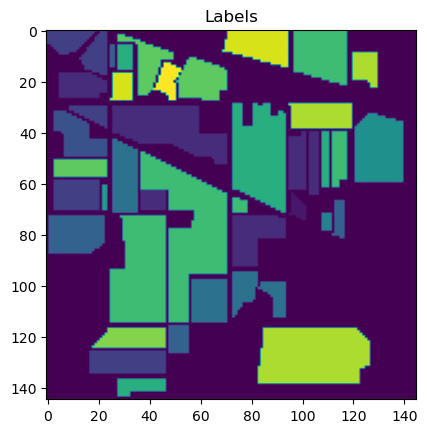

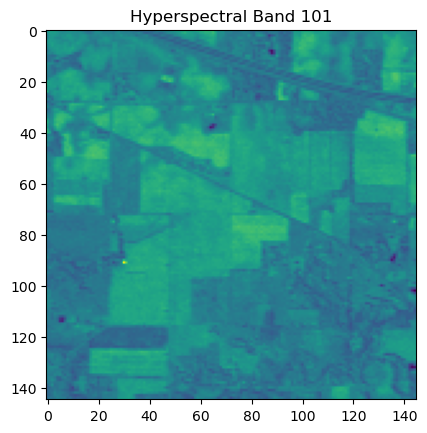

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(608, 5, 5, 200)
(70, 5, 5, 200)
(9571, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0796, PSNR: 10.4006


Epoch [1/50] Training Loss: 0.0647, PSNR: 11.4426
	[Val]   Batch [1/33] Loss: 0.0498, PSNR: 12.6942
	[Val]   Batch [10/33] Loss: 0.0493, PSNR: 12.3422
	[Val]   Batch [20/33] Loss: 0.0489, PSNR: 11.9357
	[Val]   Batch [30/33] Loss: 0.0473, PSNR: 12.3246
Epoch [1/50] Validation Loss: 0.0495, PSNR: 12.5135

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0507, PSNR: 12.6184


Epoch [2/50] Training Loss: 0.0397, PSNR: 13.6239
	[Val]   Batch [1/33] Loss: 0.0290, PSNR: 15.0413
	[Val]   Batch [10/33] Loss: 0.0285, PSNR: 14.7124
	[Val]   Batch [20/33] Loss: 0.0283, PSNR: 14.3109
	[Val]   Batch [30/33] Loss: 0.0276, PSNR: 14.6665
Epoch [2/50] Validation Loss: 0.0289, PSNR: 14.8422

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0298, PSNR: 14.6724


Epoch [3/50] Training Loss: 0.0233, PSNR: 15.8873
	[Val]   Batch [1/33] Loss: 0.0175, PSNR: 17.2437
	[Val]   Batch [10/33] Loss: 0.0170, PSNR: 16.9600
	[Val]   Batch [20/33] Loss: 0.0168, PSNR: 16.5867
	[Val]   Batch [30/33] Loss: 0.0163, PSNR: 16.9519
Epoch [3/50] Validation Loss: 0.0174, PSNR: 17.0479

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0164, PSNR: 17.5049


Epoch [4/50] Training Loss: 0.0142, PSNR: 18.0362
	[Val]   Batch [1/33] Loss: 0.0116, PSNR: 19.0129
	[Val]   Batch [10/33] Loss: 0.0112, PSNR: 18.7920
	[Val]   Batch [20/33] Loss: 0.0109, PSNR: 18.4581
	[Val]   Batch [30/33] Loss: 0.0106, PSNR: 18.8409
Epoch [4/50] Validation Loss: 0.0116, PSNR: 18.8318

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0113, PSNR: 18.8220


Epoch [5/50] Training Loss: 0.0095, PSNR: 19.7901
	[Val]   Batch [1/33] Loss: 0.0082, PSNR: 20.5255
	[Val]   Batch [10/33] Loss: 0.0078, PSNR: 20.3712
	[Val]   Batch [20/33] Loss: 0.0075, PSNR: 20.0878
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.4905
Epoch [5/50] Validation Loss: 0.0082, PSNR: 20.3540

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0076, PSNR: 20.6179


Epoch [6/50] Training Loss: 0.0070, PSNR: 21.1472
	[Val]   Batch [1/33] Loss: 0.0063, PSNR: 21.7039
	[Val]   Batch [10/33] Loss: 0.0058, PSNR: 21.6320
	[Val]   Batch [20/33] Loss: 0.0056, PSNR: 21.3828
	[Val]   Batch [30/33] Loss: 0.0054, PSNR: 21.7748
Epoch [6/50] Validation Loss: 0.0062, PSNR: 21.5437

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0063, PSNR: 21.7713


Epoch [7/50] Training Loss: 0.0054, PSNR: 22.2168
	[Val]   Batch [1/33] Loss: 0.0050, PSNR: 22.6573
	[Val]   Batch [10/33] Loss: 0.0046, PSNR: 22.6764
	[Val]   Batch [20/33] Loss: 0.0043, PSNR: 22.4682
	[Val]   Batch [30/33] Loss: 0.0042, PSNR: 22.8842
Epoch [7/50] Validation Loss: 0.0050, PSNR: 22.5285

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0049, PSNR: 22.6948


Epoch [8/50] Training Loss: 0.0044, PSNR: 23.0999
	[Val]   Batch [1/33] Loss: 0.0041, PSNR: 23.4965
	[Val]   Batch [10/33] Loss: 0.0037, PSNR: 23.6119
	[Val]   Batch [20/33] Loss: 0.0035, PSNR: 23.4413
	[Val]   Batch [30/33] Loss: 0.0033, PSNR: 23.8991
Epoch [8/50] Validation Loss: 0.0041, PSNR: 23.4121

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0040, PSNR: 23.7231


Epoch [9/50] Training Loss: 0.0037, PSNR: 23.8380
	[Val]   Batch [1/33] Loss: 0.0035, PSNR: 24.2494
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.4897
	[Val]   Batch [20/33] Loss: 0.0028, PSNR: 24.3579
	[Val]   Batch [30/33] Loss: 0.0027, PSNR: 24.8034
Epoch [9/50] Validation Loss: 0.0034, PSNR: 24.2198

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0036, PSNR: 24.3940


Epoch [10/50] Training Loss: 0.0032, PSNR: 24.4806
	[Val]   Batch [1/33] Loss: 0.0031, PSNR: 24.7661
	[Val]   Batch [10/33] Loss: 0.0026, PSNR: 25.0448
	[Val]   Batch [20/33] Loss: 0.0025, PSNR: 24.9330
	[Val]   Batch [30/33] Loss: 0.0023, PSNR: 25.4202
Epoch [10/50] Validation Loss: 0.0030, PSNR: 24.7529

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0029, PSNR: 25.0588


Epoch [11/50] Training Loss: 0.0028, PSNR: 25.0497
	[Val]   Batch [1/33] Loss: 0.0027, PSNR: 25.3127
	[Val]   Batch [10/33] Loss: 0.0023, PSNR: 25.6726
	[Val]   Batch [20/33] Loss: 0.0021, PSNR: 25.6045
	[Val]   Batch [30/33] Loss: 0.0020, PSNR: 26.1276
Epoch [11/50] Validation Loss: 0.0026, PSNR: 25.3475

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0025, PSNR: 25.7418


Epoch [12/50] Training Loss: 0.0026, PSNR: 25.4893
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5944
	[Val]   Batch [10/33] Loss: 0.0021, PSNR: 25.9781
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.9209
	[Val]   Batch [30/33] Loss: 0.0018, PSNR: 26.4646
Epoch [12/50] Validation Loss: 0.0024, PSNR: 25.6516

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 26.5145


Epoch [13/50] Training Loss: 0.0023, PSNR: 25.9346
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.2601
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.6810
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.6629
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2315
Epoch [13/50] Validation Loss: 0.0021, PSNR: 26.3278

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 26.9178


Epoch [14/50] Training Loss: 0.0021, PSNR: 26.3120
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.6258
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 27.0159
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.0039
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.6226
Epoch [14/50] Validation Loss: 0.0019, PSNR: 26.6854

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 27.2145


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.6868
	[Val]   Batch [1/33] Loss: 0.0018, PSNR: 27.0929
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.4634
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.4816
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 28.0693
Epoch [15/50] Validation Loss: 0.0017, PSNR: 27.1352

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.2877


Epoch [16/50] Training Loss: 0.0018, PSNR: 27.0357
	[Val]   Batch [1/33] Loss: 0.0016, PSNR: 27.5708
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.9013
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 27.9384
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.5170
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.5858

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 27.1425


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.3954
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.0714
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.3529
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.4104
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.0237
Epoch [17/50] Validation Loss: 0.0014, PSNR: 28.0681

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.7413


Epoch [18/50] Training Loss: 0.0015, PSNR: 27.7332
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.5764
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.8145
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.9152
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.5125
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.5614

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.0884


Epoch [19/50] Training Loss: 0.0014, PSNR: 28.0314
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.5479
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7510
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.8457
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.5447
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.5453

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.7980


Epoch [20/50] Training Loss: 0.0013, PSNR: 28.3236
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.0824
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.2657
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.3959
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.9826
Epoch [20/50] Validation Loss: 0.0011, PSNR: 29.0726

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.9560


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.5550
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.5058
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.6459
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.8202
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5205
Epoch [21/50] Validation Loss: 0.0010, PSNR: 29.5136

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.1468


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.8272
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6688
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.8243
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0317
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7165
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.6851

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.2121


Epoch [23/50] Training Loss: 0.0011, PSNR: 29.0290
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8800
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0494
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2993
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.0199
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.9335

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.4607


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.2044
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1331
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2883
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.5543
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2253
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.1859

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.7540


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.4035
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5439
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6822
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9804
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7061
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.5882

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.8630


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.5035
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6019
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7292
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0226
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7574
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.6540

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 30.1526


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.6095
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.7421
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8931
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.1924
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.9596
Epoch [27/50] Validation Loss: 0.0007, PSNR: 30.8108

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.6592


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.7476
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8599
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.9819
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2878
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0465
Epoch [28/50] Validation Loss: 0.0007, PSNR: 30.9058

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0008, PSNR: 30.2917


Epoch [29/50] Training Loss: 0.0009, PSNR: 29.8785
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 31.0115
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.1321
	[Val]   Batch [20/33] Loss: 0.0005, PSNR: 31.4311
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.1396
Epoch [29/50] Validation Loss: 0.0007, PSNR: 31.0598

LOG: Epoch [30/50]
	 Training Batch [1/129], Loss: 0.0007, PSNR: 31.0524


Epoch [30/50] Training Loss: 0.0009, PSNR: 29.9378
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 31.1436
	[Val]   Batch [10/33] Loss: 0.0006, PSNR: 31.2471
	[Val]   Batch [20/33] Loss: 0.0005, PSNR: 31.5744
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.3618
Epoch [30/50] Validation Loss: 0.0007, PSNR: 31.1954
Early stopping triggered at epoch 30. No improvement for 3 epochs.


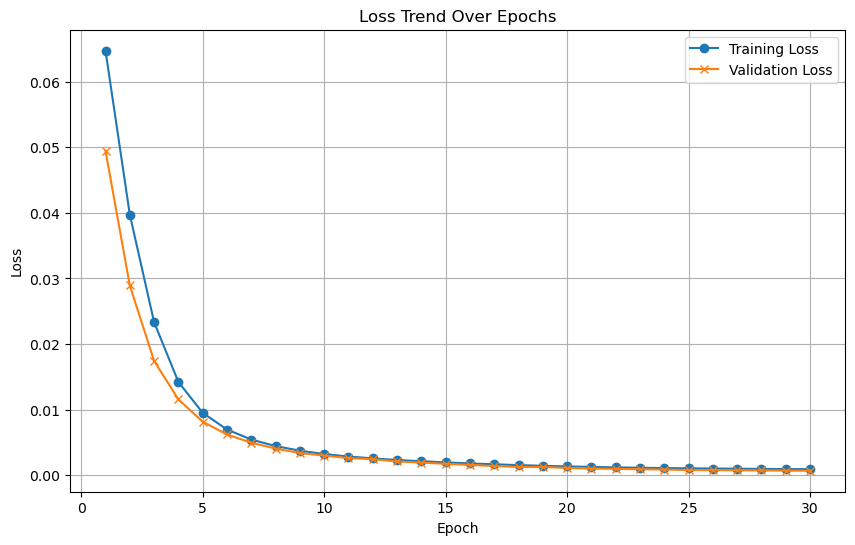

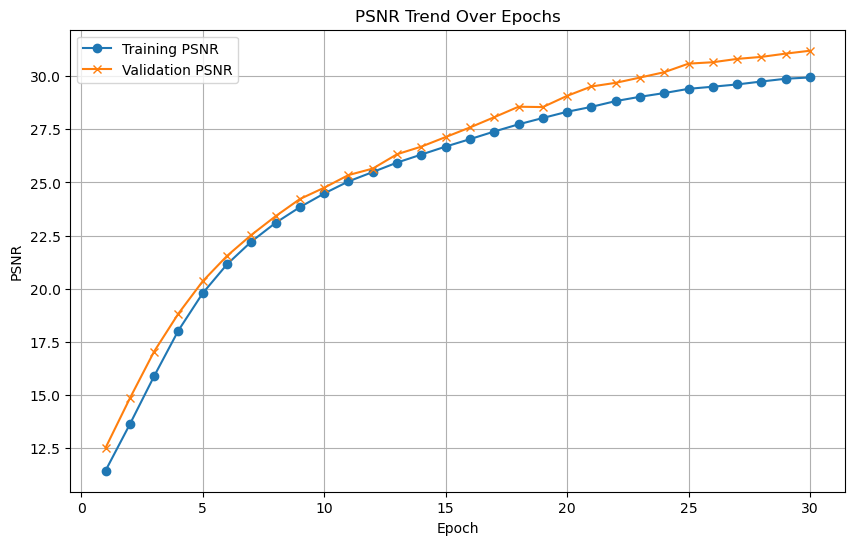

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/38 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7943
    Validation Batch [1/1], Loss: 2.7755
Validation Loss: 2.7755, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.7755. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7469
    Validation Batch [1/1], Loss: 2.7756
Validation Loss: 2.7756, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7389
    Validation Batch [1/1], Loss: 2.7758
Validation Loss: 2.7758, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7176
    Validation Batch [1/1], Loss: 2.7759
Validation Loss: 2.7759, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 2.6840
    Validation Batch [1/1], Loss: 2.7762
Validation Loss: 2.7762, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6693
    Validation Batch [1/1], Loss: 2.7763
Validation Loss: 2.7763, Validation Accuracy: 11.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6674
    Validation Batch [1/1], Loss: 2.7763
Validation Loss: 2.7763, Validation Accuracy: 14.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6552
    Validation Batch [1/1], Loss: 2.7764
Validation Loss: 2.7764, Validation

Epoch [18/1000] completed, Average Training Loss: 2.6071
    Validation Batch [1/1], Loss: 2.7749
Validation Loss: 2.7749, Validation Accuracy: 7.14%
Validation loss improved from 2.7755 to 2.7749. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5837
    Validation Batch [1/1], Loss: 2.7740
Validation Loss: 2.7740, Validation Accuracy: 7.14%
Validation loss improved from 2.7749 to 2.7740. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5864
    Validation Batch [1/1], Loss: 2.7730
Validation Loss: 2.7730, Validation Accuracy: 7.14%
Validation loss improved from 2.7740 to 2.7730. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5639
    Validation Batch [1/1], Loss: 2.7718
Validation Loss: 2.7718, Validation Accuracy: 7.14%
Validation loss improved from 2.7730 to 2.7718. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/10

Epoch [30/1000] completed, Average Training Loss: 2.5190
    Validation Batch [1/1], Loss: 2.7496
Validation Loss: 2.7496, Validation Accuracy: 10.00%
Validation loss improved from 2.7533 to 2.7496. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.5020
    Validation Batch [1/1], Loss: 2.7454
Validation Loss: 2.7454, Validation Accuracy: 7.14%
Validation loss improved from 2.7496 to 2.7454. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4952
    Validation Batch [1/1], Loss: 2.7411
Validation Loss: 2.7411, Validation Accuracy: 7.14%
Validation loss improved from 2.7454 to 2.7411. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.4952
    Validation Batch [1/1], Loss: 2.7350
Validation Loss: 2.7350, Validation Accuracy: 7.14%
Validation loss improved from 2.7411 to 2.7350. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1

Epoch [42/1000] completed, Average Training Loss: 2.4346
    Validation Batch [1/1], Loss: 2.6456
Validation Loss: 2.6456, Validation Accuracy: 11.43%
Validation loss improved from 2.6569 to 2.6456. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.4287
    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 11.43%
Validation loss improved from 2.6456 to 2.6418. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.4285
    Validation Batch [1/1], Loss: 2.6389
Validation Loss: 2.6389, Validation Accuracy: 11.43%
Validation loss improved from 2.6418 to 2.6389. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.4143
    Validation Batch [1/1], Loss: 2.6324
Validation Loss: 2.6324, Validation Accuracy: 11.43%
Validation loss improved from 2.6389 to 2.6324. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [4

    Validation Batch [1/1], Loss: 2.5284
Validation Loss: 2.5284, Validation Accuracy: 28.57%
Validation loss improved from 2.5386 to 2.5284. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.3679
    Validation Batch [1/1], Loss: 2.5152
Validation Loss: 2.5152, Validation Accuracy: 28.57%
Validation loss improved from 2.5284 to 2.5152. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.3615
    Validation Batch [1/1], Loss: 2.4871
Validation Loss: 2.4871, Validation Accuracy: 28.57%
Validation loss improved from 2.5152 to 2.4871. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 2.3583
    Validation Batch [1/1], Loss: 2.4437
Validation Loss: 2.4437, Validation Accuracy: 28.57%
Validation loss improved from 2.4871 to 2.4437. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 2.3358
    Vali

Epoch [65/1000] completed, Average Training Loss: 2.2899
    Validation Batch [1/1], Loss: 2.3341
Validation Loss: 2.3341, Validation Accuracy: 35.71%
Validation loss improved from 2.3446 to 2.3341. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 2.2904
    Validation Batch [1/1], Loss: 2.3104
Validation Loss: 2.3104, Validation Accuracy: 37.14%
Validation loss improved from 2.3341 to 2.3104. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.2748
    Validation Batch [1/1], Loss: 2.2918
Validation Loss: 2.2918, Validation Accuracy: 37.14%
Validation loss improved from 2.3104 to 2.2918. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 2.2923
    Validation Batch [1/1], Loss: 2.2783
Validation Loss: 2.2783, Validation Accuracy: 38.57%
Validation loss improved from 2.2918 to 2.2783. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [6

Epoch [76/1000] completed, Average Training Loss: 2.2224
    Validation Batch [1/1], Loss: 2.1941
Validation Loss: 2.1941, Validation Accuracy: 40.00%
Validation loss improved from 2.1971 to 2.1941. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.2221
    Validation Batch [1/1], Loss: 2.2071
Validation Loss: 2.2071, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.2185
    Validation Batch [1/1], Loss: 2.1811
Validation Loss: 2.1811, Validation Accuracy: 38.57%
Validation loss improved from 2.1941 to 2.1811. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 2.2046
    Validation Batch [1/1], Loss: 2.1625
Validation Loss: 2.1625, Validation Accuracy: 41.43%
Validation loss improved from 2.1811 to 2.1625. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] complet

Validation Loss: 2.0420, Validation Accuracy: 40.00%
Validation loss improved from 2.0493 to 2.0420. Saving model...

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 2.1501
    Validation Batch [1/1], Loss: 2.0378
Validation Loss: 2.0378, Validation Accuracy: 40.00%
Validation loss improved from 2.0420 to 2.0378. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 2.1474
    Validation Batch [1/1], Loss: 2.0329
Validation Loss: 2.0329, Validation Accuracy: 41.43%
Validation loss improved from 2.0378 to 2.0329. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 2.1240
    Validation Batch [1/1], Loss: 2.0073
Validation Loss: 2.0073, Validation Accuracy: 41.43%
Validation loss improved from 2.0329 to 2.0073. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 2.1317
    Validation Batch [1/1], Loss: 2.0186
Validati

Epoch [99/1000] completed, Average Training Loss: 2.0813
    Validation Batch [1/1], Loss: 1.9547
Validation Loss: 1.9547, Validation Accuracy: 41.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 2.0572
    Validation Batch [1/1], Loss: 1.9387
Validation Loss: 1.9387, Validation Accuracy: 41.43%
Validation loss improved from 1.9517 to 1.9387. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 2.0462
    Validation Batch [1/1], Loss: 1.9254
Validation Loss: 1.9254, Validation Accuracy: 41.43%
Validation loss improved from 1.9387 to 1.9254. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 2.0740
    Validation Batch [1/1], Loss: 1.9273
Validation Loss: 1.9273, Validation Accuracy: 41.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Ave

Epoch [109/1000] completed, Average Training Loss: 1.9803
    Validation Batch [1/1], Loss: 1.8993
Validation Loss: 1.8993, Validation Accuracy: 45.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.9764
    Validation Batch [1/1], Loss: 1.9080
Validation Loss: 1.9080, Validation Accuracy: 45.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.9544
    Validation Batch [1/1], Loss: 1.9394
Validation Loss: 1.9394, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.9876
    Validation Batch [1/1], Loss: 1.9016
Validation Loss: 1.9016, Validation Accuracy: 45.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.9670
  

Epoch [123/1000] completed, Average Training Loss: 1.9137
    Validation Batch [1/1], Loss: 1.8129
Validation Loss: 1.8129, Validation Accuracy: 45.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.8864
    Validation Batch [1/1], Loss: 1.7687
Validation Loss: 1.7687, Validation Accuracy: 42.86%
Validation loss improved from 1.7925 to 1.7687. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.8877
    Validation Batch [1/1], Loss: 1.7701
Validation Loss: 1.7701, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.8574
    Validation Batch [1/1], Loss: 1.8187
Validation Loss: 1.8187, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training 

Epoch [133/1000] completed, Average Training Loss: 1.8224
    Validation Batch [1/1], Loss: 1.7961
Validation Loss: 1.7961, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.8259
    Validation Batch [1/1], Loss: 1.8033
Validation Loss: 1.8033, Validation Accuracy: 50.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 1.8269
    Validation Batch [1/1], Loss: 1.8244
Validation Loss: 1.8244, Validation Accuracy: 48.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 1.8178
    Validation Batch [1/1], Loss: 1.7713
Validation Loss: 1.7713, Validation Accuracy: 45.71%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.7836
  

Epoch [148/1000] completed, Average Training Loss: 1.7075
    Validation Batch [1/1], Loss: 1.7829
Validation Loss: 1.7829, Validation Accuracy: 47.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.6972
    Validation Batch [1/1], Loss: 1.8180
Validation Loss: 1.8180, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.7033
    Validation Batch [1/1], Loss: 1.6458
Validation Loss: 1.6458, Validation Accuracy: 40.00%
Validation loss improved from 1.6488 to 1.6458. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.6952
    Validation Batch [1/1], Loss: 1.6149
Validation Loss: 1.6149, Validation Accuracy: 42.86%
Validation loss improved from 1.6458 to 1.6149. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Av

Epoch [157/1000] completed, Average Training Loss: 1.6258
    Validation Batch [1/1], Loss: 1.7433
Validation Loss: 1.7433, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.6520
    Validation Batch [1/1], Loss: 1.6064
Validation Loss: 1.6064, Validation Accuracy: 52.86%
Validation loss improved from 1.6149 to 1.6064. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.6292
    Validation Batch [1/1], Loss: 1.6115
Validation Loss: 1.6115, Validation Accuracy: 54.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training Loss: 1.6079
    Validation Batch [1/1], Loss: 1.6517
Validation Loss: 1.6517, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training 

Epoch [172/1000] completed, Average Training Loss: 1.5417
    Validation Batch [1/1], Loss: 1.7411
Validation Loss: 1.7411, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.5355
    Validation Batch [1/1], Loss: 1.5704
Validation Loss: 1.5704, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 1.5075
    Validation Batch [1/1], Loss: 1.5393
Validation Loss: 1.5393, Validation Accuracy: 50.00%
Validation loss improved from 1.5547 to 1.5393. Saving model...

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 1.5263
    Validation Batch [1/1], Loss: 1.5454
Validation Loss: 1.5454, Validation Accuracy: 54.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.5579
Validation Loss: 1.5579, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.4886
    Validation Batch [1/1], Loss: 1.4795
Validation Loss: 1.4795, Validation Accuracy: 52.86%
Validation loss improved from 1.5023 to 1.4795. Saving model...

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.4803
    Validation Batch [1/1], Loss: 1.5042
Validation Loss: 1.5042, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.4833
    Validation Batch [1/1], Loss: 1.5465
Validation Loss: 1.5465, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.4470
    Validation Batch [1/1], Loss: 1.5401
Vali

Epoch [195/1000] completed, Average Training Loss: 1.3587
    Validation Batch [1/1], Loss: 1.4197
Validation Loss: 1.4197, Validation Accuracy: 61.43%
Validation loss improved from 1.4314 to 1.4197. Saving model...

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.3720
    Validation Batch [1/1], Loss: 1.4217
Validation Loss: 1.4217, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.3801
    Validation Batch [1/1], Loss: 1.5311
Validation Loss: 1.5311, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.3384
    Validation Batch [1/1], Loss: 1.4287
Validation Loss: 1.4287, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training 

Epoch [202/1000] completed, Average Training Loss: 1.3235
    Validation Batch [1/1], Loss: 1.4944
Validation Loss: 1.4944, Validation Accuracy: 54.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.2981
    Validation Batch [1/1], Loss: 1.4953
Validation Loss: 1.4953, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 1.2868
    Validation Batch [1/1], Loss: 1.4037
Validation Loss: 1.4037, Validation Accuracy: 71.43%
Validation loss improved from 1.4101 to 1.4037. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 1.2656
    Validation Batch [1/1], Loss: 1.4179
Validation Loss: 1.4179, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training 

Epoch [218/1000] completed, Average Training Loss: 1.1882
    Validation Batch [1/1], Loss: 1.3061
Validation Loss: 1.3061, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 1.1545
    Validation Batch [1/1], Loss: 1.3838
Validation Loss: 1.3838, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 1.1583
    Validation Batch [1/1], Loss: 1.3500
Validation Loss: 1.3500, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 1.1528
    Validation Batch [1/1], Loss: 1.3732
Validation Loss: 1.3732, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 1.1565
  

Epoch [225/1000] completed, Average Training Loss: 1.1357
    Validation Batch [1/1], Loss: 1.3074
Validation Loss: 1.3074, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 1.1467
    Validation Batch [1/1], Loss: 1.3479
Validation Loss: 1.3479, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 1.1276
    Validation Batch [1/1], Loss: 1.2771
Validation Loss: 1.2771, Validation Accuracy: 77.14%
Validation loss improved from 1.2939 to 1.2771. Saving model...

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 1.1091
    Validation Batch [1/1], Loss: 1.2457
Validation Loss: 1.2457, Validation Accuracy: 74.29%
Validation loss improved from 1.2771 to 1.2457. Saving model...

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, 

Epoch [242/1000] completed, Average Training Loss: 1.0317
    Validation Batch [1/1], Loss: 1.1828
Validation Loss: 1.1828, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.9942
    Validation Batch [1/1], Loss: 1.2901
Validation Loss: 1.2901, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.9695
    Validation Batch [1/1], Loss: 1.1789
Validation Loss: 1.1789, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.9953
    Validation Batch [1/1], Loss: 1.1224
Validation Loss: 1.1224, Validation Accuracy: 75.71%
Validation loss improved from 1.1354 to 1.1224. Saving model...

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training 

Epoch [249/1000] completed, Average Training Loss: 0.9695
    Validation Batch [1/1], Loss: 1.0782
Validation Loss: 1.0782, Validation Accuracy: 77.14%
Validation loss improved from 1.0846 to 1.0782. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.9772
    Validation Batch [1/1], Loss: 1.2291
Validation Loss: 1.2291, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.9449
    Validation Batch [1/1], Loss: 1.2487
Validation Loss: 1.2487, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.9802
    Validation Batch [1/1], Loss: 1.1234
Validation Loss: 1.1234, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.2667
Validation Loss: 1.2667, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [266/1000] - Training
Epoch [266/1000] completed, Average Training Loss: 0.8665
    Validation Batch [1/1], Loss: 1.3189
Validation Loss: 1.3189, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.8796
    Validation Batch [1/1], Loss: 1.0527
Validation Loss: 1.0527, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.8388
    Validation Batch [1/1], Loss: 1.1026
Validation Loss: 1.1026, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.8591
    Validation Batch [1/1], Loss: 0.9570
Validation Loss: 0.

Epoch [271/1000] completed, Average Training Loss: 0.8104
    Validation Batch [1/1], Loss: 1.2520
Validation Loss: 1.2520, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.8127
    Validation Batch [1/1], Loss: 1.0836
Validation Loss: 1.0836, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.8278
    Validation Batch [1/1], Loss: 0.9360
Validation Loss: 0.9360, Validation Accuracy: 81.43%
Validation loss improved from 0.9570 to 0.9360. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.8518
    Validation Batch [1/1], Loss: 1.0620
Validation Loss: 1.0620, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training 

Epoch [288/1000] completed, Average Training Loss: 0.7468
    Validation Batch [1/1], Loss: 0.8684
Validation Loss: 0.8684, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.6962
    Validation Batch [1/1], Loss: 0.8596
Validation Loss: 0.8596, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.7233
    Validation Batch [1/1], Loss: 0.9678
Validation Loss: 0.9678, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.7301
    Validation Batch [1/1], Loss: 0.8624
Validation Loss: 0.8624, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.7037
  

Epoch [295/1000] completed, Average Training Loss: 0.6956
    Validation Batch [1/1], Loss: 1.0420
Validation Loss: 1.0420, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.6685
    Validation Batch [1/1], Loss: 0.9334
Validation Loss: 0.9334, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.6988
    Validation Batch [1/1], Loss: 0.8173
Validation Loss: 0.8173, Validation Accuracy: 82.86%
Validation loss improved from 0.8225 to 0.8173. Saving model...

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.6825
    Validation Batch [1/1], Loss: 1.0203
Validation Loss: 1.0203, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training 

Epoch [306/1000] completed, Average Training Loss: 0.6175
    Validation Batch [1/1], Loss: 0.8307
Validation Loss: 0.8307, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.6345
    Validation Batch [1/1], Loss: 0.9077
Validation Loss: 0.9077, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.6439
    Validation Batch [1/1], Loss: 0.8599
Validation Loss: 0.8599, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.6163
    Validation Batch [1/1], Loss: 0.9878
Validation Loss: 0.9878, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.6510

Epoch [328/1000] completed, Average Training Loss: 0.5409
    Validation Batch [1/1], Loss: 0.8291
Validation Loss: 0.8291, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.5209
    Validation Batch [1/1], Loss: 0.6543
Validation Loss: 0.6543, Validation Accuracy: 82.86%
Validation loss improved from 0.7201 to 0.6543. Saving model...

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.5374
    Validation Batch [1/1], Loss: 0.6842
Validation Loss: 0.6842, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.5501
    Validation Batch [1/1], Loss: 0.8277
Validation Loss: 0.8277, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training 

Epoch [351/1000] completed, Average Training Loss: 0.4373
    Validation Batch [1/1], Loss: 0.7041
Validation Loss: 0.7041, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [352/1000] - Training
Epoch [352/1000] completed, Average Training Loss: 0.4600
    Validation Batch [1/1], Loss: 0.5940
Validation Loss: 0.5940, Validation Accuracy: 85.71%
Validation loss improved from 0.6025 to 0.5940. Saving model...

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.4584
    Validation Batch [1/1], Loss: 0.5978
Validation Loss: 0.5978, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.4518
    Validation Batch [1/1], Loss: 0.6626
Validation Loss: 0.6626, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training 

Epoch [375/1000] completed, Average Training Loss: 0.3806
    Validation Batch [1/1], Loss: 0.8196
Validation Loss: 0.8196, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.3830
    Validation Batch [1/1], Loss: 0.6998
Validation Loss: 0.6998, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.3583
    Validation Batch [1/1], Loss: 0.6970
Validation Loss: 0.6970, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.4082
    Validation Batch [1/1], Loss: 0.9625
Validation Loss: 0.9625, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.382

Epoch [398/1000] completed, Average Training Loss: 0.3002
    Validation Batch [1/1], Loss: 0.6695
Validation Loss: 0.6695, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.3118
    Validation Batch [1/1], Loss: 0.5966
Validation Loss: 0.5966, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.3152
    Validation Batch [1/1], Loss: 0.4788
Validation Loss: 0.4788, Validation Accuracy: 90.00%
Validation loss improved from 0.4816 to 0.4788. Saving model...

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.3041
    Validation Batch [1/1], Loss: 0.5328
Validation Loss: 0.5328, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training 

Epoch [421/1000] completed, Average Training Loss: 0.2479
    Validation Batch [1/1], Loss: 0.5052
Validation Loss: 0.5052, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.2588
    Validation Batch [1/1], Loss: 0.4811
Validation Loss: 0.4811, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.2682
    Validation Batch [1/1], Loss: 0.4734
Validation Loss: 0.4734, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.2493
    Validation Batch [1/1], Loss: 0.5937
Validation Loss: 0.5937, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.2506
  

Epoch [444/1000] completed, Average Training Loss: 0.2323
    Validation Batch [1/1], Loss: 0.4731
Validation Loss: 0.4731, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.2232
    Validation Batch [1/1], Loss: 0.5127
Validation Loss: 0.5127, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1965
    Validation Batch [1/1], Loss: 0.5249
Validation Loss: 0.5249, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.2134
    Validation Batch [1/1], Loss: 0.5679
Validation Loss: 0.5679, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.2120
  

    Validation Batch [1/1], Loss: 0.8247
Validation Loss: 0.8247, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1991
    Validation Batch [1/1], Loss: 0.5424
Validation Loss: 0.5424, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1948
    Validation Batch [1/1], Loss: 0.5193
Validation Loss: 0.5193, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1903
    Validation Batch [1/1], Loss: 0.4798
Validation Loss: 0.4798, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1841
    Validation Batch [1/1], Loss: 0.3719
Validation Loss

Epoch [490/1000] completed, Average Training Loss: 0.1596
    Validation Batch [1/1], Loss: 0.4509
Validation Loss: 0.4509, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1600
    Validation Batch [1/1], Loss: 0.8214
Validation Loss: 0.8214, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1568
    Validation Batch [1/1], Loss: 1.1694
Validation Loss: 1.1694, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1508
    Validation Batch [1/1], Loss: 0.4505
Validation Loss: 0.4505, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.157

Epoch [514/1000] completed, Average Training Loss: 0.1230
    Validation Batch [1/1], Loss: 0.4640
Validation Loss: 0.4640, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.1355
    Validation Batch [1/1], Loss: 0.5968
Validation Loss: 0.5968, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.1468
    Validation Batch [1/1], Loss: 0.4975
Validation Loss: 0.4975, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.1244
    Validation Batch [1/1], Loss: 0.6284
Validation Loss: 0.6284, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.123

Epoch [537/1000] completed, Average Training Loss: 0.1107
    Validation Batch [1/1], Loss: 0.3473
Validation Loss: 0.3473, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.1175
    Validation Batch [1/1], Loss: 0.3242
Validation Loss: 0.3242, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.4050
Validation Loss: 0.4050, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [540/1000] - Training
Epoch [540/1000] completed, Average Training Loss: 0.1083
    Validation Batch [1/1], Loss: 0.4255
Validation Loss: 0.4255, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [541/1000] - Training
Epoch [541/1000] completed, Average Training Loss: 0.127

Epoch [559/1000] completed, Average Training Loss: 0.0923
    Validation Batch [1/1], Loss: 0.4128
Validation Loss: 0.4128, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0901
    Validation Batch [1/1], Loss: 0.3792
Validation Loss: 0.3792, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.3142
Validation Loss: 0.3142, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.1024
    Validation Batch [1/1], Loss: 0.2622
Validation Loss: 0.2622, Validation Accuracy: 94.29%
Validation loss improved from 0.2967 to 0.2622. Saving model...

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training 

Epoch [582/1000] completed, Average Training Loss: 0.0922
    Validation Batch [1/1], Loss: 0.3550
Validation Loss: 0.3550, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0873
    Validation Batch [1/1], Loss: 0.4273
Validation Loss: 0.4273, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0939
    Validation Batch [1/1], Loss: 0.4859
Validation Loss: 0.4859, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0779
    Validation Batch [1/1], Loss: 0.5138
Validation Loss: 0.5138, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.082

Epoch [604/1000] completed, Average Training Loss: 0.0785
    Validation Batch [1/1], Loss: 0.3641
Validation Loss: 0.3641, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0959
    Validation Batch [1/1], Loss: 0.3234
Validation Loss: 0.3234, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0841
    Validation Batch [1/1], Loss: 0.5605
Validation Loss: 0.5605, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0708
    Validation Batch [1/1], Loss: 0.3847
Validation Loss: 0.3847, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training Loss: 0.077

Epoch [626/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.4867
Validation Loss: 0.4867, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0642
    Validation Batch [1/1], Loss: 0.4422
Validation Loss: 0.4422, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.2823
Validation Loss: 0.2823, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0745
    Validation Batch [1/1], Loss: 0.3002
Validation Loss: 0.3002, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.071

Epoch [649/1000] completed, Average Training Loss: 0.0579
    Validation Batch [1/1], Loss: 0.2381
Validation Loss: 0.2381, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0553
    Validation Batch [1/1], Loss: 0.2520
Validation Loss: 0.2520, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.2486
Validation Loss: 0.2486, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [652/1000] - Training
Epoch [652/1000] completed, Average Training Loss: 0.0536
    Validation Batch [1/1], Loss: 0.2508
Validation Loss: 0.2508, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [653/1000] - Training
Epoch [653/1000] completed, Average Training Loss: 0.0557
  

Epoch [672/1000] completed, Average Training Loss: 0.0550
    Validation Batch [1/1], Loss: 0.3627
Validation Loss: 0.3627, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.3290
Validation Loss: 0.3290, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.2860
Validation Loss: 0.2860, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.0600
    Validation Batch [1/1], Loss: 0.2070
Validation Loss: 0.2070, Validation Accuracy: 91.43%
Validation loss improved from 0.2361 to 0.2070. Saving model...

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Traini

Epoch [695/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.4248
Validation Loss: 0.4248, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0618
    Validation Batch [1/1], Loss: 0.5169
Validation Loss: 0.5169, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0527
    Validation Batch [1/1], Loss: 0.4695
Validation Loss: 0.4695, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.3824
Validation Loss: 0.3824, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.055

Epoch [719/1000] completed, Average Training Loss: 0.0403
    Validation Batch [1/1], Loss: 0.4798
Validation Loss: 0.4798, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [720/1000] - Training
Epoch [720/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.5261
Validation Loss: 0.5261, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [721/1000] - Training
Epoch [721/1000] completed, Average Training Loss: 0.0655
    Validation Batch [1/1], Loss: 0.4329
Validation Loss: 0.4329, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [722/1000] - Training
Epoch [722/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.4105
Validation Loss: 0.4105, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [723/1000] - Training
Epoch [723/1000] completed, Average Training Loss: 0.048

Epoch [743/1000] completed, Average Training Loss: 0.0492
    Validation Batch [1/1], Loss: 0.2728
Validation Loss: 0.2728, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [744/1000] - Training
Epoch [744/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.6208
Validation Loss: 0.6208, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [745/1000] - Training
Epoch [745/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.7221
Validation Loss: 0.7221, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [746/1000] - Training
Epoch [746/1000] completed, Average Training Loss: 0.0372
    Validation Batch [1/1], Loss: 0.5221
Validation Loss: 0.5221, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [747/1000] - Training
Epoch [747/1000] completed, Average Training Loss: 0.044

Epoch [765/1000] completed, Average Training Loss: 0.0423
    Validation Batch [1/1], Loss: 0.2916
Validation Loss: 0.2916, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [766/1000] - Training
Epoch [766/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.3028
Validation Loss: 0.3028, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [767/1000] - Training
Epoch [767/1000] completed, Average Training Loss: 0.0436
    Validation Batch [1/1], Loss: 0.3545
Validation Loss: 0.3545, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [768/1000] - Training
Epoch [768/1000] completed, Average Training Loss: 0.0380
    Validation Batch [1/1], Loss: 0.5965
Validation Loss: 0.5965, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [769/1000] - Training
Epoch [769/1000] completed, Average Training Loss: 0.032

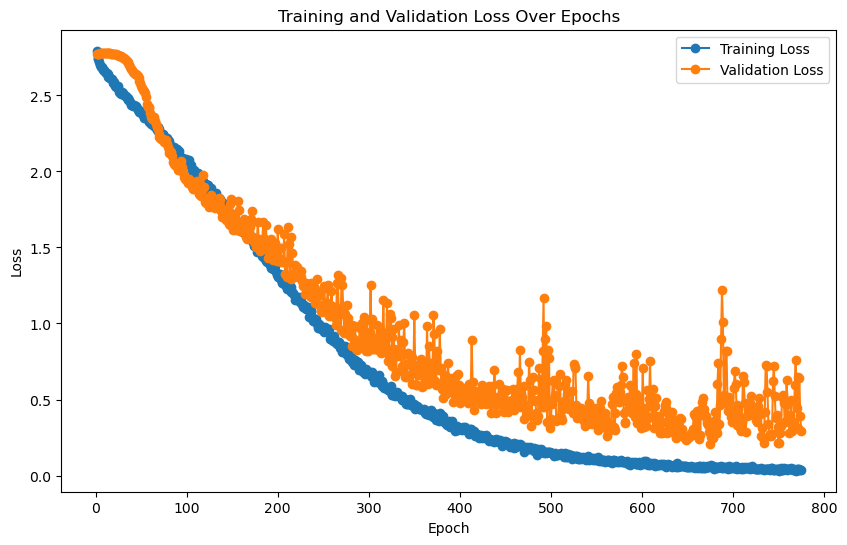

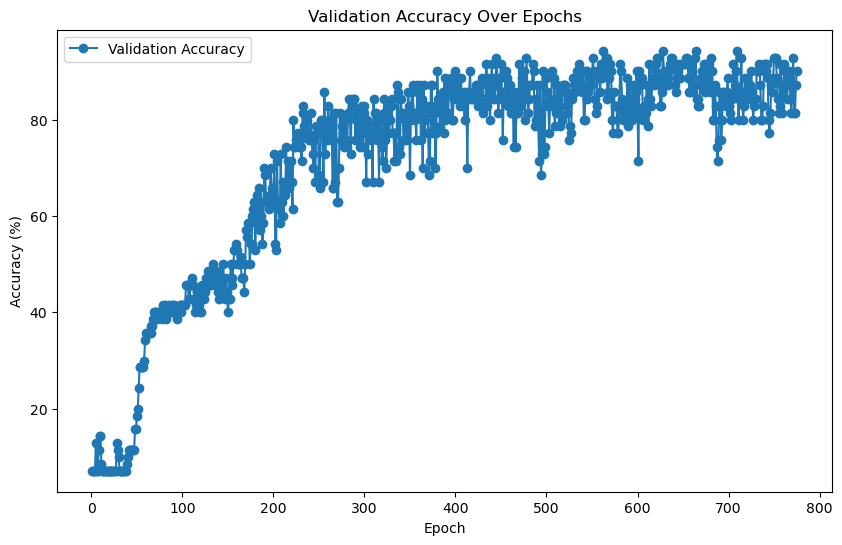


Evaluating on the test set...
    Test Batch [1/38], Loss: 1.1284

Final Test Loss: 0.7250, Test Accuracy: 78.49%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/38 for test dataset.
  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (9571, 64), Test labels shape: (9571,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 62.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         5
           3       0.62      1.00      0.77         5
           4       0.80      0.80      0.80         5
           5       0.56      1.00      0.71         5
           7       1.00      0.60      0.75         5
           9       0.71      1.00      0.83         5
          10       0.40      0.40  

Test Accuracy: 49.13%

Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.48      0.30      0.37      1383
           2       0.27      0.29      0.28       785
           3       0.29      0.67      0.41       192
           4       0.45      0.48      0.47       438
           5       0.70      0.68      0.69       685
           6       0.00      0.00      0.00         0
           7       0.91      0.59      0.71       433
           8       0.00      0.00      0.00         0
           9       0.36      0.51      0.42       927
          10       0.60      0.47      0.53      2410
          11       0.29      0.30      0.30       548
          12       0.54      0.93      0.68       160
          13       0.87      0.76      0.81      1220
          14       0.33      0.32      0.33       341
          15       0.80      1.00      0.89        48

    accuracy                

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packag

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (9571, 64)
Test labels shape: (9571,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7406  |  Val Loss: 2.6746
Validation loss improved from inf to 2.6746.
[Epoch 2/1000] Train Loss: 2.6557  |  Val Loss: 2.5898
Validation loss improved from 2.6746 to 2.5898.
[Epoch 3/1000] Train Loss: 2.5879  |  Val Loss: 2.5019
Validation loss improved from 2.5898 to 2.5019.
[Epoch 4/1000] Train Loss: 2.5218  |  Val Loss: 2.4274
Validation loss improved from 2.5019 to 2.4274.
[Epoch 5/1000] Train Loss: 2.4520  |  Val Loss: 2.3510
Validation loss improved from 2.4274 to 2.3510.
[Epoch 6/1000] Train Loss: 2.3885  |  Val Loss: 2.2883
Validation loss improved from 2.3510 to 2.2883.
[Epoch 7/1000] Train Loss: 2.3206  |  Val Loss: 2.2271
Validation loss improved from 2.2883 to 2.2271.
[Epoch 8/1000] Train Loss: 2.2520  |  Val Loss: 2.1627
Validation loss improved from 2.2271 to 2.1627.
[Epoch 9/1000] Train Loss: 2.1887  |  Val Loss: 2.0949
Validation loss improved from 2.1627 to 2.0949.
[Epoch 10/1000] Train Loss: 2.1220  |  Val Loss: 2.0333
Validation loss impr

[Epoch 12/1000] Train Loss: 1.9933  |  Val Loss: 1.9044
Validation loss improved from 1.9721 to 1.9044.
[Epoch 13/1000] Train Loss: 1.9276  |  Val Loss: 1.8424
Validation loss improved from 1.9044 to 1.8424.
[Epoch 14/1000] Train Loss: 1.8691  |  Val Loss: 1.7897
Validation loss improved from 1.8424 to 1.7897.
[Epoch 15/1000] Train Loss: 1.8044  |  Val Loss: 1.7115
Validation loss improved from 1.7897 to 1.7115.


[Epoch 16/1000] Train Loss: 1.7359  |  Val Loss: 1.6623
Validation loss improved from 1.7115 to 1.6623.
[Epoch 17/1000] Train Loss: 1.6703  |  Val Loss: 1.5941
Validation loss improved from 1.6623 to 1.5941.
[Epoch 18/1000] Train Loss: 1.6089  |  Val Loss: 1.5347
Validation loss improved from 1.5941 to 1.5347.
[Epoch 19/1000] Train Loss: 1.5574  |  Val Loss: 1.4685
Validation loss improved from 1.5347 to 1.4685.


[Epoch 20/1000] Train Loss: 1.5127  |  Val Loss: 1.4286
Validation loss improved from 1.4685 to 1.4286.
[Epoch 21/1000] Train Loss: 1.4542  |  Val Loss: 1.3745
Validation loss improved from 1.4286 to 1.3745.
[Epoch 22/1000] Train Loss: 1.4026  |  Val Loss: 1.3456
Validation loss improved from 1.3745 to 1.3456.
[Epoch 23/1000] Train Loss: 1.3603  |  Val Loss: 1.2994
Validation loss improved from 1.3456 to 1.2994.
[Epoch 24/1000] Train Loss: 1.3218  |  Val Loss: 1.2738
Validation loss improved from 1.2994 to 1.2738.
[Epoch 25/1000] Train Loss: 1.2811  |  Val Loss: 1.2440
Validation loss improved from 1.2738 to 1.2440.
[Epoch 26/1000] Train Loss: 1.2514  |  Val Loss: 1.2202
Validation loss improved from 1.2440 to 1.2202.
[Epoch 27/1000] Train Loss: 1.2238  |  Val Loss: 1.1850
Validation loss improved from 1.2202 to 1.1850.
[Epoch 28/1000] Train Loss: 1.1999  |  Val Loss: 1.1795
Validation loss improved from 1.1850 to 1.1795.


[Epoch 29/1000] Train Loss: 1.1813  |  Val Loss: 1.1428
Validation loss improved from 1.1795 to 1.1428.
[Epoch 30/1000] Train Loss: 1.1503  |  Val Loss: 1.1242
Validation loss improved from 1.1428 to 1.1242.
[Epoch 31/1000] Train Loss: 1.1190  |  Val Loss: 1.0995
Validation loss improved from 1.1242 to 1.0995.
[Epoch 32/1000] Train Loss: 1.0966  |  Val Loss: 1.0974
Validation loss improved from 1.0995 to 1.0974.
[Epoch 33/1000] Train Loss: 1.0764  |  Val Loss: 1.0828
Validation loss improved from 1.0974 to 1.0828.


[Epoch 34/1000] Train Loss: 1.0602  |  Val Loss: 1.0659
Validation loss improved from 1.0828 to 1.0659.
[Epoch 35/1000] Train Loss: 1.0501  |  Val Loss: 1.0493
Validation loss improved from 1.0659 to 1.0493.
[Epoch 36/1000] Train Loss: 1.0349  |  Val Loss: 1.0338
Validation loss improved from 1.0493 to 1.0338.
[Epoch 37/1000] Train Loss: 1.0073  |  Val Loss: 1.0360
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 38/1000] Train Loss: 0.9974  |  Val Loss: 1.0331
Validation loss improved from 1.0338 to 1.0331.
[Epoch 39/1000] Train Loss: 0.9825  |  Val Loss: 1.0101
Validation loss improved from 1.0331 to 1.0101.
[Epoch 40/1000] Train Loss: 0.9661  |  Val Loss: 0.9938
Validation loss improved from 1.0101 to 0.9938.
[Epoch 41/1000] Train Loss: 0.9602  |  Val Loss: 1.0013
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.9437  |  Val Loss: 0.9858
Validation loss improved from 0.9938 to 0.9858.
[Epoch 43/1000] Train Loss: 0.9474  |  Val Loss: 0.9679
Validation loss improved from 0.9858 to 0.9679.
[Epoch 44/1000] Train Loss: 0.9226  |  Val Loss: 0.9939
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.9024  |  Val Loss: 0.9558
Validation loss improved from 0.9679 to 0.9558.
[Epoch 46/1000] Train Loss: 0.8920  |  Val Loss: 0.9507
Validation loss improved from 0.9558 to 0.9507.
[Epoch 47/1000] Train Loss: 0.8842  |  Val Loss: 0.9

[Epoch 48/1000] Train Loss: 0.8783  |  Val Loss: 0.9481
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.8681  |  Val Loss: 0.9492
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 0.8591  |  Val Loss: 0.9363
Validation loss improved from 0.9450 to 0.9363.
[Epoch 51/1000] Train Loss: 0.8712  |  Val Loss: 0.9292
Validation loss improved from 0.9363 to 0.9292.
[Epoch 52/1000] Train Loss: 0.8398  |  Val Loss: 0.9385
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.8421  |  Val Loss: 0.9419
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 54/1000] Train Loss: 0.8196  |  Val Loss: 0.9283
Validation loss improved from 0.9292 to 0.9283.
[Epoch 55/1000] Train Loss: 0.8123  |  Val Loss: 0.9230
Validation loss improved from 0.9283 to 0.9230.
[Epoch 56/1000] Train Loss: 0.8057  |  Val Loss: 0.9024
Validation loss improved from 0.9230 to 0.9024.
[Epoch 57/1000] Train Loss: 0.7888  |  Val Loss: 0.9076
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 58/1000] Train Loss: 0.7980  |  Val Loss: 0.9072
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 59/1000] Train Loss: 0.7762  |  Val Loss: 0.8873
Validation loss improved from 0.9024 to 0.8873.
[Epoch 60/1000] Train Loss: 0.7722  |  Val Loss: 0.8765
Validation loss improved from 0.8873 to 0.8765.
[Epoch 61/1000] Train Loss: 0.7683  |  Val Loss: 0.8882
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.7482  |  Val Loss: 0.8617
Validation loss improved from 0.8765 to 0.8617.
[Epoch 63/1000] Train Loss: 0.7508  |  Val Loss: 0.8812
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 0.7443  |  Val Loss: 0.8529
Validation loss improved from 0.8617 to 0.8529.
[Epoch 65/1000] Train Loss: 0.7379  |  Val Loss: 0.8620
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 0.7240  |  Val Loss: 0.8548
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 67/1000] Train Loss: 0.7225

[Epoch 68/1000] Train Loss: 0.7178  |  Val Loss: 0.8733
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.7090  |  Val Loss: 0.8419
Validation loss improved from 0.8513 to 0.8419.
[Epoch 70/1000] Train Loss: 0.7128  |  Val Loss: 0.8398
Validation loss improved from 0.8419 to 0.8398.
[Epoch 71/1000] Train Loss: 0.6968  |  Val Loss: 0.8576
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 0.6881  |  Val Loss: 0.8298
Validation loss improved from 0.8398 to 0.8298.


[Epoch 73/1000] Train Loss: 0.6877  |  Val Loss: 0.8231
Validation loss improved from 0.8298 to 0.8231.
[Epoch 74/1000] Train Loss: 0.6819  |  Val Loss: 0.8429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 75/1000] Train Loss: 0.6764  |  Val Loss: 0.8299
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 76/1000] Train Loss: 0.6651  |  Val Loss: 0.8243
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 0.6671  |  Val Loss: 0.8095
Validation loss improved from 0.8231 to 0.8095.
[Epoch 78/1000] Train Loss: 0.6649  |  Val Loss: 0.8172
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.6710  |  Val Loss: 0.8319
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 0.6769  |  Val Loss: 0.8175
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 81/1000] Train Loss: 0.6696  |  Val Loss: 0.8103
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 82/1000] Train Loss: 0.6569  |  Val Loss: 0.8441
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 83/1000] Train Loss: 0.6492  |  Val Loss: 0.8105
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 84/1000] Train Loss: 0.6361  |  Val Loss: 0.7869
Validation loss improved from 0.8095 to 0.7869.
[Epoch 85/1000] Train 

[Epoch 87/1000] Train Loss: 0.6162  |  Val Loss: 0.7782
Validation loss improved from 0.7869 to 0.7782.
[Epoch 88/1000] Train Loss: 0.6081  |  Val Loss: 0.7700
Validation loss improved from 0.7782 to 0.7700.
[Epoch 89/1000] Train Loss: 0.6122  |  Val Loss: 0.7892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 90/1000] Train Loss: 0.6082  |  Val Loss: 0.7828
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 91/1000] Train Loss: 0.5947  |  Val Loss: 0.7795
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 0.6000  |  Val Loss: 0.7814
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 93/1000] Train Loss: 0.6035  |  Val Loss: 0.7760
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 94/1000] Train Loss: 0.5890  |  Val Loss: 0.7911
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 95/1000] Train Loss: 0.5956  |  Val Loss: 0.7978
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 96/1000] Train Loss: 0.5932  |  Val Loss: 0.7797
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 97/1000] Train Loss: 0.5894  |  Val Loss: 0.7743
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 98/1000] Train Loss: 0.5829  |  Val Loss: 0.7731
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 99/1000] Train Loss: 0.5744  |  Val Loss: 0.7559
Validation loss improved from 0.7700 to 0.7559.
[Epoch 100/1000] Train Loss: 0.5720  |  Val Loss: 0.7596
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 101/1000] Train Loss: 0.5543  |  Val Loss: 0.7530
Validation loss improved from 0.7559 to 0.7530.
[Epoch 102/1000] Train Loss: 0.5541  |  Val Loss: 0.7626
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] T

[Epoch 108/1000] Train Loss: 0.5414  |  Val Loss: 0.7405
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 109/1000] Train Loss: 0.5314  |  Val Loss: 0.7597
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 110/1000] Train Loss: 0.5228  |  Val Loss: 0.7401
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 111/1000] Train Loss: 0.5220  |  Val Loss: 0.7433
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 112/1000] Train Loss: 0.5169  |  Val Loss: 0.7427
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 113/1000] Train Loss: 0.5043  |  Val Loss: 0.7271
Validation loss improved from 0.7365 to 0.7271.
[Epoch 114/1000] Train Loss: 0.5026  |  Val Loss: 0.7377
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 115/1000] Train Loss: 0.4995  |  Val Loss: 0.7335
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 116/1000] Train Loss: 0.5100  |  Val Loss: 0.7366
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 117/1000] Train Loss: 0.5030  |  Val Loss: 0.7391
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 118/1000] Train Loss: 0.5010  |  Val Loss: 0.7443
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 119/1000] Train Loss: 0.5050  |  Val Loss: 0.7291
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 120/1000] Train Loss: 0.4917  |  Val Loss: 0.7334
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 127/1000] Train Loss: 0.4560  |  Val Loss: 0.7102
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 0.4657  |  Val Loss: 0.7434
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 0.4588  |  Val Loss: 0.7202
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 0.4582  |  Val Loss: 0.7002
Validation loss improved from 0.7055 to 0.7002.


[Epoch 131/1000] Train Loss: 0.4614  |  Val Loss: 0.7265
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 0.4618  |  Val Loss: 0.7257
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 0.4529  |  Val Loss: 0.7234
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 0.4512  |  Val Loss: 0.7118
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 135/1000] Train Loss: 0.4349  |  Val Loss: 0.7289
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 136/1000] Train Loss: 0.4293  |  Val Loss: 0.7254
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 137/1000] Train Loss: 0.4282  |  Val Loss: 0.7162
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 138/1000] Train Loss: 0.4191  |  Val Loss: 0.7142
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 139/1000] Train Loss: 0.4242  |  Val Loss: 0.6966
Validation loss improved from 0.7002 to 0.6966.
[Epoch 

[Epoch 145/1000] Train Loss: 0.4011  |  Val Loss: 0.7155
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 146/1000] Train Loss: 0.3913  |  Val Loss: 0.7155
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 147/1000] Train Loss: 0.3889  |  Val Loss: 0.7103
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 148/1000] Train Loss: 0.3926  |  Val Loss: 0.7160
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 149/1000] Train Loss: 0.3989  |  Val Loss: 0.7185
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 150/1000] Train Loss: 0.3798  |  Val Loss: 0.7053
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 151/1000] Train Loss: 0.3923  |  Val Loss: 0.7089
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 152/1000] Train Loss: 0.3917  |  Val Loss: 0.7260
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 153/1000] Train Loss: 0.3784  |  Val Loss: 0.7020
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 154/1000] Train Loss: 0.3958  |  Val Loss: 0.7192
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 155/1000] Train Loss: 0.3810  |  Val Loss: 0.7117
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 156/1000] Train Loss: 0.3860  |  Val Loss: 0.7075
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 157/1000] Train Loss: 0.3856  |  Val Loss: 0.7142
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 158/1000] Train Loss: 0.3795  |  Val Loss: 0.7089
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 159/1000] Train Loss: 0.3766  |  Val Loss: 0.7123
!! Validation loss did NOT improve !! Patience:

[Epoch 165/1000] Train Loss: 0.3633  |  Val Loss: 0.7265
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 166/1000] Train Loss: 0.3582  |  Val Loss: 0.6971
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 167/1000] Train Loss: 0.3460  |  Val Loss: 0.7233
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 168/1000] Train Loss: 0.3494  |  Val Loss: 0.7492
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 169/1000] Train Loss: 0.3493  |  Val Loss: 0.6837
Validation loss improved from 0.6966 to 0.6837.


[Epoch 170/1000] Train Loss: 0.3517  |  Val Loss: 0.7212
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 0.3484  |  Val Loss: 0.7214
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 0.3384  |  Val Loss: 0.7255
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 173/1000] Train Loss: 0.3333  |  Val Loss: 0.7050
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 174/1000] Train Loss: 0.3377  |  Val Loss: 0.7373
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 175/1000] Train Loss: 0.3259  |  Val Loss: 0.6981
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 176/1000] Train Loss: 0.3332  |  Val Loss: 0.7193
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 177/1000] Train Loss: 0.3306  |  Val Loss: 0.7394
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 178/1000] Train Loss: 0.3413  |  Val Loss: 0.7434
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 183/1000] Train Loss: 0.3237  |  Val Loss: 0.7392
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 184/1000] Train Loss: 0.3220  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 185/1000] Train Loss: 0.3144  |  Val Loss: 0.7195
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 186/1000] Train Loss: 0.3012  |  Val Loss: 0.7187
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 187/1000] Train Loss: 0.3027  |  Val Loss: 0.7296
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 188/1000] Train Loss: 0.3074  |  Val Loss: 0.7273
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 189/1000] Train Loss: 0.3076  |  Val Loss: 0.7692
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 190/1000] Train Loss: 0.2989  |  Val Loss: 0.7139
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 191/1000] Train Loss: 0.3247  |  Val Loss: 0.7313
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 192/1000] Train Loss: 0.3226  |  Val Loss: 0.7844
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 193/1000] Train Loss: 0.3118  |  Val Loss: 0.7294
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 194/1000] Train Loss: 0.3119  |  Val Loss: 0.7477
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 195/1000] Train Loss: 0.3053  |  Val Loss: 0.7399
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 196/1000] Train Loss: 0.2958  |  Val Loss: 0.7341
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 197/1000] Train Loss: 0.2831  |  Val Loss: 0.7518
!! Validation loss did NOT improve !! Patience:

[Epoch 203/1000] Train Loss: 0.2755  |  Val Loss: 0.7276
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 204/1000] Train Loss: 0.3097  |  Val Loss: 0.7530
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 205/1000] Train Loss: 0.3067  |  Val Loss: 0.7500
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 206/1000] Train Loss: 0.2972  |  Val Loss: 0.7419
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 207/1000] Train Loss: 0.2879  |  Val Loss: 0.7806
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 208/1000] Train Loss: 0.2740  |  Val Loss: 0.7695
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 209/1000] Train Loss: 0.2708  |  Val Loss: 0.7728
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 210/1000] Train Loss: 0.2760  |  Val Loss: 0.7507
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 211/1000] Train Loss: 0.2659  |  Val Loss: 0.7754
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 212/1000] Train Loss: 0.2616  |  Val Loss: 0.7599
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 213/1000] Train Loss: 0.2599  |  Val Loss: 0.7542
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 214/1000] Train Loss: 0.2583  |  Val Loss: 0.7367
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 215/1000] Train Loss: 0.2522  |  Val Loss: 0.7657
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 216/1000] Train Loss: 0.2564  |  Val Loss: 0.7622
!! Validation loss did NOT improve !! Patience:

[Epoch 222/1000] Train Loss: 0.2529  |  Val Loss: 0.7593
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 223/1000] Train Loss: 0.2641  |  Val Loss: 0.7742
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 224/1000] Train Loss: 0.2562  |  Val Loss: 0.7692
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 225/1000] Train Loss: 0.2452  |  Val Loss: 0.7690
!! Validation loss did NOT improve !! Patience: 56/100


[Epoch 226/1000] Train Loss: 0.2340  |  Val Loss: 0.7620
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 227/1000] Train Loss: 0.2411  |  Val Loss: 0.7660
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 228/1000] Train Loss: 0.2399  |  Val Loss: 0.7858
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 229/1000] Train Loss: 0.2410  |  Val Loss: 0.7534
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 230/1000] Train Loss: 0.2349  |  Val Loss: 0.7806
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 231/1000] Train Loss: 0.2335  |  Val Loss: 0.7848
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 232/1000] Train Loss: 0.2324  |  Val Loss: 0.7612
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 233/1000] Train Loss: 0.2330  |  Val Loss: 0.7876
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 234/1000] Train Loss: 0.2256  |  Val Loss: 0.7618
!! Validation loss did NOT improve !! Patience:

[Epoch 240/1000] Train Loss: 0.2285  |  Val Loss: 0.8029
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 241/1000] Train Loss: 0.2243  |  Val Loss: 0.7911
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 242/1000] Train Loss: 0.2216  |  Val Loss: 0.7763
!! Validation loss did NOT improve !! Patience: 73/100


[Epoch 243/1000] Train Loss: 0.2207  |  Val Loss: 0.8155
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 244/1000] Train Loss: 0.2230  |  Val Loss: 0.7733
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 245/1000] Train Loss: 0.2171  |  Val Loss: 0.7833
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 246/1000] Train Loss: 0.2132  |  Val Loss: 0.8038
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 247/1000] Train Loss: 0.2214  |  Val Loss: 0.8034
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 248/1000] Train Loss: 0.2125  |  Val Loss: 0.8018
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 249/1000] Train Loss: 0.2152  |  Val Loss: 0.7908
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 250/1000] Train Loss: 0.2189  |  Val Loss: 0.8016
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 251/1000] Train Loss: 0.2081  |  Val Loss: 0.8099
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.1999  |  Val Loss: 0.8213
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 258/1000] Train Loss: 0.2068  |  Val Loss: 0.8259
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 259/1000] Train Loss: 0.2057  |  Val Loss: 0.8146
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 260/1000] Train Loss: 0.1917  |  Val Loss: 0.8112
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 261/1000] Train Loss: 0.1908  |  Val Loss: 0.8168
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 262/1000] Train Loss: 0.1981  |  Val Loss: 0.8102
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 263/1000] Train Loss: 0.2011  |  Val Loss: 0.8233
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 264/1000] Train Loss: 0.1913  |  Val Loss: 0.8175
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 265/1000] Train Loss: 0.2157  |  Val Loss: 0.8034
!! Validation loss did NOT improve !! Patience:

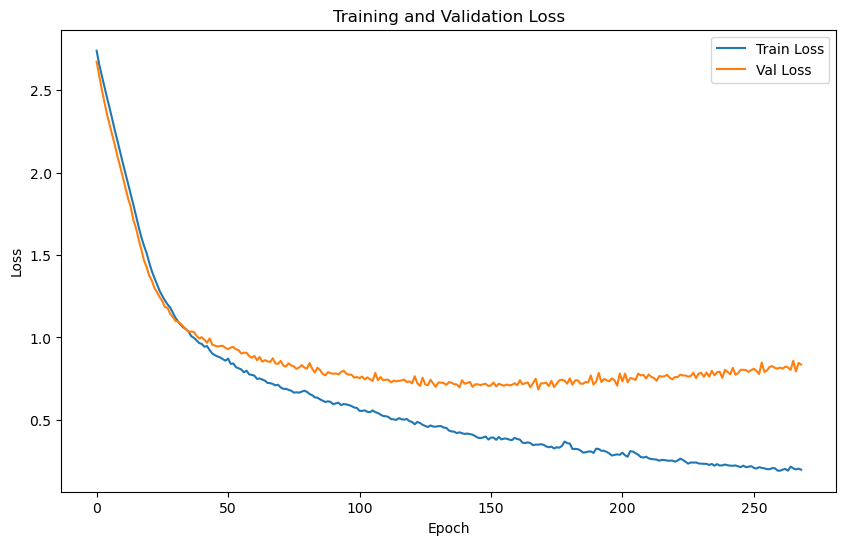

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.3592 | Test Accuracy: 48.38%


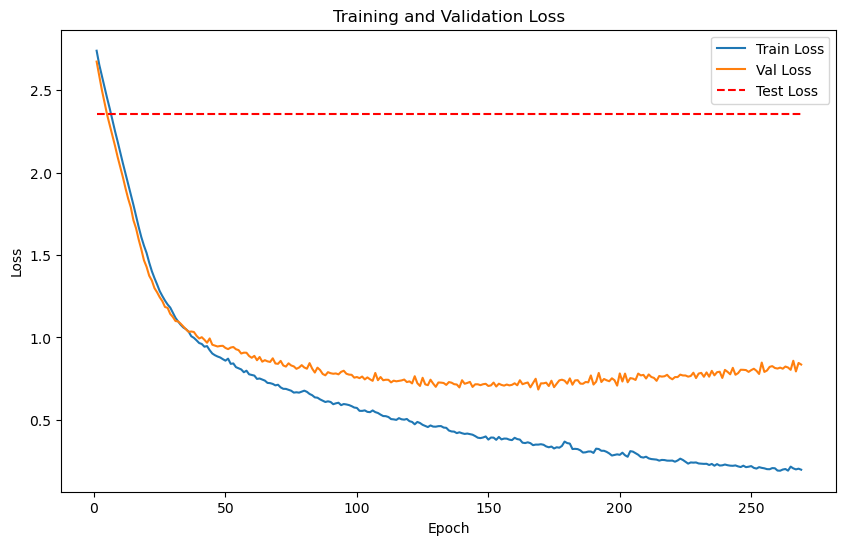

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.9500
Epoch [1/2000], Avg Train Loss: 8.9500
Epoch [1/2000], Avg Val Loss: 4.4624
Validation loss improved from inf to 4.4624. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.7999
Epoch [2/2000], Avg Train Loss: 8.7999
Epoch [2/2000], Avg Val Loss: 4.4177
Validation loss improved from 4.4624 to 4.4177. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.8351
Epoch [3/2000], Avg Train Loss: 8.8351
Epoch [3/2000], Avg Val Loss: 4.3740
Validation loss improved from 4.4177 to 4.3740. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7510
Epoch [4/2000], Avg Train Loss: 8.7510
Epoch [4/2000], Avg Val Loss: 4.3318
Validation loss improved from 4.3740 to 4.3318. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6011
Epoch [5/2000], Avg Train Loss: 8.6011
Epoch [5/2000], Avg Val Loss: 4.2908
Validation loss improved from 4.3318 to 4.2908. Saving mode

Epoch [13/2000], Avg Val Loss: 4.0069
Validation loss improved from 4.0382 to 4.0069. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 7.9935
Epoch [14/2000], Avg Train Loss: 7.9935
Epoch [14/2000], Avg Val Loss: 3.9767
Validation loss improved from 4.0069 to 3.9767. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.9932
Epoch [15/2000], Avg Train Loss: 7.9932
Epoch [15/2000], Avg Val Loss: 3.9476
Validation loss improved from 3.9767 to 3.9476. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.8930
Epoch [16/2000], Avg Train Loss: 7.8930
Epoch [16/2000], Avg Val Loss: 3.9197
Validation loss improved from 3.9476 to 3.9197. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.7139
Epoch [17/2000], Avg Train Loss: 7.7139
Epoch [17/2000], Avg Val Loss: 3.8928
Validation loss improved from 3.9197 to 3.8928. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.7532
Epoch [19/2000], Avg Train Loss: 7.7532
Epoch [19/2000], Avg Val Loss: 3.8421
Validation loss improved from 3.8670 to 3.8421. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 7.5756
Epoch [20/2000], Avg Train Loss: 7.5756
Epoch [20/2000], Avg Val Loss: 3.8182
Validation loss improved from 3.8421 to 3.8182. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.5471
Epoch [21/2000], Avg Train Loss: 7.5471
Epoch [21/2000], Avg Val Loss: 3.7953
Validation loss improved from 3.8182 to 3.7953. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.4651
Epoch [22/2000], Avg Train Loss: 7.4651
Epoch [22/2000], Avg Val Loss: 3.7733
Validation loss improved from 3.7953 to 3.7733. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.4795
Epoch [23/2000], Avg Train Loss: 7.4795
Epoch [23/2000], Avg Val Loss: 3.7522
Validation loss improved from 3.7733 to 3.

    Batch [1/1], Train Loss: 7.2722
Epoch [27/2000], Avg Train Loss: 7.2722
Epoch [27/2000], Avg Val Loss: 3.6764
Validation loss improved from 3.6941 to 3.6764. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 7.1212
Epoch [28/2000], Avg Train Loss: 7.1212
Epoch [28/2000], Avg Val Loss: 3.6595
Validation loss improved from 3.6764 to 3.6595. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 7.0536
Epoch [29/2000], Avg Train Loss: 7.0536
Epoch [29/2000], Avg Val Loss: 3.6433
Validation loss improved from 3.6595 to 3.6433. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.9897
Epoch [30/2000], Avg Train Loss: 6.9897
Epoch [30/2000], Avg Val Loss: 3.6278
Validation loss improved from 3.6433 to 3.6278. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 6.9806
Epoch [31/2000], Avg Train Loss: 6.9806
Epoch [31/2000], Avg Val Loss: 3.6131
Validation loss improved from 3.6278 to 3.

    Batch [1/1], Train Loss: 6.5844
Epoch [39/2000], Avg Train Loss: 6.5844
Epoch [39/2000], Avg Val Loss: 3.5175
Validation loss improved from 3.5275 to 3.5175. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.5862
Epoch [40/2000], Avg Train Loss: 6.5862
Epoch [40/2000], Avg Val Loss: 3.5079
Validation loss improved from 3.5175 to 3.5079. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.4844
Epoch [41/2000], Avg Train Loss: 6.4844
Epoch [41/2000], Avg Val Loss: 3.4988
Validation loss improved from 3.5079 to 3.4988. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 6.4734
Epoch [42/2000], Avg Train Loss: 6.4734
Epoch [42/2000], Avg Val Loss: 3.4903
Validation loss improved from 3.4988 to 3.4903. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 6.4578
Epoch [43/2000], Avg Train Loss: 6.4578
Epoch [43/2000], Avg Val Loss: 3.4821
Validation loss improved from 3.4903 to 3.

Epoch [49/2000], Avg Val Loss: 3.4412
Validation loss improved from 3.4471 to 3.4412. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.2061
Epoch [50/2000], Avg Train Loss: 6.2061
Epoch [50/2000], Avg Val Loss: 3.4356
Validation loss improved from 3.4412 to 3.4356. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.2805
Epoch [51/2000], Avg Train Loss: 6.2805
Epoch [51/2000], Avg Val Loss: 3.4302
Validation loss improved from 3.4356 to 3.4302. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.1898
Epoch [52/2000], Avg Train Loss: 6.1898
Epoch [52/2000], Avg Val Loss: 3.4252
Validation loss improved from 3.4302 to 3.4252. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.2070
Epoch [53/2000], Avg Train Loss: 6.2070
Epoch [53/2000], Avg Val Loss: 3.4203
Validation loss improved from 3.4252 to 3.4203. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.9187
Epoch [62/2000], Avg Train Loss: 5.9187
Epoch [62/2000], Avg Val Loss: 3.3869
Validation loss improved from 3.3900 to 3.3869. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.9188
Epoch [63/2000], Avg Train Loss: 5.9188
Epoch [63/2000], Avg Val Loss: 3.3839
Validation loss improved from 3.3869 to 3.3839. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.8645
Epoch [64/2000], Avg Train Loss: 5.8645
Epoch [64/2000], Avg Val Loss: 3.3811
Validation loss improved from 3.3839 to 3.3811. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.8942
Epoch [65/2000], Avg Train Loss: 5.8942
Epoch [65/2000], Avg Val Loss: 3.3784
Validation loss improved from 3.3811 to 3.3784. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.9507
Epoch [66/2000], Avg Train Loss: 5.9507
Epoch [66/2000], Avg Val Loss: 3.3758
Validation loss improved from 3.3784 to 3.

Epoch [75/2000], Avg Val Loss: 3.3566
Validation loss improved from 3.3585 to 3.3566. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.7779
Epoch [76/2000], Avg Train Loss: 5.7779
Epoch [76/2000], Avg Val Loss: 3.3548
Validation loss improved from 3.3566 to 3.3548. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.7384
Epoch [77/2000], Avg Train Loss: 5.7384
Epoch [77/2000], Avg Val Loss: 3.3531
Validation loss improved from 3.3548 to 3.3531. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.7468
Epoch [78/2000], Avg Train Loss: 5.7468
Epoch [78/2000], Avg Val Loss: 3.3514
Validation loss improved from 3.3531 to 3.3514. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.6744
Epoch [79/2000], Avg Train Loss: 5.6744
Epoch [79/2000], Avg Val Loss: 3.3498
Validation loss improved from 3.3514 to 3.3498. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Trai

Epoch [86/2000], Avg Val Loss: 3.3393
Validation loss improved from 3.3407 to 3.3393. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.6133
Epoch [87/2000], Avg Train Loss: 5.6133
Epoch [87/2000], Avg Val Loss: 3.3379
Validation loss improved from 3.3393 to 3.3379. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.5686
Epoch [88/2000], Avg Train Loss: 5.5686
Epoch [88/2000], Avg Val Loss: 3.3365
Validation loss improved from 3.3379 to 3.3365. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.5958
Epoch [89/2000], Avg Train Loss: 5.5958
Epoch [89/2000], Avg Val Loss: 3.3351
Validation loss improved from 3.3365 to 3.3351. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.6194
Epoch [90/2000], Avg Train Loss: 5.6194
Epoch [90/2000], Avg Val Loss: 3.3338
Validation loss improved from 3.3351 to 3.3338. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5185
Epoch [99/2000], Avg Train Loss: 5.5185
Epoch [99/2000], Avg Val Loss: 3.3226
Validation loss improved from 3.3238 to 3.3226. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 5.4994
Epoch [100/2000], Avg Train Loss: 5.4994
Epoch [100/2000], Avg Val Loss: 3.3214
Validation loss improved from 3.3226 to 3.3214. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 5.5466
Epoch [101/2000], Avg Train Loss: 5.5466
Epoch [101/2000], Avg Val Loss: 3.3202
Validation loss improved from 3.3214 to 3.3202. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 5.5148
Epoch [102/2000], Avg Train Loss: 5.5148
Epoch [102/2000], Avg Val Loss: 3.3189
Validation loss improved from 3.3202 to 3.3189. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 5.5134
Epoch [103/2000], Avg Train Loss: 5.5134
Epoch [103/2000], Avg Val Loss: 3.3177
Validation loss improved from 

    Batch [1/1], Train Loss: 5.4538
Epoch [109/2000], Avg Train Loss: 5.4538
Epoch [109/2000], Avg Val Loss: 3.3107
Validation loss improved from 3.3118 to 3.3107. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.4945
Epoch [110/2000], Avg Train Loss: 5.4945
Epoch [110/2000], Avg Val Loss: 3.3096
Validation loss improved from 3.3107 to 3.3096. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.4792
Epoch [111/2000], Avg Train Loss: 5.4792
Epoch [111/2000], Avg Val Loss: 3.3085
Validation loss improved from 3.3096 to 3.3085. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.4323
Epoch [112/2000], Avg Train Loss: 5.4323
Epoch [112/2000], Avg Val Loss: 3.3074
Validation loss improved from 3.3085 to 3.3074. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.4419
Epoch [113/2000], Avg Train Loss: 5.4419
Epoch [113/2000], Avg Val Loss: 3.3063
Validation loss improved fro

    Batch [1/1], Train Loss: 5.4000
Epoch [122/2000], Avg Train Loss: 5.4000
Epoch [122/2000], Avg Val Loss: 3.2965
Validation loss improved from 3.2976 to 3.2965. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 5.3954
Epoch [123/2000], Avg Train Loss: 5.3954
Epoch [123/2000], Avg Val Loss: 3.2954
Validation loss improved from 3.2965 to 3.2954. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 5.3759
Epoch [124/2000], Avg Train Loss: 5.3759
Epoch [124/2000], Avg Val Loss: 3.2943
Validation loss improved from 3.2954 to 3.2943. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 5.4137
Epoch [125/2000], Avg Train Loss: 5.4137
Epoch [125/2000], Avg Val Loss: 3.2932
Validation loss improved from 3.2943 to 3.2932. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.3468
Epoch [126/2000], Avg Train Loss: 5.3468
Epoch [126/2000], Avg Val Loss: 3.2922
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3066
Epoch [135/2000], Avg Train Loss: 5.3066
Epoch [135/2000], Avg Val Loss: 3.2830
Validation loss improved from 3.2841 to 3.2830. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 5.3089
Epoch [136/2000], Avg Train Loss: 5.3089
Epoch [136/2000], Avg Val Loss: 3.2820
Validation loss improved from 3.2830 to 3.2820. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 5.3448
Epoch [137/2000], Avg Train Loss: 5.3448
Epoch [137/2000], Avg Val Loss: 3.2809
Validation loss improved from 3.2820 to 3.2809. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 5.3016
Epoch [138/2000], Avg Train Loss: 5.3016
Epoch [138/2000], Avg Val Loss: 3.2799
Validation loss improved from 3.2809 to 3.2799. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 5.3544
Epoch [139/2000], Avg Train Loss: 5.3544
Epoch [139/2000], Avg Val Loss: 3.2788
Validation loss improved fro

Epoch [149/2000], Avg Val Loss: 3.2682
Validation loss improved from 3.2692 to 3.2682. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 5.2433
Epoch [150/2000], Avg Train Loss: 5.2433
Epoch [150/2000], Avg Val Loss: 3.2671
Validation loss improved from 3.2682 to 3.2671. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 5.2677
Epoch [151/2000], Avg Train Loss: 5.2677
Epoch [151/2000], Avg Val Loss: 3.2660
Validation loss improved from 3.2671 to 3.2660. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 5.2494
Epoch [152/2000], Avg Train Loss: 5.2494
Epoch [152/2000], Avg Val Loss: 3.2649
Validation loss improved from 3.2660 to 3.2649. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 5.2517
Epoch [153/2000], Avg Train Loss: 5.2517
Epoch [153/2000], Avg Val Loss: 3.2638
Validation loss improved from 3.2649 to 3.2638. Saving model...

LOG: Epoch [154/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.2288
Epoch [161/2000], Avg Train Loss: 5.2288
Epoch [161/2000], Avg Val Loss: 3.2553
Validation loss improved from 3.2564 to 3.2553. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 5.2408
Epoch [162/2000], Avg Train Loss: 5.2408
Epoch [162/2000], Avg Val Loss: 3.2543
Validation loss improved from 3.2553 to 3.2543. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 5.2730
Epoch [163/2000], Avg Train Loss: 5.2730
Epoch [163/2000], Avg Val Loss: 3.2533
Validation loss improved from 3.2543 to 3.2533. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 5.2187
Epoch [164/2000], Avg Train Loss: 5.2187
Epoch [164/2000], Avg Val Loss: 3.2523
Validation loss improved from 3.2533 to 3.2523. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 5.2501
Epoch [165/2000], Avg Train Loss: 5.2501
Epoch [165/2000], Avg Val Loss: 3.2513
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1919
Epoch [171/2000], Avg Train Loss: 5.1919
Epoch [171/2000], Avg Val Loss: 3.2451
Validation loss improved from 3.2461 to 3.2451. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 5.1892
Epoch [172/2000], Avg Train Loss: 5.1892
Epoch [172/2000], Avg Val Loss: 3.2440
Validation loss improved from 3.2451 to 3.2440. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 5.2001
Epoch [173/2000], Avg Train Loss: 5.2001
Epoch [173/2000], Avg Val Loss: 3.2430
Validation loss improved from 3.2440 to 3.2430. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 5.1941
Epoch [174/2000], Avg Train Loss: 5.1941
Epoch [174/2000], Avg Val Loss: 3.2420
Validation loss improved from 3.2430 to 3.2420. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 5.2000
Epoch [175/2000], Avg Train Loss: 5.2000
Epoch [175/2000], Avg Val Loss: 3.2410
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1344
Epoch [186/2000], Avg Train Loss: 5.1344
Epoch [186/2000], Avg Val Loss: 3.2302
Validation loss improved from 3.2311 to 3.2302. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 5.1587
Epoch [187/2000], Avg Train Loss: 5.1587
Epoch [187/2000], Avg Val Loss: 3.2292
Validation loss improved from 3.2302 to 3.2292. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 5.1888
Epoch [188/2000], Avg Train Loss: 5.1888
Epoch [188/2000], Avg Val Loss: 3.2282
Validation loss improved from 3.2292 to 3.2282. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 5.1716
Epoch [189/2000], Avg Train Loss: 5.1716
Epoch [189/2000], Avg Val Loss: 3.2273
Validation loss improved from 3.2282 to 3.2273. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 5.1399
Epoch [190/2000], Avg Train Loss: 5.1399
Epoch [190/2000], Avg Val Loss: 3.2263
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1676
Epoch [196/2000], Avg Train Loss: 5.1676
Epoch [196/2000], Avg Val Loss: 3.2206
Validation loss improved from 3.2216 to 3.2206. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 5.1521
Epoch [197/2000], Avg Train Loss: 5.1521
Epoch [197/2000], Avg Val Loss: 3.2197
Validation loss improved from 3.2206 to 3.2197. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 5.1340
Epoch [198/2000], Avg Train Loss: 5.1340
Epoch [198/2000], Avg Val Loss: 3.2188
Validation loss improved from 3.2197 to 3.2188. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 5.1384
Epoch [199/2000], Avg Train Loss: 5.1384
Epoch [199/2000], Avg Val Loss: 3.2178
Validation loss improved from 3.2188 to 3.2178. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 5.1013
Epoch [200/2000], Avg Train Loss: 5.1013
Epoch [200/2000], Avg Val Loss: 3.2169
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1591
Epoch [206/2000], Avg Train Loss: 5.1591
Epoch [206/2000], Avg Val Loss: 3.2114
Validation loss improved from 3.2123 to 3.2114. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 5.1194
Epoch [207/2000], Avg Train Loss: 5.1194
Epoch [207/2000], Avg Val Loss: 3.2105
Validation loss improved from 3.2114 to 3.2105. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 5.1386
Epoch [208/2000], Avg Train Loss: 5.1386
Epoch [208/2000], Avg Val Loss: 3.2096
Validation loss improved from 3.2105 to 3.2096. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 5.1219
Epoch [209/2000], Avg Train Loss: 5.1219
Epoch [209/2000], Avg Val Loss: 3.2087
Validation loss improved from 3.2096 to 3.2087. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 5.1271
Epoch [210/2000], Avg Train Loss: 5.1271
Epoch [210/2000], Avg Val Loss: 3.2079
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0945
Epoch [223/2000], Avg Train Loss: 5.0945
Epoch [223/2000], Avg Val Loss: 3.1962
Validation loss improved from 3.1971 to 3.1962. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 5.0877
Epoch [224/2000], Avg Train Loss: 5.0877
Epoch [224/2000], Avg Val Loss: 3.1953
Validation loss improved from 3.1962 to 3.1953. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 5.0664
Epoch [225/2000], Avg Train Loss: 5.0664
Epoch [225/2000], Avg Val Loss: 3.1945
Validation loss improved from 3.1953 to 3.1945. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 5.0881
Epoch [226/2000], Avg Train Loss: 5.0881
Epoch [226/2000], Avg Val Loss: 3.1936
Validation loss improved from 3.1945 to 3.1936. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 5.0498
Epoch [227/2000], Avg Train Loss: 5.0498
Epoch [227/2000], Avg Val Loss: 3.1928
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0597
Epoch [233/2000], Avg Train Loss: 5.0597
Epoch [233/2000], Avg Val Loss: 3.1877
Validation loss improved from 3.1885 to 3.1877. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 5.0682
Epoch [234/2000], Avg Train Loss: 5.0682
Epoch [234/2000], Avg Val Loss: 3.1869
Validation loss improved from 3.1877 to 3.1869. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 5.0699
Epoch [235/2000], Avg Train Loss: 5.0699
Epoch [235/2000], Avg Val Loss: 3.1861
Validation loss improved from 3.1869 to 3.1861. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 5.0766
Epoch [236/2000], Avg Train Loss: 5.0766
Epoch [236/2000], Avg Val Loss: 3.1853
Validation loss improved from 3.1861 to 3.1853. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.9861
Epoch [237/2000], Avg Train Loss: 4.9861
Epoch [237/2000], Avg Val Loss: 3.1845
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0248
Epoch [241/2000], Avg Train Loss: 5.0248
Epoch [241/2000], Avg Val Loss: 3.1812
Validation loss improved from 3.1820 to 3.1812. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 5.0603
Epoch [242/2000], Avg Train Loss: 5.0603
Epoch [242/2000], Avg Val Loss: 3.1803
Validation loss improved from 3.1812 to 3.1803. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 5.0343
Epoch [243/2000], Avg Train Loss: 5.0343
Epoch [243/2000], Avg Val Loss: 3.1795
Validation loss improved from 3.1803 to 3.1795. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 5.0560
Epoch [244/2000], Avg Train Loss: 5.0560
Epoch [244/2000], Avg Val Loss: 3.1786
Validation loss improved from 3.1795 to 3.1786. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 5.0468
Epoch [245/2000], Avg Train Loss: 5.0468
Epoch [245/2000], Avg Val Loss: 3.1778
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0004
Epoch [259/2000], Avg Train Loss: 5.0004
Epoch [259/2000], Avg Val Loss: 3.1666
Validation loss improved from 3.1674 to 3.1666. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 5.0038
Epoch [260/2000], Avg Train Loss: 5.0038
Epoch [260/2000], Avg Val Loss: 3.1658
Validation loss improved from 3.1666 to 3.1658. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.9907
Epoch [261/2000], Avg Train Loss: 4.9907
Epoch [261/2000], Avg Val Loss: 3.1650
Validation loss improved from 3.1658 to 3.1650. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.9839
Epoch [262/2000], Avg Train Loss: 4.9839
Epoch [262/2000], Avg Val Loss: 3.1642
Validation loss improved from 3.1650 to 3.1642. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.9704
Epoch [263/2000], Avg Train Loss: 4.9704
Epoch [263/2000], Avg Val Loss: 3.1634
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9824
Epoch [273/2000], Avg Train Loss: 4.9824
Epoch [273/2000], Avg Val Loss: 3.1560
Validation loss improved from 3.1567 to 3.1560. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.9787
Epoch [274/2000], Avg Train Loss: 4.9787
Epoch [274/2000], Avg Val Loss: 3.1553
Validation loss improved from 3.1560 to 3.1553. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 5.0242
Epoch [275/2000], Avg Train Loss: 5.0242
Epoch [275/2000], Avg Val Loss: 3.1546
Validation loss improved from 3.1553 to 3.1546. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.9999
Epoch [276/2000], Avg Train Loss: 4.9999
Epoch [276/2000], Avg Val Loss: 3.1539
Validation loss improved from 3.1546 to 3.1539. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.9456
Epoch [277/2000], Avg Train Loss: 4.9456
Epoch [277/2000], Avg Val Loss: 3.1532
Validation loss improved fro

Epoch [297/2000], Avg Val Loss: 3.1399
Validation loss improved from 3.1405 to 3.1399. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 5.0012
Epoch [298/2000], Avg Train Loss: 5.0012
Epoch [298/2000], Avg Val Loss: 3.1393
Validation loss improved from 3.1399 to 3.1393. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.9761
Epoch [299/2000], Avg Train Loss: 4.9761
Epoch [299/2000], Avg Val Loss: 3.1387
Validation loss improved from 3.1393 to 3.1387. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.9568
Epoch [300/2000], Avg Train Loss: 4.9568
Epoch [300/2000], Avg Val Loss: 3.1381
Validation loss improved from 3.1387 to 3.1381. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.9470
Epoch [301/2000], Avg Train Loss: 4.9470
Epoch [301/2000], Avg Val Loss: 3.1375
Validation loss improved from 3.1381 to 3.1375. Saving model...

LOG: Epoch [302/2000] - Training
    Bat

Epoch [312/2000], Avg Val Loss: 3.1310
Validation loss improved from 3.1316 to 3.1310. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.9497
Epoch [313/2000], Avg Train Loss: 4.9497
Epoch [313/2000], Avg Val Loss: 3.1305
Validation loss improved from 3.1310 to 3.1305. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.9152
Epoch [314/2000], Avg Train Loss: 4.9152
Epoch [314/2000], Avg Val Loss: 3.1299
Validation loss improved from 3.1305 to 3.1299. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.9394
Epoch [315/2000], Avg Train Loss: 4.9394
Epoch [315/2000], Avg Val Loss: 3.1293
Validation loss improved from 3.1299 to 3.1293. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 4.8968
Epoch [316/2000], Avg Train Loss: 4.8968
Epoch [316/2000], Avg Val Loss: 3.1288
Validation loss improved from 3.1293 to 3.1288. Saving model...

LOG: Epoch [317/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8658
Epoch [334/2000], Avg Train Loss: 4.8658
Epoch [334/2000], Avg Val Loss: 3.1186
Validation loss improved from 3.1191 to 3.1186. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.9122
Epoch [335/2000], Avg Train Loss: 4.9122
Epoch [335/2000], Avg Val Loss: 3.1181
Validation loss improved from 3.1186 to 3.1181. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.8747
Epoch [336/2000], Avg Train Loss: 4.8747
Epoch [336/2000], Avg Val Loss: 3.1176
Validation loss improved from 3.1181 to 3.1176. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.8985
Epoch [337/2000], Avg Train Loss: 4.8985
Epoch [337/2000], Avg Val Loss: 3.1170
Validation loss improved from 3.1176 to 3.1170. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.8887
Epoch [338/2000], Avg Train Loss: 4.8887
Epoch [338/2000], Avg Val Loss: 3.1165
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8671
Epoch [347/2000], Avg Train Loss: 4.8671
Epoch [347/2000], Avg Val Loss: 3.1115
Validation loss improved from 3.1120 to 3.1115. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.8672
Epoch [348/2000], Avg Train Loss: 4.8672
Epoch [348/2000], Avg Val Loss: 3.1110
Validation loss improved from 3.1115 to 3.1110. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.8783
Epoch [349/2000], Avg Train Loss: 4.8783
Epoch [349/2000], Avg Val Loss: 3.1105
Validation loss improved from 3.1110 to 3.1105. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.8458
Epoch [350/2000], Avg Train Loss: 4.8458
Epoch [350/2000], Avg Val Loss: 3.1101
Validation loss improved from 3.1105 to 3.1101. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.9066
Epoch [351/2000], Avg Train Loss: 4.9066
Epoch [351/2000], Avg Val Loss: 3.1096
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8117
Epoch [372/2000], Avg Train Loss: 4.8117
Epoch [372/2000], Avg Val Loss: 3.1001
Validation loss improved from 3.1005 to 3.1001. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 4.8267
Epoch [373/2000], Avg Train Loss: 4.8267
Epoch [373/2000], Avg Val Loss: 3.0996
Validation loss improved from 3.1001 to 3.0996. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.8401
Epoch [374/2000], Avg Train Loss: 4.8401
Epoch [374/2000], Avg Val Loss: 3.0991
Validation loss improved from 3.0996 to 3.0991. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.8475
Epoch [375/2000], Avg Train Loss: 4.8475
Epoch [375/2000], Avg Val Loss: 3.0986
Validation loss improved from 3.0991 to 3.0986. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.8072
Epoch [376/2000], Avg Train Loss: 4.8072
Epoch [376/2000], Avg Val Loss: 3.0981
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8511
Epoch [384/2000], Avg Train Loss: 4.8511
Epoch [384/2000], Avg Val Loss: 3.0941
Validation loss improved from 3.0946 to 3.0941. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.8395
Epoch [385/2000], Avg Train Loss: 4.8395
Epoch [385/2000], Avg Val Loss: 3.0936
Validation loss improved from 3.0941 to 3.0936. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.8116
Epoch [386/2000], Avg Train Loss: 4.8116
Epoch [386/2000], Avg Val Loss: 3.0930
Validation loss improved from 3.0936 to 3.0930. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.8402
Epoch [387/2000], Avg Train Loss: 4.8402
Epoch [387/2000], Avg Val Loss: 3.0925
Validation loss improved from 3.0930 to 3.0925. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.7922
Epoch [388/2000], Avg Train Loss: 4.7922
Epoch [388/2000], Avg Val Loss: 3.0920
Validation loss improved fro

Epoch [411/2000], Avg Val Loss: 3.0817
Validation loss improved from 3.0821 to 3.0817. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.8370
Epoch [412/2000], Avg Train Loss: 4.8370
Epoch [412/2000], Avg Val Loss: 3.0813
Validation loss improved from 3.0817 to 3.0813. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.7953
Epoch [413/2000], Avg Train Loss: 4.7953
Epoch [413/2000], Avg Val Loss: 3.0808
Validation loss improved from 3.0813 to 3.0808. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.8129
Epoch [414/2000], Avg Train Loss: 4.8129
Epoch [414/2000], Avg Val Loss: 3.0804
Validation loss improved from 3.0808 to 3.0804. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.7893
Epoch [415/2000], Avg Train Loss: 4.7893
Epoch [415/2000], Avg Val Loss: 3.0799
Validation loss improved from 3.0804 to 3.0799. Saving model...

LOG: Epoch [416/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7951
Epoch [422/2000], Avg Train Loss: 4.7951
Epoch [422/2000], Avg Val Loss: 3.0769
Validation loss improved from 3.0773 to 3.0769. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 4.7821
Epoch [423/2000], Avg Train Loss: 4.7821
Epoch [423/2000], Avg Val Loss: 3.0765
Validation loss improved from 3.0769 to 3.0765. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 4.7908
Epoch [424/2000], Avg Train Loss: 4.7908
Epoch [424/2000], Avg Val Loss: 3.0761
Validation loss improved from 3.0765 to 3.0761. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 4.7952
Epoch [425/2000], Avg Train Loss: 4.7952
Epoch [425/2000], Avg Val Loss: 3.0757
Validation loss improved from 3.0761 to 3.0757. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.7800
Epoch [426/2000], Avg Train Loss: 4.7800
Epoch [426/2000], Avg Val Loss: 3.0753
Validation loss improved fro

Epoch [448/2000], Avg Val Loss: 3.0668
Validation loss improved from 3.0671 to 3.0668. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.7706
Epoch [449/2000], Avg Train Loss: 4.7706
Epoch [449/2000], Avg Val Loss: 3.0664
Validation loss improved from 3.0668 to 3.0664. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.8111
Epoch [450/2000], Avg Train Loss: 4.8111
Epoch [450/2000], Avg Val Loss: 3.0660
Validation loss improved from 3.0664 to 3.0660. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.7326
Epoch [451/2000], Avg Train Loss: 4.7326
Epoch [451/2000], Avg Val Loss: 3.0657
Validation loss improved from 3.0660 to 3.0657. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.7335
Epoch [452/2000], Avg Train Loss: 4.7335
Epoch [452/2000], Avg Val Loss: 3.0653
Validation loss improved from 3.0657 to 3.0653. Saving model...

LOG: Epoch [453/2000] - Training
    Bat

Epoch [459/2000], Avg Val Loss: 3.0627
Validation loss improved from 3.0631 to 3.0627. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.7568
Epoch [460/2000], Avg Train Loss: 4.7568
Epoch [460/2000], Avg Val Loss: 3.0624
Validation loss improved from 3.0627 to 3.0624. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.7824
Epoch [461/2000], Avg Train Loss: 4.7824
Epoch [461/2000], Avg Val Loss: 3.0621
Validation loss improved from 3.0624 to 3.0621. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.7454
Epoch [462/2000], Avg Train Loss: 4.7454
Epoch [462/2000], Avg Val Loss: 3.0617
Validation loss improved from 3.0621 to 3.0617. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.7532
Epoch [463/2000], Avg Train Loss: 4.7532
Epoch [463/2000], Avg Val Loss: 3.0614
Validation loss improved from 3.0617 to 3.0614. Saving model...

LOG: Epoch [464/2000] - Training
    Bat

Epoch [485/2000], Avg Val Loss: 3.0534
Validation loss improved from 3.0537 to 3.0534. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.7092
Epoch [486/2000], Avg Train Loss: 4.7092
Epoch [486/2000], Avg Val Loss: 3.0530
Validation loss improved from 3.0534 to 3.0530. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.6932
Epoch [487/2000], Avg Train Loss: 4.6932
Epoch [487/2000], Avg Val Loss: 3.0527
Validation loss improved from 3.0530 to 3.0527. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.7561
Epoch [488/2000], Avg Train Loss: 4.7561
Epoch [488/2000], Avg Val Loss: 3.0523
Validation loss improved from 3.0527 to 3.0523. Saving model...

LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 4.7143
Epoch [489/2000], Avg Train Loss: 4.7143
Epoch [489/2000], Avg Val Loss: 3.0519
Validation loss improved from 3.0523 to 3.0519. Saving model...

LOG: Epoch [490/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6969
Epoch [495/2000], Avg Train Loss: 4.6969
Epoch [495/2000], Avg Val Loss: 3.0500
Validation loss improved from 3.0503 to 3.0500. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.7034
Epoch [496/2000], Avg Train Loss: 4.7034
Epoch [496/2000], Avg Val Loss: 3.0498
Validation loss improved from 3.0500 to 3.0498. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 4.7030
Epoch [497/2000], Avg Train Loss: 4.7030
Epoch [497/2000], Avg Val Loss: 3.0495
Validation loss improved from 3.0498 to 3.0495. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 4.7222
Epoch [498/2000], Avg Train Loss: 4.7222
Epoch [498/2000], Avg Val Loss: 3.0491
Validation loss improved from 3.0495 to 3.0491. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.7234
Epoch [499/2000], Avg Train Loss: 4.7234
Epoch [499/2000], Avg Val Loss: 3.0489
Validation loss improved fro

Epoch [523/2000], Avg Val Loss: 3.0424
Validation loss improved from 3.0427 to 3.0424. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.7202
Epoch [524/2000], Avg Train Loss: 4.7202
Epoch [524/2000], Avg Val Loss: 3.0421
Validation loss improved from 3.0424 to 3.0421. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 4.6661
Epoch [525/2000], Avg Train Loss: 4.6661
Epoch [525/2000], Avg Val Loss: 3.0418
Validation loss improved from 3.0421 to 3.0418. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 4.6785
Epoch [526/2000], Avg Train Loss: 4.6785
Epoch [526/2000], Avg Val Loss: 3.0415
Validation loss improved from 3.0418 to 3.0415. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.7203
Epoch [527/2000], Avg Train Loss: 4.7203
Epoch [527/2000], Avg Val Loss: 3.0412
Validation loss improved from 3.0415 to 3.0412. Saving model...

LOG: Epoch [528/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6661
Epoch [531/2000], Avg Train Loss: 4.6661
Epoch [531/2000], Avg Val Loss: 3.0398
Validation loss improved from 3.0402 to 3.0398. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.7003
Epoch [532/2000], Avg Train Loss: 4.7003
Epoch [532/2000], Avg Val Loss: 3.0395
Validation loss improved from 3.0398 to 3.0395. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 4.7041
Epoch [533/2000], Avg Train Loss: 4.7041
Epoch [533/2000], Avg Val Loss: 3.0391
Validation loss improved from 3.0395 to 3.0391. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 4.7006
Epoch [534/2000], Avg Train Loss: 4.7006
Epoch [534/2000], Avg Val Loss: 3.0388
Validation loss improved from 3.0391 to 3.0388. Saving model...

LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 4.6870
Epoch [535/2000], Avg Train Loss: 4.6870
Epoch [535/2000], Avg Val Loss: 3.0384
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6330
Epoch [544/2000], Avg Train Loss: 4.6330
Epoch [544/2000], Avg Val Loss: 3.0348
Validation loss improved from 3.0353 to 3.0348. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 4.6560
Epoch [545/2000], Avg Train Loss: 4.6560
Epoch [545/2000], Avg Val Loss: 3.0344
Validation loss improved from 3.0348 to 3.0344. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 4.6636
Epoch [546/2000], Avg Train Loss: 4.6636
Epoch [546/2000], Avg Val Loss: 3.0339
Validation loss improved from 3.0344 to 3.0339. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 4.6851
Epoch [547/2000], Avg Train Loss: 4.6851
Epoch [547/2000], Avg Val Loss: 3.0335
Validation loss improved from 3.0339 to 3.0335. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.6605
Epoch [548/2000], Avg Train Loss: 4.6605
Epoch [548/2000], Avg Val Loss: 3.0330
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6649
Epoch [555/2000], Avg Train Loss: 4.6649
Epoch [555/2000], Avg Val Loss: 3.0301
Validation loss improved from 3.0305 to 3.0301. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 4.6531
Epoch [556/2000], Avg Train Loss: 4.6531
Epoch [556/2000], Avg Val Loss: 3.0296
Validation loss improved from 3.0301 to 3.0296. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.6869
Epoch [557/2000], Avg Train Loss: 4.6869
Epoch [557/2000], Avg Val Loss: 3.0292
Validation loss improved from 3.0296 to 3.0292. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 4.6599
Epoch [558/2000], Avg Train Loss: 4.6599
Epoch [558/2000], Avg Val Loss: 3.0289
Validation loss improved from 3.0292 to 3.0289. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 4.6651
Epoch [559/2000], Avg Train Loss: 4.6651
Epoch [559/2000], Avg Val Loss: 3.0284
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6417
Epoch [580/2000], Avg Train Loss: 4.6417
Epoch [580/2000], Avg Val Loss: 3.0202
Validation loss improved from 3.0207 to 3.0202. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.6694
Epoch [581/2000], Avg Train Loss: 4.6694
Epoch [581/2000], Avg Val Loss: 3.0197
Validation loss improved from 3.0202 to 3.0197. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.6507
Epoch [582/2000], Avg Train Loss: 4.6507
Epoch [582/2000], Avg Val Loss: 3.0193
Validation loss improved from 3.0197 to 3.0193. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.6608
Epoch [583/2000], Avg Train Loss: 4.6608
Epoch [583/2000], Avg Val Loss: 3.0189
Validation loss improved from 3.0193 to 3.0189. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 4.6426
Epoch [584/2000], Avg Train Loss: 4.6426
Epoch [584/2000], Avg Val Loss: 3.0185
Validation loss improved fro

Epoch [592/2000], Avg Val Loss: 3.0154
Validation loss improved from 3.0158 to 3.0154. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.6471
Epoch [593/2000], Avg Train Loss: 4.6471
Epoch [593/2000], Avg Val Loss: 3.0151
Validation loss improved from 3.0154 to 3.0151. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 4.6117
Epoch [594/2000], Avg Train Loss: 4.6117
Epoch [594/2000], Avg Val Loss: 3.0148
Validation loss improved from 3.0151 to 3.0148. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.6285
Epoch [595/2000], Avg Train Loss: 4.6285
Epoch [595/2000], Avg Val Loss: 3.0144
Validation loss improved from 3.0148 to 3.0144. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.6377
Epoch [596/2000], Avg Train Loss: 4.6377
Epoch [596/2000], Avg Val Loss: 3.0140
Validation loss improved from 3.0144 to 3.0140. Saving model...

LOG: Epoch [597/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6005
Epoch [615/2000], Avg Train Loss: 4.6005
Epoch [615/2000], Avg Val Loss: 3.0074
Validation loss improved from 3.0077 to 3.0074. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.6384
Epoch [616/2000], Avg Train Loss: 4.6384
Epoch [616/2000], Avg Val Loss: 3.0072
Validation loss improved from 3.0074 to 3.0072. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.6164
Epoch [617/2000], Avg Train Loss: 4.6164
Epoch [617/2000], Avg Val Loss: 3.0069
Validation loss improved from 3.0072 to 3.0069. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.6026
Epoch [618/2000], Avg Train Loss: 4.6026
Epoch [618/2000], Avg Val Loss: 3.0067
Validation loss improved from 3.0069 to 3.0067. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.5739
Epoch [619/2000], Avg Train Loss: 4.5739
Epoch [619/2000], Avg Val Loss: 3.0065
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6023
Epoch [628/2000], Avg Train Loss: 4.6023
Epoch [628/2000], Avg Val Loss: 3.0044
Validation loss improved from 3.0046 to 3.0044. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 4.6001
Epoch [629/2000], Avg Train Loss: 4.6001
Epoch [629/2000], Avg Val Loss: 3.0041
Validation loss improved from 3.0044 to 3.0041. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 4.5920
Epoch [630/2000], Avg Train Loss: 4.5920
Epoch [630/2000], Avg Val Loss: 3.0039
Validation loss improved from 3.0041 to 3.0039. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.6060
Epoch [631/2000], Avg Train Loss: 4.6060
Epoch [631/2000], Avg Val Loss: 3.0036
Validation loss improved from 3.0039 to 3.0036. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.6146
Epoch [632/2000], Avg Train Loss: 4.6146
Epoch [632/2000], Avg Val Loss: 3.0033
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5819
Epoch [652/2000], Avg Train Loss: 4.5819
Epoch [652/2000], Avg Val Loss: 2.9980
Validation loss improved from 2.9984 to 2.9980. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 4.6095
Epoch [653/2000], Avg Train Loss: 4.6095
Epoch [653/2000], Avg Val Loss: 2.9977
Validation loss improved from 2.9980 to 2.9977. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.5846
Epoch [654/2000], Avg Train Loss: 4.5846
Epoch [654/2000], Avg Val Loss: 2.9974
Validation loss improved from 2.9977 to 2.9974. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.5780
Epoch [655/2000], Avg Train Loss: 4.5780
Epoch [655/2000], Avg Val Loss: 2.9971
Validation loss improved from 2.9974 to 2.9971. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.5558
Epoch [656/2000], Avg Train Loss: 4.5558
Epoch [656/2000], Avg Val Loss: 2.9969
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5555
Epoch [664/2000], Avg Train Loss: 4.5555
Epoch [664/2000], Avg Val Loss: 2.9947
Validation loss improved from 2.9950 to 2.9947. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.6183
Epoch [665/2000], Avg Train Loss: 4.6183
Epoch [665/2000], Avg Val Loss: 2.9945
Validation loss improved from 2.9947 to 2.9945. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 4.6017
Epoch [666/2000], Avg Train Loss: 4.6017
Epoch [666/2000], Avg Val Loss: 2.9942
Validation loss improved from 2.9945 to 2.9942. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 4.5949
Epoch [667/2000], Avg Train Loss: 4.5949
Epoch [667/2000], Avg Val Loss: 2.9940
Validation loss improved from 2.9942 to 2.9940. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 4.5610
Epoch [668/2000], Avg Train Loss: 4.5610
Epoch [668/2000], Avg Val Loss: 2.9937
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5661
Epoch [687/2000], Avg Train Loss: 4.5661
Epoch [687/2000], Avg Val Loss: 2.9882
Validation loss improved from 2.9885 to 2.9882. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 4.5666
Epoch [688/2000], Avg Train Loss: 4.5666
Epoch [688/2000], Avg Val Loss: 2.9878
Validation loss improved from 2.9882 to 2.9878. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 4.5662
Epoch [689/2000], Avg Train Loss: 4.5662
Epoch [689/2000], Avg Val Loss: 2.9874
Validation loss improved from 2.9878 to 2.9874. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 4.5494
Epoch [690/2000], Avg Train Loss: 4.5494
Epoch [690/2000], Avg Val Loss: 2.9871
Validation loss improved from 2.9874 to 2.9871. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 4.5258
Epoch [691/2000], Avg Train Loss: 4.5258
Epoch [691/2000], Avg Val Loss: 2.9867
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5747
Epoch [702/2000], Avg Train Loss: 4.5747
Epoch [702/2000], Avg Val Loss: 2.9827
Validation loss improved from 2.9830 to 2.9827. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 4.5688
Epoch [703/2000], Avg Train Loss: 4.5688
Epoch [703/2000], Avg Val Loss: 2.9823
Validation loss improved from 2.9827 to 2.9823. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.5289
Epoch [704/2000], Avg Train Loss: 4.5289
Epoch [704/2000], Avg Val Loss: 2.9819
Validation loss improved from 2.9823 to 2.9819. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.5765
Epoch [705/2000], Avg Train Loss: 4.5765
Epoch [705/2000], Avg Val Loss: 2.9815
Validation loss improved from 2.9819 to 2.9815. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 4.5649
Epoch [706/2000], Avg Train Loss: 4.5649
Epoch [706/2000], Avg Val Loss: 2.9811
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5072
Epoch [724/2000], Avg Train Loss: 4.5072
Epoch [724/2000], Avg Val Loss: 2.9761
Validation loss improved from 2.9765 to 2.9761. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.5237
Epoch [725/2000], Avg Train Loss: 4.5237
Epoch [725/2000], Avg Val Loss: 2.9757
Validation loss improved from 2.9761 to 2.9757. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.5306
Epoch [726/2000], Avg Train Loss: 4.5306
Epoch [726/2000], Avg Val Loss: 2.9753
Validation loss improved from 2.9757 to 2.9753. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.5177
Epoch [727/2000], Avg Train Loss: 4.5177
Epoch [727/2000], Avg Val Loss: 2.9750
Validation loss improved from 2.9753 to 2.9750. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.5237
Epoch [728/2000], Avg Train Loss: 4.5237
Epoch [728/2000], Avg Val Loss: 2.9746
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5524
Epoch [740/2000], Avg Train Loss: 4.5524
Epoch [740/2000], Avg Val Loss: 2.9708
Validation loss improved from 2.9711 to 2.9708. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.4991
Epoch [741/2000], Avg Train Loss: 4.4991
Epoch [741/2000], Avg Val Loss: 2.9705
Validation loss improved from 2.9708 to 2.9705. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.5034
Epoch [742/2000], Avg Train Loss: 4.5034
Epoch [742/2000], Avg Val Loss: 2.9701
Validation loss improved from 2.9705 to 2.9701. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.5136
Epoch [743/2000], Avg Train Loss: 4.5136
Epoch [743/2000], Avg Val Loss: 2.9699
Validation loss improved from 2.9701 to 2.9699. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 4.5068
Epoch [744/2000], Avg Train Loss: 4.5068
Epoch [744/2000], Avg Val Loss: 2.9696
Validation loss improved fro

Epoch [764/2000], Avg Val Loss: 2.9642
Validation loss improved from 2.9644 to 2.9642. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.5376
Epoch [765/2000], Avg Train Loss: 4.5376
Epoch [765/2000], Avg Val Loss: 2.9640
Validation loss improved from 2.9642 to 2.9640. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.4994
Epoch [766/2000], Avg Train Loss: 4.4994
Epoch [766/2000], Avg Val Loss: 2.9639
Validation loss improved from 2.9640 to 2.9639. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.4858
Epoch [767/2000], Avg Train Loss: 4.4858
Epoch [767/2000], Avg Val Loss: 2.9637
Validation loss improved from 2.9639 to 2.9637. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 4.4908
Epoch [768/2000], Avg Train Loss: 4.4908
Epoch [768/2000], Avg Val Loss: 2.9635
Validation loss improved from 2.9637 to 2.9635. Saving model...

LOG: Epoch [769/2000] - Training
    Bat

Epoch [777/2000], Avg Val Loss: 2.9616
Validation loss improved from 2.9618 to 2.9616. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 4.5054
Epoch [778/2000], Avg Train Loss: 4.5054
Epoch [778/2000], Avg Val Loss: 2.9614
Validation loss improved from 2.9616 to 2.9614. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.4805
Epoch [779/2000], Avg Train Loss: 4.4805
Epoch [779/2000], Avg Val Loss: 2.9612
Validation loss improved from 2.9614 to 2.9612. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 4.4975
Epoch [780/2000], Avg Train Loss: 4.4975
Epoch [780/2000], Avg Val Loss: 2.9610
Validation loss improved from 2.9612 to 2.9610. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 4.4926
Epoch [781/2000], Avg Train Loss: 4.4926
Epoch [781/2000], Avg Val Loss: 2.9608
Validation loss improved from 2.9610 to 2.9608. Saving model...

LOG: Epoch [782/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4972
Epoch [801/2000], Avg Train Loss: 4.4972
Epoch [801/2000], Avg Val Loss: 2.9565
Validation loss improved from 2.9568 to 2.9565. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 4.5240
Epoch [802/2000], Avg Train Loss: 4.5240
Epoch [802/2000], Avg Val Loss: 2.9562
Validation loss improved from 2.9565 to 2.9562. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 4.5032
Epoch [803/2000], Avg Train Loss: 4.5032
Epoch [803/2000], Avg Val Loss: 2.9559
Validation loss improved from 2.9562 to 2.9559. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 4.4983
Epoch [804/2000], Avg Train Loss: 4.4983
Epoch [804/2000], Avg Val Loss: 2.9556
Validation loss improved from 2.9559 to 2.9556. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 4.4601
Epoch [805/2000], Avg Train Loss: 4.4601
Epoch [805/2000], Avg Val Loss: 2.9553
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4577
Epoch [813/2000], Avg Train Loss: 4.4577
Epoch [813/2000], Avg Val Loss: 2.9530
Validation loss improved from 2.9533 to 2.9530. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 4.5000
Epoch [814/2000], Avg Train Loss: 4.5000
Epoch [814/2000], Avg Val Loss: 2.9527
Validation loss improved from 2.9530 to 2.9527. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 4.4975
Epoch [815/2000], Avg Train Loss: 4.4975
Epoch [815/2000], Avg Val Loss: 2.9525
Validation loss improved from 2.9527 to 2.9525. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 4.4842
Epoch [816/2000], Avg Train Loss: 4.4842
Epoch [816/2000], Avg Val Loss: 2.9522
Validation loss improved from 2.9525 to 2.9522. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 4.4574
Epoch [817/2000], Avg Train Loss: 4.4574
Epoch [817/2000], Avg Val Loss: 2.9520
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4493
Epoch [839/2000], Avg Train Loss: 4.4493
Epoch [839/2000], Avg Val Loss: 2.9479
Validation loss improved from 2.9481 to 2.9479. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 4.4815
Epoch [840/2000], Avg Train Loss: 4.4815
Epoch [840/2000], Avg Val Loss: 2.9477
Validation loss improved from 2.9479 to 2.9477. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 4.4746
Epoch [841/2000], Avg Train Loss: 4.4746
Epoch [841/2000], Avg Val Loss: 2.9475
Validation loss improved from 2.9477 to 2.9475. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 4.4631
Epoch [842/2000], Avg Train Loss: 4.4631
Epoch [842/2000], Avg Val Loss: 2.9473
Validation loss improved from 2.9475 to 2.9473. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 4.4721
Epoch [843/2000], Avg Train Loss: 4.4721
Epoch [843/2000], Avg Val Loss: 2.9471
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4315
Epoch [852/2000], Avg Train Loss: 4.4315
Epoch [852/2000], Avg Val Loss: 2.9453
Validation loss improved from 2.9455 to 2.9453. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 4.4661
Epoch [853/2000], Avg Train Loss: 4.4661
Epoch [853/2000], Avg Val Loss: 2.9450
Validation loss improved from 2.9453 to 2.9450. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 4.3930
Epoch [854/2000], Avg Train Loss: 4.3930
Epoch [854/2000], Avg Val Loss: 2.9447
Validation loss improved from 2.9450 to 2.9447. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 4.4524
Epoch [855/2000], Avg Train Loss: 4.4524
Epoch [855/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9447 to 2.9445. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 4.4286
Epoch [856/2000], Avg Train Loss: 4.4286
Epoch [856/2000], Avg Val Loss: 2.9443
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4280
Epoch [875/2000], Avg Train Loss: 4.4280
Epoch [875/2000], Avg Val Loss: 2.9401
Validation loss improved from 2.9403 to 2.9401. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.4523
Epoch [876/2000], Avg Train Loss: 4.4523
Epoch [876/2000], Avg Val Loss: 2.9399
Validation loss improved from 2.9401 to 2.9399. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.4585
Epoch [877/2000], Avg Train Loss: 4.4585
Epoch [877/2000], Avg Val Loss: 2.9398
Validation loss improved from 2.9399 to 2.9398. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 4.4167
Epoch [878/2000], Avg Train Loss: 4.4167
Epoch [878/2000], Avg Val Loss: 2.9396
Validation loss improved from 2.9398 to 2.9396. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 4.4275
Epoch [879/2000], Avg Train Loss: 4.4275
Epoch [879/2000], Avg Val Loss: 2.9394
Validation loss improved fro

Epoch [886/2000], Avg Val Loss: 2.9377
Validation loss improved from 2.9380 to 2.9377. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 4.4470
Epoch [887/2000], Avg Train Loss: 4.4470
Epoch [887/2000], Avg Val Loss: 2.9374
Validation loss improved from 2.9377 to 2.9374. Saving model...

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 4.4142
Epoch [888/2000], Avg Train Loss: 4.4142
Epoch [888/2000], Avg Val Loss: 2.9372
Validation loss improved from 2.9374 to 2.9372. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 4.4134
Epoch [889/2000], Avg Train Loss: 4.4134
Epoch [889/2000], Avg Val Loss: 2.9370
Validation loss improved from 2.9372 to 2.9370. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 4.4489
Epoch [890/2000], Avg Train Loss: 4.4489
Epoch [890/2000], Avg Val Loss: 2.9368
Validation loss improved from 2.9370 to 2.9368. Saving model...

LOG: Epoch [891/2000] - Training
    Bat

Epoch [914/2000], Avg Val Loss: 2.9333
Validation loss improved from 2.9334 to 2.9333. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 4.4283
Epoch [915/2000], Avg Train Loss: 4.4283
Epoch [915/2000], Avg Val Loss: 2.9332
Validation loss improved from 2.9333 to 2.9332. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 4.4104
Epoch [916/2000], Avg Train Loss: 4.4104
Epoch [916/2000], Avg Val Loss: 2.9331
Validation loss improved from 2.9332 to 2.9331. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 4.4320
Epoch [917/2000], Avg Train Loss: 4.4320
Epoch [917/2000], Avg Val Loss: 2.9329
Validation loss improved from 2.9331 to 2.9329. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 4.4311
Epoch [918/2000], Avg Train Loss: 4.4311
Epoch [918/2000], Avg Val Loss: 2.9328
Validation loss improved from 2.9329 to 2.9328. Saving model...

LOG: Epoch [919/2000] - Training
    Bat

Epoch [925/2000], Avg Val Loss: 2.9314
Validation loss improved from 2.9316 to 2.9314. Saving model...

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 4.4217
Epoch [926/2000], Avg Train Loss: 4.4217
Epoch [926/2000], Avg Val Loss: 2.9313
Validation loss improved from 2.9314 to 2.9313. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 4.3995
Epoch [927/2000], Avg Train Loss: 4.3995
Epoch [927/2000], Avg Val Loss: 2.9312
Validation loss improved from 2.9313 to 2.9312. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 4.4374
Epoch [928/2000], Avg Train Loss: 4.4374
Epoch [928/2000], Avg Val Loss: 2.9311
Validation loss improved from 2.9312 to 2.9311. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 4.4322
Epoch [929/2000], Avg Train Loss: 4.4322
Epoch [929/2000], Avg Val Loss: 2.9309
Validation loss improved from 2.9311 to 2.9309. Saving model...

LOG: Epoch [930/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4115
Epoch [950/2000], Avg Train Loss: 4.4115
Epoch [950/2000], Avg Val Loss: 2.9258
Validation loss improved from 2.9260 to 2.9258. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 4.3914
Epoch [951/2000], Avg Train Loss: 4.3914
Epoch [951/2000], Avg Val Loss: 2.9255
Validation loss improved from 2.9258 to 2.9255. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 4.3663
Epoch [952/2000], Avg Train Loss: 4.3663
Epoch [952/2000], Avg Val Loss: 2.9252
Validation loss improved from 2.9255 to 2.9252. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 4.3632
Epoch [953/2000], Avg Train Loss: 4.3632
Epoch [953/2000], Avg Val Loss: 2.9249
Validation loss improved from 2.9252 to 2.9249. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 4.3788
Epoch [954/2000], Avg Train Loss: 4.3788
Epoch [954/2000], Avg Val Loss: 2.9247
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3598
Epoch [963/2000], Avg Train Loss: 4.3598
Epoch [963/2000], Avg Val Loss: 2.9225
Validation loss improved from 2.9228 to 2.9225. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 4.3844
Epoch [964/2000], Avg Train Loss: 4.3844
Epoch [964/2000], Avg Val Loss: 2.9222
Validation loss improved from 2.9225 to 2.9222. Saving model...

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 4.3634
Epoch [965/2000], Avg Train Loss: 4.3634
Epoch [965/2000], Avg Val Loss: 2.9219
Validation loss improved from 2.9222 to 2.9219. Saving model...

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 4.4007
Epoch [966/2000], Avg Train Loss: 4.4007
Epoch [966/2000], Avg Val Loss: 2.9217
Validation loss improved from 2.9219 to 2.9217. Saving model...

LOG: Epoch [967/2000] - Training
    Batch [1/1], Train Loss: 4.3750
Epoch [967/2000], Avg Train Loss: 4.3750
Epoch [967/2000], Avg Val Loss: 2.9214
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4105
Epoch [986/2000], Avg Train Loss: 4.4105
Epoch [986/2000], Avg Val Loss: 2.9192
Validation loss improved from 2.9193 to 2.9192. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 4.3848
Epoch [987/2000], Avg Train Loss: 4.3848
Epoch [987/2000], Avg Val Loss: 2.9191
Validation loss improved from 2.9192 to 2.9191. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 4.3486
Epoch [988/2000], Avg Train Loss: 4.3486
Epoch [988/2000], Avg Val Loss: 2.9190
Validation loss improved from 2.9191 to 2.9190. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 4.3954
Epoch [989/2000], Avg Train Loss: 4.3954
Epoch [989/2000], Avg Val Loss: 2.9190
Validation loss improved from 2.9190 to 2.9190. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 4.3692
Epoch [990/2000], Avg Train Loss: 4.3692
Epoch [990/2000], Avg Val Loss: 2.9189
Validation loss improved fro

Epoch [999/2000], Avg Val Loss: 2.9183
Validation loss improved from 2.9183 to 2.9183. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 4.3740
Epoch [1000/2000], Avg Train Loss: 4.3740
Epoch [1000/2000], Avg Val Loss: 2.9182
Validation loss improved from 2.9183 to 2.9182. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 4.3527
Epoch [1001/2000], Avg Train Loss: 4.3527
Epoch [1001/2000], Avg Val Loss: 2.9182
Validation loss improved from 2.9182 to 2.9182. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 4.3456
Epoch [1002/2000], Avg Train Loss: 4.3456
Epoch [1002/2000], Avg Val Loss: 2.9182
Validation loss improved from 2.9182 to 2.9182. Saving model...

LOG: Epoch [1003/2000] - Training
    Batch [1/1], Train Loss: 4.3700
Epoch [1003/2000], Avg Train Loss: 4.3700
Epoch [1003/2000], Avg Val Loss: 2.9181
Validation loss improved from 2.9182 to 2.9181. Saving model...

LOG: Epoch [1004/2000] - Tra

    Batch [1/1], Train Loss: 4.3935
Epoch [1023/2000], Avg Train Loss: 4.3935
Epoch [1023/2000], Avg Val Loss: 2.9155
Validation loss improved from 2.9157 to 2.9155. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 4.3517
Epoch [1024/2000], Avg Train Loss: 4.3517
Epoch [1024/2000], Avg Val Loss: 2.9152
Validation loss improved from 2.9155 to 2.9152. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 4.3865
Epoch [1025/2000], Avg Train Loss: 4.3865
Epoch [1025/2000], Avg Val Loss: 2.9149
Validation loss improved from 2.9152 to 2.9149. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 4.3759
Epoch [1026/2000], Avg Train Loss: 4.3759
Epoch [1026/2000], Avg Val Loss: 2.9146
Validation loss improved from 2.9149 to 2.9146. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 4.3861
Epoch [1027/2000], Avg Train Loss: 4.3861
Epoch [1027/2000], Avg Val Loss: 2.9143
Validation los

    Batch [1/1], Train Loss: 4.3508
Epoch [1034/2000], Avg Train Loss: 4.3508
Epoch [1034/2000], Avg Val Loss: 2.9123
Validation loss improved from 2.9126 to 2.9123. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 4.3806
Epoch [1035/2000], Avg Train Loss: 4.3806
Epoch [1035/2000], Avg Val Loss: 2.9121
Validation loss improved from 2.9123 to 2.9121. Saving model...

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 4.3391
Epoch [1036/2000], Avg Train Loss: 4.3391
Epoch [1036/2000], Avg Val Loss: 2.9119
Validation loss improved from 2.9121 to 2.9119. Saving model...

LOG: Epoch [1037/2000] - Training
    Batch [1/1], Train Loss: 4.3696
Epoch [1037/2000], Avg Train Loss: 4.3696
Epoch [1037/2000], Avg Val Loss: 2.9117
Validation loss improved from 2.9119 to 2.9117. Saving model...

LOG: Epoch [1038/2000] - Training
    Batch [1/1], Train Loss: 4.3426
Epoch [1038/2000], Avg Train Loss: 4.3426
Epoch [1038/2000], Avg Val Loss: 2.9115
Validation los

Epoch [1061/2000], Avg Val Loss: 2.9086
Validation loss improved from 2.9089 to 2.9086. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 4.3311
Epoch [1062/2000], Avg Train Loss: 4.3311
Epoch [1062/2000], Avg Val Loss: 2.9083
Validation loss improved from 2.9086 to 2.9083. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 4.3263
Epoch [1063/2000], Avg Train Loss: 4.3263
Epoch [1063/2000], Avg Val Loss: 2.9079
Validation loss improved from 2.9083 to 2.9079. Saving model...

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 4.3544
Epoch [1064/2000], Avg Train Loss: 4.3544
Epoch [1064/2000], Avg Val Loss: 2.9074
Validation loss improved from 2.9079 to 2.9074. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 4.3101
Epoch [1065/2000], Avg Train Loss: 4.3101
Epoch [1065/2000], Avg Val Loss: 2.9070
Validation loss improved from 2.9074 to 2.9070. Saving model...

LOG: Epoch [1066/2000] - Tr

    Batch [1/1], Train Loss: 4.3413
Epoch [1071/2000], Avg Train Loss: 4.3413
Epoch [1071/2000], Avg Val Loss: 2.9048
Validation loss improved from 2.9050 to 2.9048. Saving model...

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 4.3506
Epoch [1072/2000], Avg Train Loss: 4.3506
Epoch [1072/2000], Avg Val Loss: 2.9046
Validation loss improved from 2.9048 to 2.9046. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 4.3184
Epoch [1073/2000], Avg Train Loss: 4.3184
Epoch [1073/2000], Avg Val Loss: 2.9045
Validation loss improved from 2.9046 to 2.9045. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 4.3260
Epoch [1074/2000], Avg Train Loss: 4.3260
Epoch [1074/2000], Avg Val Loss: 2.9045
Validation loss improved from 2.9045 to 2.9045. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 4.3415
Epoch [1075/2000], Avg Train Loss: 4.3415
Epoch [1075/2000], Avg Val Loss: 2.9044
Validation los

Epoch [1097/2000], Avg Val Loss: 2.9034
Validation loss improved from 2.9036 to 2.9034. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 4.3371
Epoch [1098/2000], Avg Train Loss: 4.3371
Epoch [1098/2000], Avg Val Loss: 2.9031
Validation loss improved from 2.9034 to 2.9031. Saving model...

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 4.3428
Epoch [1099/2000], Avg Train Loss: 4.3428
Epoch [1099/2000], Avg Val Loss: 2.9029
Validation loss improved from 2.9031 to 2.9029. Saving model...

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 4.3257
Epoch [1100/2000], Avg Train Loss: 4.3257
Epoch [1100/2000], Avg Val Loss: 2.9027
Validation loss improved from 2.9029 to 2.9027. Saving model...

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 4.2976
Epoch [1101/2000], Avg Train Loss: 4.2976
Epoch [1101/2000], Avg Val Loss: 2.9025
Validation loss improved from 2.9027 to 2.9025. Saving model...

LOG: Epoch [1102/2000] - Tr

    Batch [1/1], Train Loss: 4.3206
Epoch [1108/2000], Avg Train Loss: 4.3206
Epoch [1108/2000], Avg Val Loss: 2.9016
Validation loss improved from 2.9017 to 2.9016. Saving model...

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 4.3050
Epoch [1109/2000], Avg Train Loss: 4.3050
Epoch [1109/2000], Avg Val Loss: 2.9014
Validation loss improved from 2.9016 to 2.9014. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 4.3306
Epoch [1110/2000], Avg Train Loss: 4.3306
Epoch [1110/2000], Avg Val Loss: 2.9013
Validation loss improved from 2.9014 to 2.9013. Saving model...

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 4.2991
Epoch [1111/2000], Avg Train Loss: 4.2991
Epoch [1111/2000], Avg Val Loss: 2.9012
Validation loss improved from 2.9013 to 2.9012. Saving model...

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 4.3001
Epoch [1112/2000], Avg Train Loss: 4.3001
Epoch [1112/2000], Avg Val Loss: 2.9010
Validation los

    Batch [1/1], Train Loss: 4.3338
Epoch [1135/2000], Avg Train Loss: 4.3338
Epoch [1135/2000], Avg Val Loss: 2.8965
Validation loss improved from 2.8966 to 2.8965. Saving model...

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 4.3152
Epoch [1136/2000], Avg Train Loss: 4.3152
Epoch [1136/2000], Avg Val Loss: 2.8964
Validation loss improved from 2.8965 to 2.8964. Saving model...

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 4.2933
Epoch [1137/2000], Avg Train Loss: 4.2933
Epoch [1137/2000], Avg Val Loss: 2.8964
Validation loss improved from 2.8964 to 2.8964. Saving model...

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 4.2788
Epoch [1138/2000], Avg Train Loss: 4.2788
Epoch [1138/2000], Avg Val Loss: 2.8963
Validation loss improved from 2.8964 to 2.8963. Saving model...

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 4.2928
Epoch [1139/2000], Avg Train Loss: 4.2928
Epoch [1139/2000], Avg Val Loss: 2.8962
Validation los

    Batch [1/1], Train Loss: 4.2936
Epoch [1148/2000], Avg Train Loss: 4.2936
Epoch [1148/2000], Avg Val Loss: 2.8960
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 4.2958
Epoch [1149/2000], Avg Train Loss: 4.2958
Epoch [1149/2000], Avg Val Loss: 2.8959
Validation loss improved from 2.8960 to 2.8959. Saving model...

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 4.2739
Epoch [1150/2000], Avg Train Loss: 4.2739
Epoch [1150/2000], Avg Val Loss: 2.8958
Validation loss improved from 2.8959 to 2.8958. Saving model...

LOG: Epoch [1151/2000] - Training
    Batch [1/1], Train Loss: 4.2902
Epoch [1151/2000], Avg Train Loss: 4.2902
Epoch [1151/2000], Avg Val Loss: 2.8958
Validation loss improved from 2.8958 to 2.8958. Saving model...

LOG: Epoch [1152/2000] - Training
    Batch [1/1], Train Loss: 4.2909
Epoch [1152/2000], Avg Train Loss: 4.2909
Epoch [1152/2000], Avg Val Loss: 2.8957
Validation loss improved from

    Batch [1/1], Train Loss: 4.2658
Epoch [1174/2000], Avg Train Loss: 4.2658
Epoch [1174/2000], Avg Val Loss: 2.8932
Validation loss improved from 2.8933 to 2.8932. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 4.2834
Epoch [1175/2000], Avg Train Loss: 4.2834
Epoch [1175/2000], Avg Val Loss: 2.8929
Validation loss improved from 2.8932 to 2.8929. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 4.3226
Epoch [1176/2000], Avg Train Loss: 4.3226
Epoch [1176/2000], Avg Val Loss: 2.8928
Validation loss improved from 2.8929 to 2.8928. Saving model...

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 4.2922
Epoch [1177/2000], Avg Train Loss: 4.2922
Epoch [1177/2000], Avg Val Loss: 2.8924
Validation loss improved from 2.8928 to 2.8924. Saving model...

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 4.2920
Epoch [1178/2000], Avg Train Loss: 4.2920
Epoch [1178/2000], Avg Val Loss: 2.8922
Validation los

    Batch [1/1], Train Loss: 4.2894
Epoch [1189/2000], Avg Train Loss: 4.2894
Epoch [1189/2000], Avg Val Loss: 2.8902
Validation loss improved from 2.8904 to 2.8902. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 4.2582
Epoch [1190/2000], Avg Train Loss: 4.2582
Epoch [1190/2000], Avg Val Loss: 2.8900
Validation loss improved from 2.8902 to 2.8900. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 4.2857
Epoch [1191/2000], Avg Train Loss: 4.2857
Epoch [1191/2000], Avg Val Loss: 2.8898
Validation loss improved from 2.8900 to 2.8898. Saving model...

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 4.2698
Epoch [1192/2000], Avg Train Loss: 4.2698
Epoch [1192/2000], Avg Val Loss: 2.8895
Validation loss improved from 2.8898 to 2.8895. Saving model...

LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 4.2739
Epoch [1193/2000], Avg Train Loss: 4.2739
Epoch [1193/2000], Avg Val Loss: 2.8892
Validation los

Epoch [1213/2000], Avg Train Loss: 4.3238
Epoch [1213/2000], Avg Val Loss: 2.8894
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 4.2851
Epoch [1214/2000], Avg Train Loss: 4.2851
Epoch [1214/2000], Avg Val Loss: 2.8894
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 4.2934
Epoch [1215/2000], Avg Train Loss: 4.2934
Epoch [1215/2000], Avg Val Loss: 2.8894
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 4.2658
Epoch [1216/2000], Avg Train Loss: 4.2658
Epoch [1216/2000], Avg Val Loss: 2.8894
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 4.2835
Epoch [1217/2000], Avg Train Loss: 4.2835
Epoch [1217/2000], Avg Val Loss: 2.8894
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1218/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.2563
Epoch [1224/2000], Avg Train Loss: 4.2563
Epoch [1224/2000], Avg Val Loss: 2.8884
Validation loss improved from 2.8886 to 2.8884. Saving model...

LOG: Epoch [1225/2000] - Training
    Batch [1/1], Train Loss: 4.2763
Epoch [1225/2000], Avg Train Loss: 4.2763
Epoch [1225/2000], Avg Val Loss: 2.8881
Validation loss improved from 2.8884 to 2.8881. Saving model...

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 4.2711
Epoch [1226/2000], Avg Train Loss: 4.2711
Epoch [1226/2000], Avg Val Loss: 2.8878
Validation loss improved from 2.8881 to 2.8878. Saving model...

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 4.2813
Epoch [1227/2000], Avg Train Loss: 4.2813
Epoch [1227/2000], Avg Val Loss: 2.8875
Validation loss improved from 2.8878 to 2.8875. Saving model...

LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 4.2616
Epoch [1228/2000], Avg Train Loss: 4.2616
Epoch [1228/2000], Avg Val Loss: 2.8871
Validation los

    Batch [1/1], Train Loss: 4.2545
Epoch [1253/2000], Avg Train Loss: 4.2545
Epoch [1253/2000], Avg Val Loss: 2.8819
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 4.2561
Epoch [1254/2000], Avg Train Loss: 4.2561
Epoch [1254/2000], Avg Val Loss: 2.8821
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1255/2000] - Training
    Batch [1/1], Train Loss: 4.2857
Epoch [1255/2000], Avg Train Loss: 4.2857
Epoch [1255/2000], Avg Val Loss: 2.8823
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1256/2000] - Training
    Batch [1/1], Train Loss: 4.2460
Epoch [1256/2000], Avg Train Loss: 4.2460
Epoch [1256/2000], Avg Val Loss: 2.8825
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1257/2000] - Training
    Batch [1/1], Train Loss: 4.2426
Epoch [1257/2000], Avg Train Loss: 4.2426
Epoch [1257/2000], Avg Val Loss: 2.8827
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1258/2000] -

    Batch [1/1], Train Loss: 4.2789
Epoch [1264/2000], Avg Train Loss: 4.2789
Epoch [1264/2000], Avg Val Loss: 2.8833
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 4.2769
Epoch [1265/2000], Avg Train Loss: 4.2769
Epoch [1265/2000], Avg Val Loss: 2.8833
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 4.2562
Epoch [1266/2000], Avg Train Loss: 4.2562
Epoch [1266/2000], Avg Val Loss: 2.8834
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 4.2546
Epoch [1267/2000], Avg Train Loss: 4.2546
Epoch [1267/2000], Avg Val Loss: 2.8835
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1268/2000] - Training
    Batch [1/1], Train Loss: 4.2975
Epoch [1268/2000], Avg Train Loss: 4.2975
Epoch [1268/2000], Avg Val Loss: 2.8835
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1269/20

    Batch [1/1], Train Loss: 4.2573
Epoch [1292/2000], Avg Train Loss: 4.2573
Epoch [1292/2000], Avg Val Loss: 2.8786
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1293/2000] - Training
    Batch [1/1], Train Loss: 4.2933
Epoch [1293/2000], Avg Train Loss: 4.2933
Epoch [1293/2000], Avg Val Loss: 2.8786
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1294/2000] - Training
    Batch [1/1], Train Loss: 4.2571
Epoch [1294/2000], Avg Train Loss: 4.2571
Epoch [1294/2000], Avg Val Loss: 2.8787
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 4.2643
Epoch [1295/2000], Avg Train Loss: 4.2643
Epoch [1295/2000], Avg Val Loss: 2.8787
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 4.2294
Epoch [1296/2000], Avg Train Loss: 4.2294
Epoch [1296/2000], Avg Val Loss: 2.8789
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1297/2000] -

Epoch [1299/2000], Avg Val Loss: 2.8795
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1300/2000] - Training
    Batch [1/1], Train Loss: 4.2700
Epoch [1300/2000], Avg Train Loss: 4.2700
Epoch [1300/2000], Avg Val Loss: 2.8796
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1301/2000] - Training
    Batch [1/1], Train Loss: 4.2570
Epoch [1301/2000], Avg Train Loss: 4.2570
Epoch [1301/2000], Avg Val Loss: 2.8796
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 4.2548
Epoch [1302/2000], Avg Train Loss: 4.2548
Epoch [1302/2000], Avg Val Loss: 2.8796
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 4.2656
Epoch [1303/2000], Avg Train Loss: 4.2656
Epoch [1303/2000], Avg Val Loss: 2.8797
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 4.2600
Epoch [1304/2000], Avg Train 

    Batch [1/1], Train Loss: 4.2510
Epoch [1329/2000], Avg Train Loss: 4.2510
Epoch [1329/2000], Avg Val Loss: 2.8747
Validation loss improved from 2.8749 to 2.8747. Saving model...

LOG: Epoch [1330/2000] - Training
    Batch [1/1], Train Loss: 4.2437
Epoch [1330/2000], Avg Train Loss: 4.2437
Epoch [1330/2000], Avg Val Loss: 2.8745
Validation loss improved from 2.8747 to 2.8745. Saving model...

LOG: Epoch [1331/2000] - Training
    Batch [1/1], Train Loss: 4.2262
Epoch [1331/2000], Avg Train Loss: 4.2262
Epoch [1331/2000], Avg Val Loss: 2.8743
Validation loss improved from 2.8745 to 2.8743. Saving model...

LOG: Epoch [1332/2000] - Training
    Batch [1/1], Train Loss: 4.2284
Epoch [1332/2000], Avg Train Loss: 4.2284
Epoch [1332/2000], Avg Val Loss: 2.8741
Validation loss improved from 2.8743 to 2.8741. Saving model...

LOG: Epoch [1333/2000] - Training
    Batch [1/1], Train Loss: 4.2971
Epoch [1333/2000], Avg Train Loss: 4.2971
Epoch [1333/2000], Avg Val Loss: 2.8740
Validation los

    Batch [1/1], Train Loss: 4.2366
Epoch [1337/2000], Avg Train Loss: 4.2366
Epoch [1337/2000], Avg Val Loss: 2.8736
Validation loss improved from 2.8737 to 2.8736. Saving model...

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 4.2760
Epoch [1338/2000], Avg Train Loss: 4.2760
Epoch [1338/2000], Avg Val Loss: 2.8736
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 4.2519
Epoch [1339/2000], Avg Train Loss: 4.2519
Epoch [1339/2000], Avg Val Loss: 2.8738
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 4.2322
Epoch [1340/2000], Avg Train Loss: 4.2322
Epoch [1340/2000], Avg Val Loss: 2.8738
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1341/2000] - Training
    Batch [1/1], Train Loss: 4.2591
Epoch [1341/2000], Avg Train Loss: 4.2591
Epoch [1341/2000], Avg Val Loss: 2.8739
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 4.2046
Epoch [1369/2000], Avg Train Loss: 4.2046
Epoch [1369/2000], Avg Val Loss: 2.8706
Validation loss improved from 2.8708 to 2.8706. Saving model...

LOG: Epoch [1370/2000] - Training
    Batch [1/1], Train Loss: 4.2377
Epoch [1370/2000], Avg Train Loss: 4.2377
Epoch [1370/2000], Avg Val Loss: 2.8702
Validation loss improved from 2.8706 to 2.8702. Saving model...

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 4.2270
Epoch [1371/2000], Avg Train Loss: 4.2270
Epoch [1371/2000], Avg Val Loss: 2.8698
Validation loss improved from 2.8702 to 2.8698. Saving model...

LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 4.2210
Epoch [1372/2000], Avg Train Loss: 4.2210
Epoch [1372/2000], Avg Val Loss: 2.8694
Validation loss improved from 2.8698 to 2.8694. Saving model...

LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 4.2341
Epoch [1373/2000], Avg Train Loss: 4.2341
Epoch [1373/2000], Avg Val Loss: 2.8689
Validation los

    Batch [1/1], Train Loss: 4.2338
Epoch [1406/2000], Avg Train Loss: 4.2338
Epoch [1406/2000], Avg Val Loss: 2.8646
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1407/2000] - Training
    Batch [1/1], Train Loss: 4.2094
Epoch [1407/2000], Avg Train Loss: 4.2094
Epoch [1407/2000], Avg Val Loss: 2.8646
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1408/2000] - Training
    Batch [1/1], Train Loss: 4.2094
Epoch [1408/2000], Avg Train Loss: 4.2094
Epoch [1408/2000], Avg Val Loss: 2.8645
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1409/2000] - Training
    Batch [1/1], Train Loss: 4.2140
Epoch [1409/2000], Avg Train Loss: 4.2140
Epoch [1409/2000], Avg Val Loss: 2.8643
Validation loss improved from 2.8644 to 2.8643. Saving model...

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 4.2111
Epoch [1410/2000], Avg Train Loss: 4.2111
Epoch [1410/2000], Avg Val Loss: 2.8643
Validation loss improved from 2.8643 to 2.8643. Saving mod

    Batch [1/1], Train Loss: 4.2305
Epoch [1442/2000], Avg Train Loss: 4.2305
Epoch [1442/2000], Avg Val Loss: 2.8602
Validation loss improved from 2.8602 to 2.8602. Saving model...

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 4.1905
Epoch [1443/2000], Avg Train Loss: 4.1905
Epoch [1443/2000], Avg Val Loss: 2.8603
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 4.2375
Epoch [1444/2000], Avg Train Loss: 4.2375
Epoch [1444/2000], Avg Val Loss: 2.8604
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 4.1978
Epoch [1445/2000], Avg Train Loss: 4.1978
Epoch [1445/2000], Avg Val Loss: 2.8605
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 4.2335
Epoch [1446/2000], Avg Train Loss: 4.2335
Epoch [1446/2000], Avg Val Loss: 2.8606
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 4.2022
Epoch [1480/2000], Avg Train Loss: 4.2022
Epoch [1480/2000], Avg Val Loss: 2.8622
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1481/2000] - Training
    Batch [1/1], Train Loss: 4.2133
Epoch [1481/2000], Avg Train Loss: 4.2133
Epoch [1481/2000], Avg Val Loss: 2.8622
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1482/2000] - Training
    Batch [1/1], Train Loss: 4.2112
Epoch [1482/2000], Avg Train Loss: 4.2112
Epoch [1482/2000], Avg Val Loss: 2.8622
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1483/2000] - Training
    Batch [1/1], Train Loss: 4.1742
Epoch [1483/2000], Avg Train Loss: 4.1742
Epoch [1483/2000], Avg Val Loss: 2.8621
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1484/2000] - Training
    Batch [1/1], Train Loss: 4.2018
Epoch [1484/2000], Avg Train Loss: 4.2018
Epoch [1484/2000], Avg Val Loss: 2.8619
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1485/20

    Batch [1/1], Train Loss: 4.2108
Epoch [1519/2000], Avg Train Loss: 4.2108
Epoch [1519/2000], Avg Val Loss: 2.8571
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 4.1985
Epoch [1520/2000], Avg Train Loss: 4.1985
Epoch [1520/2000], Avg Val Loss: 2.8571
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1521/2000] - Training
    Batch [1/1], Train Loss: 4.1811
Epoch [1521/2000], Avg Train Loss: 4.1811
Epoch [1521/2000], Avg Val Loss: 2.8573
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1522/2000] - Training
    Batch [1/1], Train Loss: 4.2035
Epoch [1522/2000], Avg Train Loss: 4.2035
Epoch [1522/2000], Avg Val Loss: 2.8574
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1523/2000] - Training
    Batch [1/1], Train Loss: 4.2081
Epoch [1523/2000], Avg Train Loss: 4.2081
Epoch [1523/2000], Avg Val Loss: 2.8575
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1524/20

Epoch [1556/2000], Avg Val Loss: 2.8515
Validation loss improved from 2.8518 to 2.8515. Saving model...

LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 4.1847
Epoch [1557/2000], Avg Train Loss: 4.1847
Epoch [1557/2000], Avg Val Loss: 2.8513
Validation loss improved from 2.8515 to 2.8513. Saving model...

LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 4.1936
Epoch [1558/2000], Avg Train Loss: 4.1936
Epoch [1558/2000], Avg Val Loss: 2.8511
Validation loss improved from 2.8513 to 2.8511. Saving model...

LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 4.1701
Epoch [1559/2000], Avg Train Loss: 4.1701
Epoch [1559/2000], Avg Val Loss: 2.8510
Validation loss improved from 2.8511 to 2.8510. Saving model...

LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 4.2121
Epoch [1560/2000], Avg Train Loss: 4.2121
Epoch [1560/2000], Avg Val Loss: 2.8509
Validation loss improved from 2.8510 to 2.8509. Saving model...

LOG: Epoch [1561/2000] - Tr

Epoch [1592/2000], Avg Val Loss: 2.8505
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 4.1709
Epoch [1593/2000], Avg Train Loss: 4.1709
Epoch [1593/2000], Avg Val Loss: 2.8505
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1594/2000] - Training
    Batch [1/1], Train Loss: 4.1370
Epoch [1594/2000], Avg Train Loss: 4.1370
Epoch [1594/2000], Avg Val Loss: 2.8504
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1595/2000] - Training
    Batch [1/1], Train Loss: 4.1567
Epoch [1595/2000], Avg Train Loss: 4.1567
Epoch [1595/2000], Avg Val Loss: 2.8503
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1596/2000] - Training
    Batch [1/1], Train Loss: 4.1468
Epoch [1596/2000], Avg Train Loss: 4.1468
Epoch [1596/2000], Avg Val Loss: 2.8501
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1597/2000] - Training
    Batch [1/1], Train Loss: 4.1505
Epoch [1597/2000], Avg Trai

    Batch [1/1], Train Loss: 4.1310
Epoch [1629/2000], Avg Train Loss: 4.1310
Epoch [1629/2000], Avg Val Loss: 2.8442
Validation loss improved from 2.8444 to 2.8442. Saving model...

LOG: Epoch [1630/2000] - Training
    Batch [1/1], Train Loss: 4.1663
Epoch [1630/2000], Avg Train Loss: 4.1663
Epoch [1630/2000], Avg Val Loss: 2.8441
Validation loss improved from 2.8442 to 2.8441. Saving model...

LOG: Epoch [1631/2000] - Training
    Batch [1/1], Train Loss: 4.1740
Epoch [1631/2000], Avg Train Loss: 4.1740
Epoch [1631/2000], Avg Val Loss: 2.8440
Validation loss improved from 2.8441 to 2.8440. Saving model...

LOG: Epoch [1632/2000] - Training
    Batch [1/1], Train Loss: 4.1653
Epoch [1632/2000], Avg Train Loss: 4.1653
Epoch [1632/2000], Avg Val Loss: 2.8437
Validation loss improved from 2.8440 to 2.8437. Saving model...

LOG: Epoch [1633/2000] - Training
    Batch [1/1], Train Loss: 4.1175
Epoch [1633/2000], Avg Train Loss: 4.1175
Epoch [1633/2000], Avg Val Loss: 2.8434
Validation los

    Batch [1/1], Train Loss: 4.1407
Epoch [1667/2000], Avg Train Loss: 4.1407
Epoch [1667/2000], Avg Val Loss: 2.8443
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1668/2000] - Training
    Batch [1/1], Train Loss: 4.1191
Epoch [1668/2000], Avg Train Loss: 4.1191
Epoch [1668/2000], Avg Val Loss: 2.8442
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1669/2000] - Training
    Batch [1/1], Train Loss: 4.1400
Epoch [1669/2000], Avg Train Loss: 4.1400
Epoch [1669/2000], Avg Val Loss: 2.8439
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1670/2000] - Training
    Batch [1/1], Train Loss: 4.1179
Epoch [1670/2000], Avg Train Loss: 4.1179
Epoch [1670/2000], Avg Val Loss: 2.8436
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1671/2000] - Training
    Batch [1/1], Train Loss: 4.1774
Epoch [1671/2000], Avg Train Loss: 4.1774
Epoch [1671/2000], Avg Val Loss: 2.8436
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1672/20

    Batch [1/1], Train Loss: 4.1370
Epoch [1706/2000], Avg Train Loss: 4.1370
Epoch [1706/2000], Avg Val Loss: 2.8386
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1707/2000] - Training
    Batch [1/1], Train Loss: 4.1159
Epoch [1707/2000], Avg Train Loss: 4.1159
Epoch [1707/2000], Avg Val Loss: 2.8387
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1708/2000] - Training
    Batch [1/1], Train Loss: 4.1272
Epoch [1708/2000], Avg Train Loss: 4.1272
Epoch [1708/2000], Avg Val Loss: 2.8388
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1709/2000] - Training
    Batch [1/1], Train Loss: 4.1615
Epoch [1709/2000], Avg Train Loss: 4.1615
Epoch [1709/2000], Avg Val Loss: 2.8388
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1710/2000] - Training
    Batch [1/1], Train Loss: 4.1409
Epoch [1710/2000], Avg Train Loss: 4.1409
Epoch [1710/2000], Avg Val Loss: 2.8388
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1711/2000] -

    Batch [1/1], Train Loss: 4.1084
Epoch [1746/2000], Avg Train Loss: 4.1084
Epoch [1746/2000], Avg Val Loss: 2.8338
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1747/2000] - Training
    Batch [1/1], Train Loss: 4.0974
Epoch [1747/2000], Avg Train Loss: 4.0974
Epoch [1747/2000], Avg Val Loss: 2.8337
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 4.0957
Epoch [1748/2000], Avg Train Loss: 4.0957
Epoch [1748/2000], Avg Val Loss: 2.8338
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 4.1180
Epoch [1749/2000], Avg Train Loss: 4.1180
Epoch [1749/2000], Avg Val Loss: 2.8338
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 4.1021
Epoch [1750/2000], Avg Train Loss: 4.1021
Epoch [1750/2000], Avg Val Loss: 2.8338
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1751/2000] 

    Batch [1/1], Train Loss: 4.1679
Epoch [1783/2000], Avg Train Loss: 4.1679
Epoch [1783/2000], Avg Val Loss: 2.8372
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 4.1179
Epoch [1784/2000], Avg Train Loss: 4.1179
Epoch [1784/2000], Avg Val Loss: 2.8376
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1785/2000] - Training
    Batch [1/1], Train Loss: 4.0964
Epoch [1785/2000], Avg Train Loss: 4.0964
Epoch [1785/2000], Avg Val Loss: 2.8379
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1786/2000] - Training
    Batch [1/1], Train Loss: 4.1158
Epoch [1786/2000], Avg Train Loss: 4.1158
Epoch [1786/2000], Avg Val Loss: 2.8381
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1787/2000] - Training
    Batch [1/1], Train Loss: 4.1019
Epoch [1787/2000], Avg Train Loss: 4.1019
Epoch [1787/2000], Avg Val Loss: 2.8382
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1788/20

Epoch [1821/2000], Avg Val Loss: 2.8354
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 4.0878
Epoch [1822/2000], Avg Train Loss: 4.0878
Epoch [1822/2000], Avg Val Loss: 2.8359
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1823/2000] - Training
    Batch [1/1], Train Loss: 4.0825
Epoch [1823/2000], Avg Train Loss: 4.0825
Epoch [1823/2000], Avg Val Loss: 2.8365
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1824/2000] - Training
    Batch [1/1], Train Loss: 4.1201
Epoch [1824/2000], Avg Train Loss: 4.1201
Epoch [1824/2000], Avg Val Loss: 2.8369
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1825/2000] - Training
    Batch [1/1], Train Loss: 4.1486
Epoch [1825/2000], Avg Train Loss: 4.1486
Epoch [1825/2000], Avg Val Loss: 2.8371
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1826/2000] - Training
    Batch [1/1], Train Loss: 4.0816
Epoch [1826/2000], Avg Trai

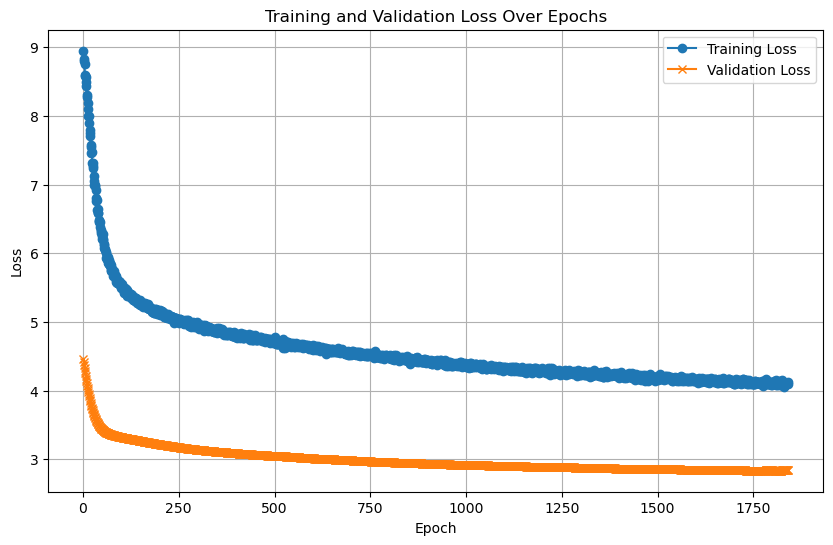

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/38], Loss: 4.6410
Test Batch [20/38], Loss: 4.8314
Test Batch [30/38], Loss: 5.2830

Test Loss: 4.9889


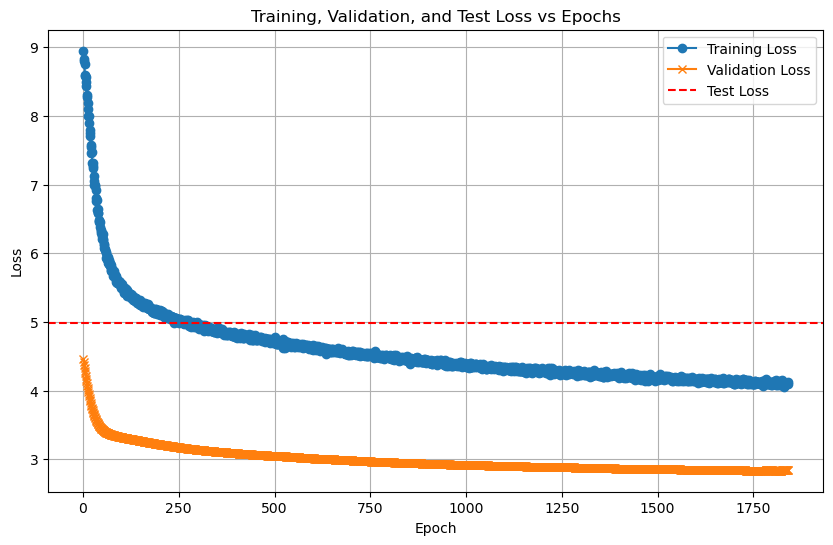

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.


  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 72.86%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.25      0.20      0.22         5
           2       0.50      0.40      0.44         5
           3       0.83      1.00      0.91         5
           4       0.80      0.80      0.80         5
           5       0.62      1.00      0.77         5
           7       1.00      0.60      0.75         5
           9       0.71      1.00      0.83         5
          10       0.67      0.80      0.73         5
          11       0.00      0.00      0.00         5
          12       1.00      1.00      1.00         5
          13       1.00      0.80      0.89         5
          14       1.00      0.60      0.75         5
          15       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9357  |  Val Loss: 2.8786
Validation loss improved from inf to 2.8786.


[Epoch 2/1000] Train Loss: 2.8903  |  Val Loss: 2.8366
Validation loss improved from 2.8786 to 2.8366.
[Epoch 3/1000] Train Loss: 2.8498  |  Val Loss: 2.7980
Validation loss improved from 2.8366 to 2.7980.
[Epoch 4/1000] Train Loss: 2.8128  |  Val Loss: 2.7629
Validation loss improved from 2.7980 to 2.7629.
[Epoch 5/1000] Train Loss: 2.7808  |  Val Loss: 2.7328
Validation loss improved from 2.7629 to 2.7328.
[Epoch 6/1000] Train Loss: 2.7516  |  Val Loss: 2.7054
Validation loss improved from 2.7328 to 2.7054.
[Epoch 7/1000] Train Loss: 2.7258  |  Val Loss: 2.6805
Validation loss improved from 2.7054 to 2.6805.
[Epoch 8/1000] Train Loss: 2.7025  |  Val Loss: 2.6573
Validation loss improved from 2.6805 to 2.6573.
[Epoch 9/1000] Train Loss: 2.6805  |  Val Loss: 2.6349
Validation loss improved from 2.6573 to 2.6349.
[Epoch 10/1000] Train Loss: 2.6591  |  Val Loss: 2.6124
Validation loss improved from 2.6349 to 2.6124.
[Epoch 11/1000] Train Loss: 2.6394  |  Val Loss: 2.5891
Validation loss 

[Epoch 19/1000] Train Loss: 2.4763  |  Val Loss: 2.4183
Validation loss improved from 2.4370 to 2.4183.
[Epoch 20/1000] Train Loss: 2.4588  |  Val Loss: 2.4006
Validation loss improved from 2.4183 to 2.4006.
[Epoch 21/1000] Train Loss: 2.4426  |  Val Loss: 2.3839
Validation loss improved from 2.4006 to 2.3839.
[Epoch 22/1000] Train Loss: 2.4272  |  Val Loss: 2.3680
Validation loss improved from 2.3839 to 2.3680.
[Epoch 23/1000] Train Loss: 2.4121  |  Val Loss: 2.3524
Validation loss improved from 2.3680 to 2.3524.


[Epoch 24/1000] Train Loss: 2.3980  |  Val Loss: 2.3370
Validation loss improved from 2.3524 to 2.3370.
[Epoch 25/1000] Train Loss: 2.3834  |  Val Loss: 2.3219
Validation loss improved from 2.3370 to 2.3219.
[Epoch 26/1000] Train Loss: 2.3694  |  Val Loss: 2.3069
Validation loss improved from 2.3219 to 2.3069.
[Epoch 27/1000] Train Loss: 2.3550  |  Val Loss: 2.2922
Validation loss improved from 2.3069 to 2.2922.
[Epoch 28/1000] Train Loss: 2.3411  |  Val Loss: 2.2775
Validation loss improved from 2.2922 to 2.2775.
[Epoch 29/1000] Train Loss: 2.3273  |  Val Loss: 2.2627
Validation loss improved from 2.2775 to 2.2627.
[Epoch 30/1000] Train Loss: 2.3131  |  Val Loss: 2.2482
Validation loss improved from 2.2627 to 2.2482.
[Epoch 31/1000] Train Loss: 2.2994  |  Val Loss: 2.2341
Validation loss improved from 2.2482 to 2.2341.
[Epoch 32/1000] Train Loss: 2.2857  |  Val Loss: 2.2198
Validation loss improved from 2.2341 to 2.2198.
[Epoch 33/1000] Train Loss: 2.2724  |  Val Loss: 2.2058
Validati

[Epoch 37/1000] Train Loss: 2.2201  |  Val Loss: 2.1500
Validation loss improved from 2.1640 to 2.1500.
[Epoch 38/1000] Train Loss: 2.2075  |  Val Loss: 2.1361
Validation loss improved from 2.1500 to 2.1361.
[Epoch 39/1000] Train Loss: 2.1947  |  Val Loss: 2.1219
Validation loss improved from 2.1361 to 2.1219.
[Epoch 40/1000] Train Loss: 2.1819  |  Val Loss: 2.1076
Validation loss improved from 2.1219 to 2.1076.
[Epoch 41/1000] Train Loss: 2.1692  |  Val Loss: 2.0935
Validation loss improved from 2.1076 to 2.0935.
[Epoch 42/1000] Train Loss: 2.1563  |  Val Loss: 2.0793
Validation loss improved from 2.0935 to 2.0793.
[Epoch 43/1000] Train Loss: 2.1439  |  Val Loss: 2.0650
Validation loss improved from 2.0793 to 2.0650.


[Epoch 44/1000] Train Loss: 2.1308  |  Val Loss: 2.0507
Validation loss improved from 2.0650 to 2.0507.
[Epoch 45/1000] Train Loss: 2.1179  |  Val Loss: 2.0360
Validation loss improved from 2.0507 to 2.0360.
[Epoch 46/1000] Train Loss: 2.1047  |  Val Loss: 2.0212
Validation loss improved from 2.0360 to 2.0212.
[Epoch 47/1000] Train Loss: 2.0912  |  Val Loss: 2.0060
Validation loss improved from 2.0212 to 2.0060.
[Epoch 48/1000] Train Loss: 2.0778  |  Val Loss: 1.9904
Validation loss improved from 2.0060 to 1.9904.
[Epoch 49/1000] Train Loss: 2.0640  |  Val Loss: 1.9744
Validation loss improved from 1.9904 to 1.9744.
[Epoch 50/1000] Train Loss: 2.0502  |  Val Loss: 1.9588
Validation loss improved from 1.9744 to 1.9588.
[Epoch 51/1000] Train Loss: 2.0364  |  Val Loss: 1.9437
Validation loss improved from 1.9588 to 1.9437.
[Epoch 52/1000] Train Loss: 2.0228  |  Val Loss: 1.9280
Validation loss improved from 1.9437 to 1.9280.
[Epoch 53/1000] Train Loss: 2.0088  |  Val Loss: 1.9127
Validati

[Epoch 56/1000] Train Loss: 1.9672  |  Val Loss: 1.8667
Validation loss improved from 1.8820 to 1.8667.
[Epoch 57/1000] Train Loss: 1.9532  |  Val Loss: 1.8513
Validation loss improved from 1.8667 to 1.8513.
[Epoch 58/1000] Train Loss: 1.9400  |  Val Loss: 1.8356
Validation loss improved from 1.8513 to 1.8356.
[Epoch 59/1000] Train Loss: 1.9254  |  Val Loss: 1.8202
Validation loss improved from 1.8356 to 1.8202.
[Epoch 60/1000] Train Loss: 1.9112  |  Val Loss: 1.8042
Validation loss improved from 1.8202 to 1.8042.
[Epoch 61/1000] Train Loss: 1.8975  |  Val Loss: 1.7884
Validation loss improved from 1.8042 to 1.7884.
[Epoch 62/1000] Train Loss: 1.8835  |  Val Loss: 1.7720
Validation loss improved from 1.7884 to 1.7720.


[Epoch 63/1000] Train Loss: 1.8693  |  Val Loss: 1.7562
Validation loss improved from 1.7720 to 1.7562.
[Epoch 64/1000] Train Loss: 1.8550  |  Val Loss: 1.7410
Validation loss improved from 1.7562 to 1.7410.
[Epoch 65/1000] Train Loss: 1.8410  |  Val Loss: 1.7261
Validation loss improved from 1.7410 to 1.7261.
[Epoch 66/1000] Train Loss: 1.8272  |  Val Loss: 1.7110
Validation loss improved from 1.7261 to 1.7110.
[Epoch 67/1000] Train Loss: 1.8136  |  Val Loss: 1.6956
Validation loss improved from 1.7110 to 1.6956.
[Epoch 68/1000] Train Loss: 1.7996  |  Val Loss: 1.6801
Validation loss improved from 1.6956 to 1.6801.
[Epoch 69/1000] Train Loss: 1.7851  |  Val Loss: 1.6650
Validation loss improved from 1.6801 to 1.6650.
[Epoch 70/1000] Train Loss: 1.7713  |  Val Loss: 1.6495
Validation loss improved from 1.6650 to 1.6495.
[Epoch 71/1000] Train Loss: 1.7572  |  Val Loss: 1.6341
Validation loss improved from 1.6495 to 1.6341.
[Epoch 72/1000] Train Loss: 1.7434  |  Val Loss: 1.6188
Validati

[Epoch 75/1000] Train Loss: 1.7013  |  Val Loss: 1.5745
Validation loss improved from 1.5893 to 1.5745.
[Epoch 76/1000] Train Loss: 1.6873  |  Val Loss: 1.5595
Validation loss improved from 1.5745 to 1.5595.
[Epoch 77/1000] Train Loss: 1.6732  |  Val Loss: 1.5444
Validation loss improved from 1.5595 to 1.5444.
[Epoch 78/1000] Train Loss: 1.6598  |  Val Loss: 1.5297
Validation loss improved from 1.5444 to 1.5297.


[Epoch 79/1000] Train Loss: 1.6463  |  Val Loss: 1.5151
Validation loss improved from 1.5297 to 1.5151.
[Epoch 80/1000] Train Loss: 1.6320  |  Val Loss: 1.5008
Validation loss improved from 1.5151 to 1.5008.
[Epoch 81/1000] Train Loss: 1.6184  |  Val Loss: 1.4862
Validation loss improved from 1.5008 to 1.4862.
[Epoch 82/1000] Train Loss: 1.6050  |  Val Loss: 1.4723
Validation loss improved from 1.4862 to 1.4723.
[Epoch 83/1000] Train Loss: 1.5914  |  Val Loss: 1.4588
Validation loss improved from 1.4723 to 1.4588.
[Epoch 84/1000] Train Loss: 1.5781  |  Val Loss: 1.4455
Validation loss improved from 1.4588 to 1.4455.
[Epoch 85/1000] Train Loss: 1.5650  |  Val Loss: 1.4325
Validation loss improved from 1.4455 to 1.4325.
[Epoch 86/1000] Train Loss: 1.5520  |  Val Loss: 1.4190
Validation loss improved from 1.4325 to 1.4190.
[Epoch 87/1000] Train Loss: 1.5391  |  Val Loss: 1.4062
Validation loss improved from 1.4190 to 1.4062.
[Epoch 88/1000] Train Loss: 1.5271  |  Val Loss: 1.3940
Validati

[Epoch 94/1000] Train Loss: 1.4543  |  Val Loss: 1.3240
Validation loss improved from 1.3354 to 1.3240.
[Epoch 95/1000] Train Loss: 1.4429  |  Val Loss: 1.3128
Validation loss improved from 1.3240 to 1.3128.
[Epoch 96/1000] Train Loss: 1.4326  |  Val Loss: 1.3021
Validation loss improved from 1.3128 to 1.3021.
[Epoch 97/1000] Train Loss: 1.4211  |  Val Loss: 1.2920
Validation loss improved from 1.3021 to 1.2920.
[Epoch 98/1000] Train Loss: 1.4103  |  Val Loss: 1.2822
Validation loss improved from 1.2920 to 1.2822.


[Epoch 99/1000] Train Loss: 1.4004  |  Val Loss: 1.2725
Validation loss improved from 1.2822 to 1.2725.
[Epoch 100/1000] Train Loss: 1.3894  |  Val Loss: 1.2635
Validation loss improved from 1.2725 to 1.2635.
[Epoch 101/1000] Train Loss: 1.3794  |  Val Loss: 1.2543
Validation loss improved from 1.2635 to 1.2543.
[Epoch 102/1000] Train Loss: 1.3694  |  Val Loss: 1.2454
Validation loss improved from 1.2543 to 1.2454.
[Epoch 103/1000] Train Loss: 1.3597  |  Val Loss: 1.2370
Validation loss improved from 1.2454 to 1.2370.
[Epoch 104/1000] Train Loss: 1.3505  |  Val Loss: 1.2289
Validation loss improved from 1.2370 to 1.2289.
[Epoch 105/1000] Train Loss: 1.3405  |  Val Loss: 1.2202
Validation loss improved from 1.2289 to 1.2202.
[Epoch 106/1000] Train Loss: 1.3310  |  Val Loss: 1.2122
Validation loss improved from 1.2202 to 1.2122.
[Epoch 107/1000] Train Loss: 1.3216  |  Val Loss: 1.2045
Validation loss improved from 1.2122 to 1.2045.
[Epoch 108/1000] Train Loss: 1.3122  |  Val Loss: 1.1968

[Epoch 112/1000] Train Loss: 1.2768  |  Val Loss: 1.1688
Validation loss improved from 1.1752 to 1.1688.
[Epoch 113/1000] Train Loss: 1.2686  |  Val Loss: 1.1615
Validation loss improved from 1.1688 to 1.1615.
[Epoch 114/1000] Train Loss: 1.2600  |  Val Loss: 1.1552
Validation loss improved from 1.1615 to 1.1552.
[Epoch 115/1000] Train Loss: 1.2518  |  Val Loss: 1.1496
Validation loss improved from 1.1552 to 1.1496.
[Epoch 116/1000] Train Loss: 1.2433  |  Val Loss: 1.1438
Validation loss improved from 1.1496 to 1.1438.


[Epoch 117/1000] Train Loss: 1.2352  |  Val Loss: 1.1382
Validation loss improved from 1.1438 to 1.1382.
[Epoch 118/1000] Train Loss: 1.2277  |  Val Loss: 1.1318
Validation loss improved from 1.1382 to 1.1318.
[Epoch 119/1000] Train Loss: 1.2191  |  Val Loss: 1.1259
Validation loss improved from 1.1318 to 1.1259.
[Epoch 120/1000] Train Loss: 1.2115  |  Val Loss: 1.1200
Validation loss improved from 1.1259 to 1.1200.
[Epoch 121/1000] Train Loss: 1.2036  |  Val Loss: 1.1153
Validation loss improved from 1.1200 to 1.1153.
[Epoch 122/1000] Train Loss: 1.1957  |  Val Loss: 1.1098
Validation loss improved from 1.1153 to 1.1098.
[Epoch 123/1000] Train Loss: 1.1882  |  Val Loss: 1.1047
Validation loss improved from 1.1098 to 1.1047.
[Epoch 124/1000] Train Loss: 1.1806  |  Val Loss: 1.0995
Validation loss improved from 1.1047 to 1.0995.
[Epoch 125/1000] Train Loss: 1.1732  |  Val Loss: 1.0956
Validation loss improved from 1.0995 to 1.0956.
[Epoch 126/1000] Train Loss: 1.1652  |  Val Loss: 1.090

[Epoch 131/1000] Train Loss: 1.1290  |  Val Loss: 1.0673
Validation loss improved from 1.0709 to 1.0673.
[Epoch 132/1000] Train Loss: 1.1218  |  Val Loss: 1.0632
Validation loss improved from 1.0673 to 1.0632.
[Epoch 133/1000] Train Loss: 1.1141  |  Val Loss: 1.0598
Validation loss improved from 1.0632 to 1.0598.
[Epoch 134/1000] Train Loss: 1.1067  |  Val Loss: 1.0556
Validation loss improved from 1.0598 to 1.0556.
[Epoch 135/1000] Train Loss: 1.1001  |  Val Loss: 1.0514
Validation loss improved from 1.0556 to 1.0514.


[Epoch 136/1000] Train Loss: 1.0926  |  Val Loss: 1.0467
Validation loss improved from 1.0514 to 1.0467.
[Epoch 137/1000] Train Loss: 1.0861  |  Val Loss: 1.0427
Validation loss improved from 1.0467 to 1.0427.
[Epoch 138/1000] Train Loss: 1.0797  |  Val Loss: 1.0401
Validation loss improved from 1.0427 to 1.0401.
[Epoch 139/1000] Train Loss: 1.0727  |  Val Loss: 1.0361
Validation loss improved from 1.0401 to 1.0361.
[Epoch 140/1000] Train Loss: 1.0661  |  Val Loss: 1.0324
Validation loss improved from 1.0361 to 1.0324.
[Epoch 141/1000] Train Loss: 1.0602  |  Val Loss: 1.0302
Validation loss improved from 1.0324 to 1.0302.
[Epoch 142/1000] Train Loss: 1.0535  |  Val Loss: 1.0276
Validation loss improved from 1.0302 to 1.0276.
[Epoch 143/1000] Train Loss: 1.0465  |  Val Loss: 1.0242
Validation loss improved from 1.0276 to 1.0242.
[Epoch 144/1000] Train Loss: 1.0399  |  Val Loss: 1.0214
Validation loss improved from 1.0242 to 1.0214.
[Epoch 145/1000] Train Loss: 1.0344  |  Val Loss: 1.018

[Epoch 148/1000] Train Loss: 1.0160  |  Val Loss: 1.0115
Validation loss improved from 1.0131 to 1.0115.
[Epoch 149/1000] Train Loss: 1.0098  |  Val Loss: 1.0087
Validation loss improved from 1.0115 to 1.0087.
[Epoch 150/1000] Train Loss: 1.0036  |  Val Loss: 1.0061
Validation loss improved from 1.0087 to 1.0061.
[Epoch 151/1000] Train Loss: 0.9984  |  Val Loss: 1.0031
Validation loss improved from 1.0061 to 1.0031.
[Epoch 152/1000] Train Loss: 0.9920  |  Val Loss: 1.0000
Validation loss improved from 1.0031 to 1.0000.
[Epoch 153/1000] Train Loss: 0.9860  |  Val Loss: 0.9972
Validation loss improved from 1.0000 to 0.9972.


[Epoch 154/1000] Train Loss: 0.9808  |  Val Loss: 0.9969
Validation loss improved from 0.9972 to 0.9969.
[Epoch 155/1000] Train Loss: 0.9745  |  Val Loss: 0.9944
Validation loss improved from 0.9969 to 0.9944.
[Epoch 156/1000] Train Loss: 0.9694  |  Val Loss: 0.9922
Validation loss improved from 0.9944 to 0.9922.
[Epoch 157/1000] Train Loss: 0.9638  |  Val Loss: 0.9907
Validation loss improved from 0.9922 to 0.9907.
[Epoch 158/1000] Train Loss: 0.9583  |  Val Loss: 0.9880
Validation loss improved from 0.9907 to 0.9880.
[Epoch 159/1000] Train Loss: 0.9537  |  Val Loss: 0.9864
Validation loss improved from 0.9880 to 0.9864.
[Epoch 160/1000] Train Loss: 0.9477  |  Val Loss: 0.9845
Validation loss improved from 0.9864 to 0.9845.
[Epoch 161/1000] Train Loss: 0.9426  |  Val Loss: 0.9823
Validation loss improved from 0.9845 to 0.9823.
[Epoch 162/1000] Train Loss: 0.9372  |  Val Loss: 0.9804
Validation loss improved from 0.9823 to 0.9804.
[Epoch 163/1000] Train Loss: 0.9326  |  Val Loss: 0.979

[Epoch 166/1000] Train Loss: 0.9174  |  Val Loss: 0.9743
Validation loss improved from 0.9753 to 0.9743.
[Epoch 167/1000] Train Loss: 0.9127  |  Val Loss: 0.9735
Validation loss improved from 0.9743 to 0.9735.
[Epoch 168/1000] Train Loss: 0.9083  |  Val Loss: 0.9723
Validation loss improved from 0.9735 to 0.9723.
[Epoch 169/1000] Train Loss: 0.9036  |  Val Loss: 0.9691
Validation loss improved from 0.9723 to 0.9691.
[Epoch 170/1000] Train Loss: 0.8983  |  Val Loss: 0.9673
Validation loss improved from 0.9691 to 0.9673.
[Epoch 171/1000] Train Loss: 0.8938  |  Val Loss: 0.9652
Validation loss improved from 0.9673 to 0.9652.
[Epoch 172/1000] Train Loss: 0.8902  |  Val Loss: 0.9634
Validation loss improved from 0.9652 to 0.9634.
[Epoch 173/1000] Train Loss: 0.8850  |  Val Loss: 0.9633
Validation loss improved from 0.9634 to 0.9633.


[Epoch 174/1000] Train Loss: 0.8801  |  Val Loss: 0.9631
Validation loss improved from 0.9633 to 0.9631.
[Epoch 175/1000] Train Loss: 0.8762  |  Val Loss: 0.9604
Validation loss improved from 0.9631 to 0.9604.
[Epoch 176/1000] Train Loss: 0.8714  |  Val Loss: 0.9581
Validation loss improved from 0.9604 to 0.9581.
[Epoch 177/1000] Train Loss: 0.8671  |  Val Loss: 0.9587
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 0.8629  |  Val Loss: 0.9575
Validation loss improved from 0.9581 to 0.9575.
[Epoch 179/1000] Train Loss: 0.8589  |  Val Loss: 0.9573
Validation loss improved from 0.9575 to 0.9573.
[Epoch 180/1000] Train Loss: 0.8554  |  Val Loss: 0.9547
Validation loss improved from 0.9573 to 0.9547.
[Epoch 181/1000] Train Loss: 0.8505  |  Val Loss: 0.9526
Validation loss improved from 0.9547 to 0.9526.
[Epoch 182/1000] Train Loss: 0.8462  |  Val Loss: 0.9511
Validation loss improved from 0.9526 to 0.9511.
[Epoch 183/1000] Train Loss: 0.8422  |  Val Loss:

[Epoch 184/1000] Train Loss: 0.8391  |  Val Loss: 0.9508
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 185/1000] Train Loss: 0.8346  |  Val Loss: 0.9499
Validation loss improved from 0.9500 to 0.9499.
[Epoch 186/1000] Train Loss: 0.8305  |  Val Loss: 0.9482
Validation loss improved from 0.9499 to 0.9482.
[Epoch 187/1000] Train Loss: 0.8271  |  Val Loss: 0.9467
Validation loss improved from 0.9482 to 0.9467.
[Epoch 188/1000] Train Loss: 0.8235  |  Val Loss: 0.9443
Validation loss improved from 0.9467 to 0.9443.
[Epoch 189/1000] Train Loss: 0.8189  |  Val Loss: 0.9444
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 190/1000] Train Loss: 0.8158  |  Val Loss: 0.9443
Validation loss improved from 0.9443 to 0.9443.
[Epoch 191/1000] Train Loss: 0.8122  |  Val Loss: 0.9431
Validation loss improved from 0.9443 to 0.9431.
[Epoch 192/1000] Train Loss: 0.8086  |  Val Loss: 0.9413
Validation loss improved from 0.9431 to 0.9413.


[Epoch 193/1000] Train Loss: 0.8050  |  Val Loss: 0.9403
Validation loss improved from 0.9413 to 0.9403.
[Epoch 194/1000] Train Loss: 0.8015  |  Val Loss: 0.9400
Validation loss improved from 0.9403 to 0.9400.
[Epoch 195/1000] Train Loss: 0.7986  |  Val Loss: 0.9396
Validation loss improved from 0.9400 to 0.9396.
[Epoch 196/1000] Train Loss: 0.7944  |  Val Loss: 0.9376
Validation loss improved from 0.9396 to 0.9376.
[Epoch 197/1000] Train Loss: 0.7911  |  Val Loss: 0.9369
Validation loss improved from 0.9376 to 0.9369.
[Epoch 198/1000] Train Loss: 0.7879  |  Val Loss: 0.9358
Validation loss improved from 0.9369 to 0.9358.
[Epoch 199/1000] Train Loss: 0.7848  |  Val Loss: 0.9347
Validation loss improved from 0.9358 to 0.9347.
[Epoch 200/1000] Train Loss: 0.7823  |  Val Loss: 0.9355
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 0.7792  |  Val Loss: 0.9340
Validation loss improved from 0.9347 to 0.9340.


[Epoch 202/1000] Train Loss: 0.7759  |  Val Loss: 0.9347
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 203/1000] Train Loss: 0.7726  |  Val Loss: 0.9343
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 204/1000] Train Loss: 0.7697  |  Val Loss: 0.9316
Validation loss improved from 0.9340 to 0.9316.
[Epoch 205/1000] Train Loss: 0.7665  |  Val Loss: 0.9303
Validation loss improved from 0.9316 to 0.9303.
[Epoch 206/1000] Train Loss: 0.7633  |  Val Loss: 0.9291
Validation loss improved from 0.9303 to 0.9291.
[Epoch 207/1000] Train Loss: 0.7600  |  Val Loss: 0.9287
Validation loss improved from 0.9291 to 0.9287.
[Epoch 208/1000] Train Loss: 0.7569  |  Val Loss: 0.9279
Validation loss improved from 0.9287 to 0.9279.
[Epoch 209/1000] Train Loss: 0.7551  |  Val Loss: 0.9275
Validation loss improved from 0.9279 to 0.9275.
[Epoch 210/1000] Train Loss: 0.7517  |  Val Loss: 0.9250
Validation loss improved from 0.9275 to 0.9250.
[Epoch 211/1000] Train Loss: 0.7484  |  Val

[Epoch 212/1000] Train Loss: 0.7456  |  Val Loss: 0.9252
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 0.7429  |  Val Loss: 0.9259
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 214/1000] Train Loss: 0.7402  |  Val Loss: 0.9248
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 215/1000] Train Loss: 0.7375  |  Val Loss: 0.9235
Validation loss improved from 0.9248 to 0.9235.
[Epoch 216/1000] Train Loss: 0.7349  |  Val Loss: 0.9220
Validation loss improved from 0.9235 to 0.9220.
[Epoch 217/1000] Train Loss: 0.7330  |  Val Loss: 0.9208
Validation loss improved from 0.9220 to 0.9208.
[Epoch 218/1000] Train Loss: 0.7304  |  Val Loss: 0.9199
Validation loss improved from 0.9208 to 0.9199.
[Epoch 219/1000] Train Loss: 0.7274  |  Val Loss: 0.9190
Validation loss improved from 0.9199 to 0.9190.
[Epoch 220/1000] Train Loss: 0.7250  |  Val Loss: 0.9186
Validation loss improved from 0.9190 to 0.9186.


[Epoch 221/1000] Train Loss: 0.7229  |  Val Loss: 0.9168
Validation loss improved from 0.9186 to 0.9168.
[Epoch 222/1000] Train Loss: 0.7203  |  Val Loss: 0.9175
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 223/1000] Train Loss: 0.7177  |  Val Loss: 0.9173
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 224/1000] Train Loss: 0.7151  |  Val Loss: 0.9163
Validation loss improved from 0.9168 to 0.9163.
[Epoch 225/1000] Train Loss: 0.7129  |  Val Loss: 0.9153
Validation loss improved from 0.9163 to 0.9153.
[Epoch 226/1000] Train Loss: 0.7106  |  Val Loss: 0.9150
Validation loss improved from 0.9153 to 0.9150.
[Epoch 227/1000] Train Loss: 0.7082  |  Val Loss: 0.9148
Validation loss improved from 0.9150 to 0.9148.
[Epoch 228/1000] Train Loss: 0.7066  |  Val Loss: 0.9137
Validation loss improved from 0.9148 to 0.9137.
[Epoch 229/1000] Train Loss: 0.7040  |  Val Loss: 0.9142
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.7021  

[Epoch 231/1000] Train Loss: 0.7003  |  Val Loss: 0.9129
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 0.6976  |  Val Loss: 0.9111
Validation loss improved from 0.9122 to 0.9111.
[Epoch 233/1000] Train Loss: 0.6955  |  Val Loss: 0.9108
Validation loss improved from 0.9111 to 0.9108.
[Epoch 234/1000] Train Loss: 0.6944  |  Val Loss: 0.9095
Validation loss improved from 0.9108 to 0.9095.
[Epoch 235/1000] Train Loss: 0.6914  |  Val Loss: 0.9117
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 0.6900  |  Val Loss: 0.9122
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 237/1000] Train Loss: 0.6875  |  Val Loss: 0.9111
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 238/1000] Train Loss: 0.6855  |  Val Loss: 0.9080
Validation loss improved from 0.9095 to 0.9080.
[Epoch 239/1000] Train Loss: 0.6833  |  Val Loss: 0.9082
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 240/1000] Train Loss: 0.6810  |  Val Loss: 0.9062
Validation loss improved from 0.9080 to 0.9062.
[Epoch 241/1000] Train Loss: 0.6793  |  Val Loss: 0.9075
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 242/1000] Train Loss: 0.6773  |  Val Loss: 0.9073
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 243/1000] Train Loss: 0.6760  |  Val Loss: 0.9079
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 244/1000] Train Loss: 0.6740  |  Val Loss: 0.9066
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 245/1000] Train Loss: 0.6724  |  Val Loss: 0.9071
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 246/1000] Train Loss: 0.6704  |  Val Loss: 0.9045
Validation loss improved from 0.9062 to 0.9045.
[Epoch 247/1000] Train Loss: 0.6681  |  Val Loss: 0.9058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.6664  |  Val Loss: 0.9057
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 249/10

[Epoch 250/1000] Train Loss: 0.6631  |  Val Loss: 0.9058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 0.6614  |  Val Loss: 0.9039
Validation loss improved from 0.9042 to 0.9039.
[Epoch 252/1000] Train Loss: 0.6595  |  Val Loss: 0.9040
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 253/1000] Train Loss: 0.6580  |  Val Loss: 0.9056
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 254/1000] Train Loss: 0.6561  |  Val Loss: 0.9040
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 255/1000] Train Loss: 0.6547  |  Val Loss: 0.9021
Validation loss improved from 0.9039 to 0.9021.
[Epoch 256/1000] Train Loss: 0.6535  |  Val Loss: 0.9023
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 257/1000] Train Loss: 0.6516  |  Val Loss: 0.9033
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 258/1000] Train Loss: 0.6501  |  Val Loss: 0.9024
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 259/1000] Train Loss: 0.6485  |  Val Loss: 0.9021
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 260/1000] Train Loss: 0.6474  |  Val Loss: 0.9042
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 261/1000] Train Loss: 0.6448  |  Val Loss: 0.9030
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 262/1000] Train Loss: 0.6434  |  Val Loss: 0.9026
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 263/1000] Train Loss: 0.6424  |  Val Loss: 0.9014
Validation loss improved from 0.9021 to 0.9014.
[Epoch 264/1000] Train Loss: 0.6410  |  Val Loss: 0.9000
Validation loss improved from 0.9014 to 0.9000.
[Epoch 265/1000] Train Loss: 0.6392  |  Val Loss: 0.9000
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.6387  |  Val Loss: 0.9029
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 267/1000] Train Loss: 0.6366  |  Val Loss: 0.9009
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 268/1000] Train Loss: 0.6351  |  Val Loss: 0.9002
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 269/1000] Train Loss: 0.6332  |  Val Loss: 0.8998
Validation loss improved from 0.9000 to 0.8998.
[Epoch 270/1000] Train Loss: 0.6329  |  Val Loss: 0.8978
Validation loss improved from 0.8998 to 0.8978.
[Epoch 271/1000] Train Loss: 0.6312  |  Val Loss: 0.9009
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 272/1000] Train Loss: 0.6296  |  Val Loss: 0.9001
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 273/1000] Train Loss: 0.6284  |  Val Loss: 0.8982
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 274/1000] Train Loss: 0.6274  |  Val Loss: 0.8999
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 275/1000] Train Loss: 0.6255  |  Val Loss: 0.8995
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 276/1000] Train Loss: 0.6251  |  Val Loss: 0.8977
Validation loss improved from 0.8978 to 0.8977.
[Epoch 277/1000] Train Loss: 0.6231  |  Val Loss: 0.8974
Validation loss improved from 0.8977 to 0.8974.
[Epoch 278/1000] Train Loss: 0.6221  |  Val Loss: 0.8987
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 279/1000] Train Loss: 0.6208  |  Val Loss: 0.8995
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 0.6203  |  Val Loss: 0.8981
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 281/1000] Train Loss: 0.6182  |  Val Loss: 0.8981
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 282/1000] Train Loss: 0.6177  |  Val Loss: 0.8977
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 283/1000] Train Loss: 0.6161  |  Val Loss: 0.8979
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 284/10

[Epoch 288/1000] Train Loss: 0.6095  |  Val Loss: 0.8961
Validation loss improved from 0.8963 to 0.8961.
[Epoch 289/1000] Train Loss: 0.6091  |  Val Loss: 0.8970
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.6075  |  Val Loss: 0.8971
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 291/1000] Train Loss: 0.6063  |  Val Loss: 0.8956
Validation loss improved from 0.8961 to 0.8956.
[Epoch 292/1000] Train Loss: 0.6062  |  Val Loss: 0.8946
Validation loss improved from 0.8956 to 0.8946.
[Epoch 293/1000] Train Loss: 0.6050  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 294/1000] Train Loss: 0.6035  |  Val Loss: 0.8968
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 295/1000] Train Loss: 0.6030  |  Val Loss: 0.8948
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 296/1000] Train Loss: 0.6012  |  Val Loss: 0.8946
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 297/1000] Train Loss: 0.6000  |  Val Loss: 0.8956
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 298/1000] Train Loss: 0.5994  |  Val Loss: 0.8961
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 299/1000] Train Loss: 0.5987  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 300/1000] Train Loss: 0.5974  |  Val Loss: 0.8959
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 301/1000] Train Loss: 0.5960  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 302/1000] Train Loss: 0.5950  |  Val Loss: 0.8954
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 303/1000] Train Loss: 0.5946  |  Val Loss: 0.8951
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 307/1000] Train Loss: 0.5904  |  Val Loss: 0.8940
Validation loss improved from 0.8946 to 0.8940.
[Epoch 308/1000] Train Loss: 0.5897  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 309/1000] Train Loss: 0.5880  |  Val Loss: 0.8951
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 310/1000] Train Loss: 0.5876  |  Val Loss: 0.8956
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 311/1000] Train Loss: 0.5866  |  Val Loss: 0.8950
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 312/1000] Train Loss: 0.5862  |  Val Loss: 0.8938
Validation loss improved from 0.8940 to 0.8938.
[Epoch 313/1000] Train Loss: 0.5846  |  Val Loss: 0.8937
Validation loss improved from 0.8938 to 0.8937.
[Epoch 314/1000] Train Loss: 0.5848  |  Val Loss: 0.8957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 0.5836  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 316/1000] Tr

[Epoch 317/1000] Train Loss: 0.5811  |  Val Loss: 0.8923
Validation loss improved from 0.8924 to 0.8923.
[Epoch 318/1000] Train Loss: 0.5803  |  Val Loss: 0.8930
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 319/1000] Train Loss: 0.5807  |  Val Loss: 0.8940
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 320/1000] Train Loss: 0.5786  |  Val Loss: 0.8954
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 321/1000] Train Loss: 0.5794  |  Val Loss: 0.8973
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 322/1000] Train Loss: 0.5771  |  Val Loss: 0.8929
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 323/1000] Train Loss: 0.5765  |  Val Loss: 0.8921
Validation loss improved from 0.8923 to 0.8921.


[Epoch 324/1000] Train Loss: 0.5761  |  Val Loss: 0.8932
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 325/1000] Train Loss: 0.5756  |  Val Loss: 0.8934
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 326/1000] Train Loss: 0.5742  |  Val Loss: 0.8921
Validation loss improved from 0.8921 to 0.8921.
[Epoch 327/1000] Train Loss: 0.5729  |  Val Loss: 0.8925
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 328/1000] Train Loss: 0.5729  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 329/1000] Train Loss: 0.5713  |  Val Loss: 0.8953
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 330/1000] Train Loss: 0.5710  |  Val Loss: 0.8937
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 331/1000] Train Loss: 0.5702  |  Val Loss: 0.8930
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 332/1000] Train Loss: 0.5699  |  Val Loss: 0.8941
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 336/1000] Train Loss: 0.5664  |  Val Loss: 0.8937
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 337/1000] Train Loss: 0.5657  |  Val Loss: 0.8955
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 338/1000] Train Loss: 0.5649  |  Val Loss: 0.8926
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 339/1000] Train Loss: 0.5641  |  Val Loss: 0.8933
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 340/1000] Train Loss: 0.5633  |  Val Loss: 0.8936
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 341/1000] Train Loss: 0.5633  |  Val Loss: 0.8932
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 342/1000] Train Loss: 0.5619  |  Val Loss: 0.8938
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 343/1000] Train Loss: 0.5621  |  Val Loss: 0.8965
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 344/1000] Train Loss: 0.5607  |  Val Loss: 0.8957
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 345/1000] Train Loss: 0.5617  |  Val Loss: 0.8946
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 346/1000] Train Loss: 0.5594  |  Val Loss: 0.8953
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 347/1000] Train Loss: 0.5582  |  Val Loss: 0.8956
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 348/1000] Train Loss: 0.5574  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 349/1000] Train Loss: 0.5579  |  Val Loss: 0.8946
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 350/1000] Train Loss: 0.5570  |  Val Loss: 0.8920
!! Validation loss did NOT improve !! Patience: 15

[Epoch 355/1000] Train Loss: 0.5532  |  Val Loss: 0.8962
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 356/1000] Train Loss: 0.5529  |  Val Loss: 0.8938
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 357/1000] Train Loss: 0.5531  |  Val Loss: 0.8947
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 358/1000] Train Loss: 0.5514  |  Val Loss: 0.8954
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 359/1000] Train Loss: 0.5513  |  Val Loss: 0.8942
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 360/1000] Train Loss: 0.5505  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 361/1000] Train Loss: 0.5493  |  Val Loss: 0.8950
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 362/1000] Train Loss: 0.5503  |  Val Loss: 0.8942
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 363/1000] Train Loss: 0.5489  |  Val Loss: 0.8939
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 364/1000] Train Loss: 0.5480  |  Val Loss: 0.8933
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 365/1000] Train Loss: 0.5487  |  Val Loss: 0.8975
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 366/1000] Train Loss: 0.5469  |  Val Loss: 0.8983
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 367/1000] Train Loss: 0.5457  |  Val Loss: 0.8960
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 368/1000] Train Loss: 0.5466  |  Val Loss: 0.8941
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 369/1000] Train Loss: 0.5451  |  Val Loss: 0.8950
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 370/1000] Train Loss: 0.5444  |  Val Loss: 0.8951
!! Validation loss did NOT improve !! Patience:

[Epoch 375/1000] Train Loss: 0.5417  |  Val Loss: 0.8966
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 376/1000] Train Loss: 0.5420  |  Val Loss: 0.8942
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 377/1000] Train Loss: 0.5408  |  Val Loss: 0.8949
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 378/1000] Train Loss: 0.5398  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 379/1000] Train Loss: 0.5397  |  Val Loss: 0.8955
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 380/1000] Train Loss: 0.5386  |  Val Loss: 0.8961
!! Validation loss did NOT improve !! Patience: 45/100


[Epoch 381/1000] Train Loss: 0.5386  |  Val Loss: 0.8970
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 382/1000] Train Loss: 0.5388  |  Val Loss: 0.8955
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 383/1000] Train Loss: 0.5372  |  Val Loss: 0.8953
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 384/1000] Train Loss: 0.5379  |  Val Loss: 0.8969
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 385/1000] Train Loss: 0.5365  |  Val Loss: 0.8957
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 386/1000] Train Loss: 0.5362  |  Val Loss: 0.8945
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 387/1000] Train Loss: 0.5352  |  Val Loss: 0.8964
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 388/1000] Train Loss: 0.5349  |  Val Loss: 0.8965
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 389/1000] Train Loss: 0.5340  |  Val Loss: 0.8973
!! Validation loss did NOT improve !! Patience:

[Epoch 395/1000] Train Loss: 0.5312  |  Val Loss: 0.8956
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 396/1000] Train Loss: 0.5309  |  Val Loss: 0.8961
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 397/1000] Train Loss: 0.5302  |  Val Loss: 0.8969
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 398/1000] Train Loss: 0.5294  |  Val Loss: 0.8969
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 399/1000] Train Loss: 0.5295  |  Val Loss: 0.8965
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 400/1000] Train Loss: 0.5284  |  Val Loss: 0.8959
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 401/1000] Train Loss: 0.5286  |  Val Loss: 0.8954
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 402/1000] Train Loss: 0.5298  |  Val Loss: 0.8929
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 403/1000] Train Loss: 0.5274  |  Val Loss: 0.8955
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 404/1000] Train Loss: 0.5280  |  Val Loss: 0.8993
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 405/1000] Train Loss: 0.5265  |  Val Loss: 0.8968
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 406/1000] Train Loss: 0.5253  |  Val Loss: 0.8945
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 407/1000] Train Loss: 0.5255  |  Val Loss: 0.8940
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 408/1000] Train Loss: 0.5250  |  Val Loss: 0.8935
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 409/1000] Train Loss: 0.5246  |  Val Loss: 0.8961
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 410/1000] Train Loss: 0.5252  |  Val Loss: 0.8981
!! Validation loss did NOT improve !! Patience:

[Epoch 414/1000] Train Loss: 0.5224  |  Val Loss: 0.8967
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 415/1000] Train Loss: 0.5223  |  Val Loss: 0.8994
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 416/1000] Train Loss: 0.5214  |  Val Loss: 0.8958
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 417/1000] Train Loss: 0.5207  |  Val Loss: 0.8942
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 418/1000] Train Loss: 0.5199  |  Val Loss: 0.8938
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 419/1000] Train Loss: 0.5195  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 420/1000] Train Loss: 0.5194  |  Val Loss: 0.8950
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 421/1000] Train Loss: 0.5194  |  Val Loss: 0.8970
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 422/1000] Train Loss: 0.5186  |  Val Loss: 0.8983
!! Validation loss did NOT improve !! Patience:

[Epoch 423/1000] Train Loss: 0.5176  |  Val Loss: 0.8979
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 424/1000] Train Loss: 0.5177  |  Val Loss: 0.8957
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 425/1000] Train Loss: 0.5184  |  Val Loss: 0.8933
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 426/1000] Train Loss: 0.5171  |  Val Loss: 0.8939
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 427/1000] Train Loss: 0.5167  |  Val Loss: 0.8971
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 428/1000] Train Loss: 0.5162  |  Val Loss: 0.8969
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 429/1000] Train Loss: 0.5174  |  Val Loss: 0.8933
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 430/1000] Train Loss: 0.5163  |  Val Loss: 0.8943
!! Validation loss did NOT improve !! Patience: 95/100


[Epoch 431/1000] Train Loss: 0.5146  |  Val Loss: 0.8971
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 432/1000] Train Loss: 0.5142  |  Val Loss: 0.8974
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 433/1000] Train Loss: 0.5152  |  Val Loss: 0.8957
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 434/1000] Train Loss: 0.5134  |  Val Loss: 0.8950
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 435/1000] Train Loss: 0.5130  |  Val Loss: 0.8969
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 435 !!
No improvement for 100 epochs.


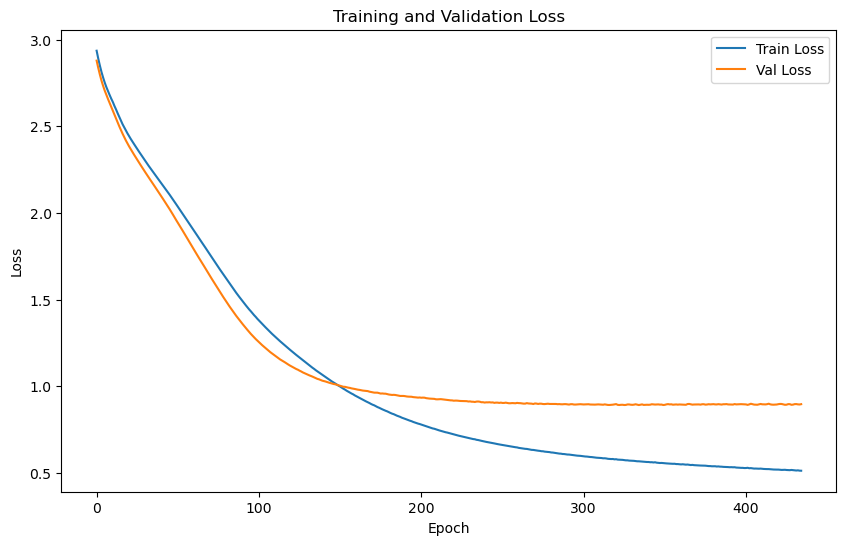

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9636 | Test Accuracy: 52.48%


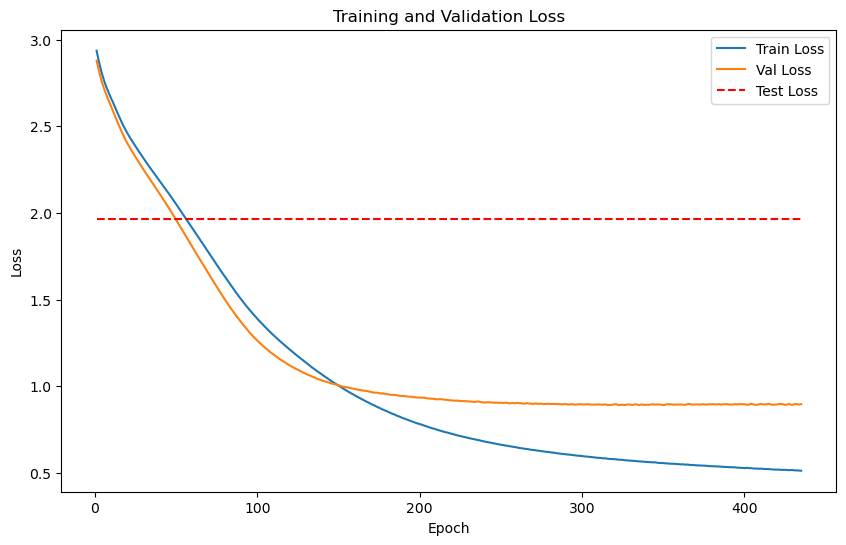

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4984
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.1110
Epoch [1/2000], Avg Train Loss: 0.4984, Avg Val Loss: 0.3097

Validation loss improved from inf to 0.3097. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.1115
Epoch [2/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.3097

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.1125
Epoch [3/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.3099

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.1138
Epoch [4/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.3101

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4975
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.1151
Epoch [5/2000], Avg Train Loss: 0.4975, Avg Val Loss: 0.3102

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4957
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.1167
Epoch [6/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.3101

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.1187
Epoch [7/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.3101

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.1206
Epoch [8/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4980
    Batch [2/2], Val Loss: 0.1220
Epoch [9/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.1234
Epoch [10/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.3102

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4963
    Batch [2/2], Val Loss: 0.1245
Epoch [11/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.3104

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.1254
Epoch [12/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.3106

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4919
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4952
    Batch [2/2], Val Loss: 0.1263
Epoch [13/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.3108

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4946
    Batch [2/2], Val Loss: 0.1271
Epoch [14/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.3109

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.1274
Epoch [15/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.3108

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.1275
Epoch [16/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.3106

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.1276
Epoch [17/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.3105

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.1277
Epoch [18/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.3103

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.1278
Epoch [19/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.3102

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.1279
Epoch [20/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.3100

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4916
    Batch [2/2], Val Loss: 0.1280
Epoch [21/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.3098

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.1281
Epoch [22/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.3096

Validation loss improved from 0.3097 to 0.3096. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.1281
Epoch [23/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.3093

Validation loss improved from 0.3096 to 0.3093. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.1280
Epoch [24/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.3091

Validation loss improved from 0.3093 to 0.3091. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.1279
Epoch [25/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.3089

Validation loss improved from 0.3091 to 0.3089. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4897
    Batch [2/2], Val Loss: 0.1278
Epoch [26/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.3088

Validation loss improved from 0.3089 to 0.3088. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.1277
Epoch [27/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.3085

Validation loss improved from 0.3088 to 0.3085. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.1276
Epoch [28/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.3083

Validation loss improved from 0.3085 to 0.3083. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.1274
Epoch [29/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.3080

Validation loss improved from 0.3083 to 0.3080. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.1271
Epoch [30/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.3077

Validation loss improved from 0.3080 to 0.3077. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.1268
Epoch [31/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.3074

Validation loss improved from 0.3077 to 0.3074. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.1264
Epoch [32/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.3070

Validation loss improved from 0.3074 to 0.3070. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.1260
Epoch [33/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.3066

Validation loss improved from 0.3070 to 0.3066. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.1256
Epoch [34/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.3062

Validation loss improved from 0.3066 to 0.3062. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.1251
Epoch [35/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.3058

Validation loss improved from 0.3062 to 0.3058. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.1247
Epoch [36/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.3054

Validation loss improved from 0.3058 to 0.3054. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.1242
Epoch [37/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.3050

Validation loss improved from 0.3054 to 0.3050. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.1237
Epoch [38/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.3046

Validation loss improved from 0.3050 to 0.3046. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.1232
Epoch [39/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.3042

Validation loss improved from 0.3046 to 0.3042. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.1226
Epoch [40/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.3038

Validation loss improved from 0.3042 to 0.3038. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.1220
Epoch [41/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3033

Validation loss improved from 0.3038 to 0.3033. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.1214
Epoch [42/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.3029

Validation loss improved from 0.3033 to 0.3029. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.1209
Epoch [43/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.3025

Validation loss improved from 0.3029 to 0.3025. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.1203
Epoch [44/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.3020

Validation loss improved from 0.3025 to 0.3020. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.1197
Epoch [45/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.3016

Validation loss improved from 0.3020 to 0.3016. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4781
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.1191
Epoch [46/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.3011

Validation loss improved from 0.3016 to 0.3011. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.1184
Epoch [47/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.3007

Validation loss improved from 0.3011 to 0.3007. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.1178
Epoch [48/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.3002

Validation loss improved from 0.3007 to 0.3002. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.1172
Epoch [49/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.2998

Validation loss improved from 0.3002 to 0.2998. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.1165
Epoch [50/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.2993

Validation loss improved from 0.2998 to 0.2993. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.1158
Epoch [51/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.2988

Validation loss improved from 0.2993 to 0.2988. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.1151
Epoch [52/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.2983

Validation loss improved from 0.2988 to 0.2983. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.1144
Epoch [53/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.2978

Validation loss improved from 0.2983 to 0.2978. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.1137
Epoch [54/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.2973

Validation loss improved from 0.2978 to 0.2973. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.1130
Epoch [55/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.2968

Validation loss improved from 0.2973 to 0.2968. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.1123
Epoch [56/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.2963

Validation loss improved from 0.2968 to 0.2963. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.1116
Epoch [57/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.2958

Validation loss improved from 0.2963 to 0.2958. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.1108
Epoch [58/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.2953

Validation loss improved from 0.2958 to 0.2953. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.1101
Epoch [59/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.2947

Validation loss improved from 0.2953 to 0.2947. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.1093
Epoch [60/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.2942

Validation loss improved from 0.2947 to 0.2942. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.1086
Epoch [61/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.2937

Validation loss improved from 0.2942 to 0.2937. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4736
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.1078
Epoch [62/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.2931

Validation loss improved from 0.2937 to 0.2931. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.1071
Epoch [63/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.2926

Validation loss improved from 0.2931 to 0.2926. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.1063
Epoch [64/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.2921

Validation loss improved from 0.2926 to 0.2921. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.1056
Epoch [65/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.2916

Validation loss improved from 0.2921 to 0.2916. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.1049
Epoch [66/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.2910

Validation loss improved from 0.2916 to 0.2910. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4727
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.1042
Epoch [67/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.2905

Validation loss improved from 0.2910 to 0.2905. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.1035
Epoch [68/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.2900

Validation loss improved from 0.2905 to 0.2900. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.1028
Epoch [69/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.2896

Validation loss improved from 0.2900 to 0.2896. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.1022
Epoch [70/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.2891

Validation loss improved from 0.2896 to 0.2891. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.1016
Epoch [71/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.2887

Validation loss improved from 0.2891 to 0.2887. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.1009
Epoch [72/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.2883

Validation loss improved from 0.2887 to 0.2883. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.1003
Epoch [73/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.2878

Validation loss improved from 0.2883 to 0.2878. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.0997
Epoch [74/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.2874

Validation loss improved from 0.2878 to 0.2874. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.0992
Epoch [75/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.2870

Validation loss improved from 0.2874 to 0.2870. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.0986
Epoch [76/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.2866

Validation loss improved from 0.2870 to 0.2866. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.0980
Epoch [77/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.2862

Validation loss improved from 0.2866 to 0.2862. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.0974
Epoch [78/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.2857

Validation loss improved from 0.2862 to 0.2857. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.0969
Epoch [79/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.2853

Validation loss improved from 0.2857 to 0.2853. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.0963
Epoch [80/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.2849

Validation loss improved from 0.2853 to 0.2849. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.0958
Epoch [81/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.2845

Validation loss improved from 0.2849 to 0.2845. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.0952
Epoch [82/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.2841

Validation loss improved from 0.2845 to 0.2841. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.0947
Epoch [83/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.2837

Validation loss improved from 0.2841 to 0.2837. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.0941
Epoch [84/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.2832

Validation loss improved from 0.2837 to 0.2832. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.0935
Epoch [85/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.2828

Validation loss improved from 0.2832 to 0.2828. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.0930
Epoch [86/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.2824

Validation loss improved from 0.2828 to 0.2824. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.0924
Epoch [87/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.2819

Validation loss improved from 0.2824 to 0.2819. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.0919
Epoch [88/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.2815

Validation loss improved from 0.2819 to 0.2815. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.0913
Epoch [89/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.2811

Validation loss improved from 0.2815 to 0.2811. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.0908
Epoch [90/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.2807

Validation loss improved from 0.2811 to 0.2807. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.0904
Epoch [91/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.2803

Validation loss improved from 0.2807 to 0.2803. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.0899
Epoch [92/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.2799

Validation loss improved from 0.2803 to 0.2799. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.0894
Epoch [93/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.2795

Validation loss improved from 0.2799 to 0.2795. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.0889
Epoch [94/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.2791

Validation loss improved from 0.2795 to 0.2791. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.0884
Epoch [95/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.2787

Validation loss improved from 0.2791 to 0.2787. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.0880
Epoch [96/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.2783

Validation loss improved from 0.2787 to 0.2783. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.0875
Epoch [97/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.2779

Validation loss improved from 0.2783 to 0.2779. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.0871
Epoch [98/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.2776

Validation loss improved from 0.2779 to 0.2776. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.0867
Epoch [99/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.2772

Validation loss improved from 0.2776 to 0.2772. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.0863
Epoch [100/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.2769

Validation loss improved from 0.2772 to 0.2769. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4672
    Batch [2/2], Val Loss: 0.0859
Epoch [101/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.2765

Validation loss improved from 0.2769 to 0.2765. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.0855
Epoch [102/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.2762

Validation loss improved from 0.2765 to 0.2762. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.0852
Epoch [103/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.2759

Validation loss improved from 0.2762 to 0.2759. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.0848
Epoch [104/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.2755

Validation loss improved from 0.2759 to 0.2755. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.0844
Epoch [105/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.2751

Validation loss improved from 0.2755 to 0.2751. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.0841
Epoch [106/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.2747

Validation loss improved from 0.2751 to 0.2747. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.0837
Epoch [107/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.2744

Validation loss improved from 0.2747 to 0.2744. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.0834
Epoch [108/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.2740

Validation loss improved from 0.2744 to 0.2740. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.0830
Epoch [109/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.2737

Validation loss improved from 0.2740 to 0.2737. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.0826
Epoch [110/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.2733

Validation loss improved from 0.2737 to 0.2733. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4585
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.0821
Epoch [111/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.2729

Validation loss improved from 0.2733 to 0.2729. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.0817
Epoch [112/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.2726

Validation loss improved from 0.2729 to 0.2726. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.0813
Epoch [113/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.2722

Validation loss improved from 0.2726 to 0.2722. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.0809
Epoch [114/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.2719

Validation loss improved from 0.2722 to 0.2719. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4545
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.0806
Epoch [115/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.2716

Validation loss improved from 0.2719 to 0.2716. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.0803
Epoch [116/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.2713

Validation loss improved from 0.2716 to 0.2713. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.0800
Epoch [117/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.2710

Validation loss improved from 0.2713 to 0.2710. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.0796
Epoch [118/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.2707

Validation loss improved from 0.2710 to 0.2707. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.0793
Epoch [119/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.2704

Validation loss improved from 0.2707 to 0.2704. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.0790
Epoch [120/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2701

Validation loss improved from 0.2704 to 0.2701. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.0787
Epoch [121/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.2698

Validation loss improved from 0.2701 to 0.2698. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.0783
Epoch [122/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.2695

Validation loss improved from 0.2698 to 0.2695. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.0780
Epoch [123/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.2692

Validation loss improved from 0.2695 to 0.2692. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.0776
Epoch [124/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.2689

Validation loss improved from 0.2692 to 0.2689. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.0772
Epoch [125/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.2685

Validation loss improved from 0.2689 to 0.2685. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.0769
Epoch [126/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.2682

Validation loss improved from 0.2685 to 0.2682. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.0766
Epoch [127/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.2679

Validation loss improved from 0.2682 to 0.2679. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.0763
Epoch [128/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.2677

Validation loss improved from 0.2679 to 0.2677. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.0760
Epoch [129/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.2674

Validation loss improved from 0.2677 to 0.2674. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.0757
Epoch [130/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.2671

Validation loss improved from 0.2674 to 0.2671. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.0754
Epoch [131/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.2668

Validation loss improved from 0.2671 to 0.2668. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.0751
Epoch [132/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.2665

Validation loss improved from 0.2668 to 0.2665. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.0748
Epoch [133/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.2662

Validation loss improved from 0.2665 to 0.2662. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.0744
Epoch [134/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.2659

Validation loss improved from 0.2662 to 0.2659. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.0741
Epoch [135/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.2656

Validation loss improved from 0.2659 to 0.2656. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.0738
Epoch [136/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.2653

Validation loss improved from 0.2656 to 0.2653. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.0735
Epoch [137/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.2650

Validation loss improved from 0.2653 to 0.2650. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.0732
Epoch [138/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.2647

Validation loss improved from 0.2650 to 0.2647. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.0729
Epoch [139/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.2644

Validation loss improved from 0.2647 to 0.2644. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.0726
Epoch [140/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.2642

Validation loss improved from 0.2644 to 0.2642. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4554
    Batch [2/2], Val Loss: 0.0723
Epoch [141/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.2639

Validation loss improved from 0.2642 to 0.2639. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4552
    Batch [2/2], Val Loss: 0.0721
Epoch [142/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.0719
Epoch [143/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2634

Validation loss improved from 0.2637 to 0.2634. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4548
    Batch [2/2], Val Loss: 0.0717
Epoch [144/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.2632

Validation loss improved from 0.2634 to 0.2632. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.0715
Epoch [145/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.2630

Validation loss improved from 0.2632 to 0.2630. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.0712
Epoch [146/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.2627

Validation loss improved from 0.2630 to 0.2627. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.0710
Epoch [147/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.2625

Validation loss improved from 0.2627 to 0.2625. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.0708
Epoch [148/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2623

Validation loss improved from 0.2625 to 0.2623. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.0706
Epoch [149/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.2621

Validation loss improved from 0.2623 to 0.2621. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.0705
Epoch [150/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.2619

Validation loss improved from 0.2621 to 0.2619. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.0703
Epoch [151/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2617

Validation loss improved from 0.2619 to 0.2617. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.0701
Epoch [152/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.2615

Validation loss improved from 0.2617 to 0.2615. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.0700
Epoch [153/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.2613

Validation loss improved from 0.2615 to 0.2613. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.0699
Epoch [154/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.2611

Validation loss improved from 0.2613 to 0.2611. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.0698
Epoch [155/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.0697
Epoch [156/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.2608

Validation loss improved from 0.2610 to 0.2608. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.0696
Epoch [157/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.0694
Epoch [158/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2605

Validation loss improved from 0.2607 to 0.2605. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.0693
Epoch [159/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2603

Validation loss improved from 0.2605 to 0.2603. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.0691
Epoch [160/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2600

Validation loss improved from 0.2603 to 0.2600. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.0689
Epoch [161/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2598

Validation loss improved from 0.2600 to 0.2598. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.0686
Epoch [162/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.2595

Validation loss improved from 0.2598 to 0.2595. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.0683
Epoch [163/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.2592

Validation loss improved from 0.2595 to 0.2592. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.0679
Epoch [164/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.2589

Validation loss improved from 0.2592 to 0.2589. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.0676
Epoch [165/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.2586

Validation loss improved from 0.2589 to 0.2586. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.0672
Epoch [166/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2583

Validation loss improved from 0.2586 to 0.2583. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.0669
Epoch [167/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.2580

Validation loss improved from 0.2583 to 0.2580. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.0665
Epoch [168/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.2577

Validation loss improved from 0.2580 to 0.2577. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.0662
Epoch [169/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.2574

Validation loss improved from 0.2577 to 0.2574. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.0658
Epoch [170/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.2571

Validation loss improved from 0.2574 to 0.2571. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.0655
Epoch [171/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2569

Validation loss improved from 0.2571 to 0.2569. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.0652
Epoch [172/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2566

Validation loss improved from 0.2569 to 0.2566. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.0649
Epoch [173/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.0646
Epoch [174/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.2561

Validation loss improved from 0.2564 to 0.2561. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.0643
Epoch [175/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2559

Validation loss improved from 0.2561 to 0.2559. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4472
    Batch [2/2], Val Loss: 0.0641
Epoch [176/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.2557

Validation loss improved from 0.2559 to 0.2557. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4470
    Batch [2/2], Val Loss: 0.0640
Epoch [177/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.2555

Validation loss improved from 0.2557 to 0.2555. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.0638
Epoch [178/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2553

Validation loss improved from 0.2555 to 0.2553. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.0636
Epoch [179/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4465
    Batch [2/2], Val Loss: 0.0634
Epoch [180/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2550

Validation loss improved from 0.2552 to 0.2550. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.0632
Epoch [181/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2548

Validation loss improved from 0.2550 to 0.2548. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.0630
Epoch [182/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2546

Validation loss improved from 0.2548 to 0.2546. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.0628
Epoch [183/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4460
    Batch [2/2], Val Loss: 0.0626
Epoch [184/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2543

Validation loss improved from 0.2545 to 0.2543. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4458
    Batch [2/2], Val Loss: 0.0624
Epoch [185/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2541

Validation loss improved from 0.2543 to 0.2541. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.0622
Epoch [186/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4456
    Batch [2/2], Val Loss: 0.0621
Epoch [187/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2538

Validation loss improved from 0.2540 to 0.2538. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.0619
Epoch [188/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.0617
Epoch [189/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.0616
Epoch [190/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4452
    Batch [2/2], Val Loss: 0.0614
Epoch [191/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2533

Validation loss improved from 0.2535 to 0.2533. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.0613
Epoch [192/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.0611
Epoch [193/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.2530

Validation loss improved from 0.2532 to 0.2530. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4450
    Batch [2/2], Val Loss: 0.0609
Epoch [194/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4449
    Batch [2/2], Val Loss: 0.0607
Epoch [195/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.0605
Epoch [196/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2526

Validation loss improved from 0.2528 to 0.2526. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4447
    Batch [2/2], Val Loss: 0.0603
Epoch [197/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.0601
Epoch [198/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.0600
Epoch [199/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2522

Validation loss improved from 0.2524 to 0.2522. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4443
    Batch [2/2], Val Loss: 0.0597
Epoch [200/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.2520

Validation loss improved from 0.2522 to 0.2520. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4442
    Batch [2/2], Val Loss: 0.0595
Epoch [201/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4441
    Batch [2/2], Val Loss: 0.0593
Epoch [202/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2517

Validation loss improved from 0.2519 to 0.2517. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4439
    Batch [2/2], Val Loss: 0.0591
Epoch [203/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.2515

Validation loss improved from 0.2517 to 0.2515. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.0589
Epoch [204/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2513

Validation loss improved from 0.2515 to 0.2513. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4436
    Batch [2/2], Val Loss: 0.0587
Epoch [205/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2511

Validation loss improved from 0.2513 to 0.2511. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4434
    Batch [2/2], Val Loss: 0.0585
Epoch [206/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4433
    Batch [2/2], Val Loss: 0.0583
Epoch [207/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2508

Validation loss improved from 0.2510 to 0.2508. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.0582
Epoch [208/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2506

Validation loss improved from 0.2508 to 0.2506. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4428
    Batch [2/2], Val Loss: 0.0580
Epoch [209/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2504

Validation loss improved from 0.2506 to 0.2504. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.0578
Epoch [210/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.0577
Epoch [211/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2501

Validation loss improved from 0.2503 to 0.2501. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.0575
Epoch [212/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4423
    Batch [2/2], Val Loss: 0.0574
Epoch [213/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2498

Validation loss improved from 0.2500 to 0.2498. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.0572
Epoch [214/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4420
    Batch [2/2], Val Loss: 0.0571
Epoch [215/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2495

Validation loss improved from 0.2497 to 0.2495. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4418
    Batch [2/2], Val Loss: 0.0569
Epoch [216/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2493

Validation loss improved from 0.2495 to 0.2493. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.0567
Epoch [217/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.0564
Epoch [218/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2490

Validation loss improved from 0.2492 to 0.2490. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.0562
Epoch [219/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2488

Validation loss improved from 0.2490 to 0.2488. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.0559
Epoch [220/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2486

Validation loss improved from 0.2488 to 0.2486. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.0557
Epoch [221/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.0556
Epoch [222/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2482

Validation loss improved from 0.2484 to 0.2482. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.0554
Epoch [223/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2481

Validation loss improved from 0.2482 to 0.2481. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.0552
Epoch [224/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2479

Validation loss improved from 0.2481 to 0.2479. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.0550
Epoch [225/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2477

Validation loss improved from 0.2479 to 0.2477. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.0549
Epoch [226/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2475

Validation loss improved from 0.2477 to 0.2475. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4401
    Batch [2/2], Val Loss: 0.0547
Epoch [227/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.0546
Epoch [228/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.0544
Epoch [229/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2471

Validation loss improved from 0.2473 to 0.2471. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.0542
Epoch [230/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.0541
Epoch [231/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.2468

Validation loss improved from 0.2470 to 0.2468. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4394
    Batch [2/2], Val Loss: 0.0539
Epoch [232/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.0537
Epoch [233/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2465

Validation loss improved from 0.2467 to 0.2465. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.0536
Epoch [234/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.0534
Epoch [235/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2462

Validation loss improved from 0.2464 to 0.2462. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.0533
Epoch [236/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.0532
Epoch [237/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.0531
Epoch [238/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4389
    Batch [2/2], Val Loss: 0.0531
Epoch [239/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2460

Validation loss improved from 0.2460 to 0.2460. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.0530
Epoch [240/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.0530
Epoch [241/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.0529
Epoch [242/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.0529
Epoch [243/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.0528
Epoch [244/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.0527
Epoch [245/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.0527
Epoch [246/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2455

Validation loss improved from 0.2455 to 0.2455. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.0526
Epoch [247/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.0526
Epoch [248/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.0525
Epoch [249/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.0524
Epoch [250/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.0524
Epoch [251/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.0524
Epoch [252/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2452

Validation loss improved from 0.2453 to 0.2452. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.0523
Epoch [253/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2452

Validation loss improved from 0.2452 to 0.2452. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.0523
Epoch [254/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.0522
Epoch [255/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4379
    Batch [2/2], Val Loss: 0.0522
Epoch [256/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.0521
Epoch [257/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4377
    Batch [2/2], Val Loss: 0.0521
Epoch [258/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.0521
Epoch [259/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.0520
Epoch [260/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4374
    Batch [2/2], Val Loss: 0.0520
Epoch [261/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.0519
Epoch [262/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2446

Validation loss improved from 0.2447 to 0.2446. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.0519
Epoch [263/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.0518
Epoch [264/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2443

Validation loss improved from 0.2445 to 0.2443. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.0518
Epoch [265/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4364
    Batch [2/2], Val Loss: 0.0517
Epoch [266/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2441

Validation loss improved from 0.2442 to 0.2441. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.0517
Epoch [267/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.0516
Epoch [268/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2438

Validation loss improved from 0.2440 to 0.2438. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4359
    Batch [2/2], Val Loss: 0.0515
Epoch [269/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4358
    Batch [2/2], Val Loss: 0.0515
Epoch [270/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2436

Validation loss improved from 0.2437 to 0.2436. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4357
    Batch [2/2], Val Loss: 0.0514
Epoch [271/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2436

Validation loss improved from 0.2436 to 0.2436. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.0513
Epoch [272/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.0513
Epoch [273/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.0512
Epoch [274/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2433

Validation loss improved from 0.2434 to 0.2433. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4353
    Batch [2/2], Val Loss: 0.0511
Epoch [275/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.0510
Epoch [276/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.0509
Epoch [277/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.0508
Epoch [278/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4347
    Batch [2/2], Val Loss: 0.0507
Epoch [279/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2427

Validation loss improved from 0.2429 to 0.2427. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4346
    Batch [2/2], Val Loss: 0.0506
Epoch [280/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.0506
Epoch [281/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.0505
Epoch [282/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.0504
Epoch [283/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.0503
Epoch [284/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0502
Epoch [285/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.0501
Epoch [286/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.0500
Epoch [287/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2420

Validation loss improved from 0.2421 to 0.2420. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.0499
Epoch [288/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.0498
Epoch [289/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.2418

Validation loss improved from 0.2419 to 0.2418. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.0497
Epoch [290/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.0496
Epoch [291/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0495
Epoch [292/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0494
Epoch [293/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.0493
Epoch [294/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.0492
Epoch [295/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4330
    Batch [2/2], Val Loss: 0.0491
Epoch [296/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4328
    Batch [2/2], Val Loss: 0.0491
Epoch [297/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2409

Validation loss improved from 0.2411 to 0.2409. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.0490
Epoch [298/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.0489
Epoch [299/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.0488
Epoch [300/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.0486
Epoch [301/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2404

Validation loss improved from 0.2406 to 0.2404. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.0485
Epoch [302/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4319
    Batch [2/2], Val Loss: 0.0484
Epoch [303/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0482
Epoch [304/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2400

Validation loss improved from 0.2402 to 0.2400. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.0481
Epoch [305/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.0480
Epoch [306/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.0480
Epoch [307/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.0479
Epoch [308/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4313
    Batch [2/2], Val Loss: 0.0478
Epoch [309/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.0478
Epoch [310/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.0477
Epoch [311/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.2394

Validation loss improved from 0.2394 to 0.2394. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.0476
Epoch [312/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.0475
Epoch [313/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.0474
Epoch [314/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.0473
Epoch [315/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0471
Epoch [316/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0470
Epoch [317/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0469
Epoch [318/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0468
Epoch [319/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0468
Epoch [320/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.2387

Validation loss improved from 0.2387 to 0.2387. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0467
Epoch [321/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2387

Validation loss improved from 0.2387 to 0.2387. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0467
Epoch [322/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0466
Epoch [323/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2386

Validation loss improved from 0.2386 to 0.2386. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0466
Epoch [324/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2386

Validation loss improved from 0.2386 to 0.2386. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0465
Epoch [325/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.0465
Epoch [326/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2385

Validation loss improved from 0.2385 to 0.2385. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.0465
Epoch [327/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0464
Epoch [328/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2383

Validation loss improved from 0.2384 to 0.2383. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0463
Epoch [329/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2383

Validation loss improved from 0.2383 to 0.2383. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4300
    Batch [2/2], Val Loss: 0.0463
Epoch [330/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2381

Validation loss improved from 0.2383 to 0.2381. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.0462
Epoch [331/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2381

Validation loss improved from 0.2381 to 0.2381. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.0461
Epoch [332/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2380

Validation loss improved from 0.2381 to 0.2380. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.0461
Epoch [333/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2379

Validation loss improved from 0.2380 to 0.2379. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.0461
Epoch [334/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.0460
Epoch [335/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.0460
Epoch [336/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.0459
Epoch [337/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.0459
Epoch [338/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2376

Validation loss improved from 0.2376 to 0.2376. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.0458
Epoch [339/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.0458
Epoch [340/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.0457
Epoch [341/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2374

Validation loss improved from 0.2374 to 0.2374. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.0457
Epoch [342/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.0456
Epoch [343/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.0456
Epoch [344/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.0456
Epoch [345/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2371

Validation loss improved from 0.2371 to 0.2371. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.0455
Epoch [346/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4285
    Batch [2/2], Val Loss: 0.0455
Epoch [347/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2370

Validation loss improved from 0.2370 to 0.2370. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4284
    Batch [2/2], Val Loss: 0.0454
Epoch [348/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.0453
Epoch [349/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.0453
Epoch [350/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2367

Validation loss improved from 0.2368 to 0.2367. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.0452
Epoch [351/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0452
Epoch [352/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.2366

Validation loss improved from 0.2367 to 0.2366. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.0451
Epoch [353/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.0451
Epoch [354/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2365

Validation loss improved from 0.2365 to 0.2365. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.0450
Epoch [355/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2365

Validation loss improved from 0.2365 to 0.2365. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0450
Epoch [356/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2365

Validation loss improved from 0.2365 to 0.2365. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0450
Epoch [357/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0449
Epoch [358/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.0449
Epoch [359/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.0449
Epoch [360/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.0448
Epoch [361/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2365

Validation loss improved from 0.2365 to 0.2365. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.0447
Epoch [362/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4281
    Batch [2/2], Val Loss: 0.0446
Epoch [363/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2364

Validation loss improved from 0.2364 to 0.2364. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0446
Epoch [364/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.0446
Epoch [365/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.0445
Epoch [366/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.0445
Epoch [367/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.0444
Epoch [368/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4274
    Batch [2/2], Val Loss: 0.0443
Epoch [369/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.0441
Epoch [370/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4272
    Batch [2/2], Val Loss: 0.0440
Epoch [371/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0438
Epoch [372/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2355

Validation loss improved from 0.2356 to 0.2355. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0437
Epoch [373/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2353

Validation loss improved from 0.2355 to 0.2353. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0436
Epoch [374/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2352

Validation loss improved from 0.2353 to 0.2352. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.0435
Epoch [375/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2351

Validation loss improved from 0.2352 to 0.2351. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.0434
Epoch [376/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2350

Validation loss improved from 0.2351 to 0.2350. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.0433
Epoch [377/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2348

Validation loss improved from 0.2350 to 0.2348. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.0432
Epoch [378/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2347

Validation loss improved from 0.2348 to 0.2347. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.0431
Epoch [379/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2345

Validation loss improved from 0.2347 to 0.2345. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3949
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.0431
Epoch [380/2000], Avg Train Loss: 0.3949, Avg Val Loss: 0.2344

Validation loss improved from 0.2345 to 0.2344. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.0430
Epoch [381/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.0430
Epoch [382/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2342

Validation loss improved from 0.2343 to 0.2342. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.0429
Epoch [383/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.0429
Epoch [384/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.0428
Epoch [385/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2340

Validation loss improved from 0.2340 to 0.2340. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4250
    Batch [2/2], Val Loss: 0.0428
Epoch [386/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.0427
Epoch [387/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.0427
Epoch [388/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.0426
Epoch [389/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.0425
Epoch [390/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.0424
Epoch [391/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.0424
Epoch [392/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0424
Epoch [393/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2333

Validation loss improved from 0.2333 to 0.2333. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0424
Epoch [394/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2333

Validation loss improved from 0.2333 to 0.2333. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0424
Epoch [395/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0424
Epoch [396/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0423
Epoch [397/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2333

Validation loss improved from 0.2333 to 0.2333. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0423
Epoch [398/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2332

Validation loss improved from 0.2333 to 0.2332. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0422
Epoch [399/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2332

Validation loss improved from 0.2332 to 0.2332. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.0422
Epoch [400/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.0422
Epoch [401/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2332

Validation loss improved from 0.2332 to 0.2332. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.0422
Epoch [402/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2331

Validation loss improved from 0.2332 to 0.2331. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.0421
Epoch [403/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2330

Validation loss improved from 0.2331 to 0.2330. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.0421
Epoch [404/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2329

Validation loss improved from 0.2330 to 0.2329. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.0421
Epoch [405/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2328

Validation loss improved from 0.2329 to 0.2328. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0421
Epoch [406/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.0420
Epoch [407/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.0420
Epoch [408/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0420
Epoch [409/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0419
Epoch [410/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0418
Epoch [411/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2324

Validation loss improved from 0.2324 to 0.2324. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0418
Epoch [412/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3913
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.0418
Epoch [413/2000], Avg Train Loss: 0.3913, Avg Val Loss: 0.2323

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.0418
Epoch [414/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2324

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0418
Epoch [415/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2325

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.0418
Epoch [416/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2326

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.0418
Epoch [417/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0418
Epoch [418/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.0419
Epoch [419/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.0419
Epoch [420/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.0418
Epoch [421/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.0418
Epoch [422/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2326

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.0417
Epoch [423/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2325

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3894
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.0417
Epoch [424/2000], Avg Train Loss: 0.3894, Avg Val Loss: 0.2324

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0416
Epoch [425/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2323

Validation loss improved from 0.2323 to 0.2323. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0416
Epoch [426/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.0416
Epoch [427/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4225
    Batch [2/2], Val Loss: 0.0415
Epoch [428/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.0415
Epoch [429/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0414
Epoch [430/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0414
Epoch [431/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.0414
Epoch [432/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.0413
Epoch [433/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.0413
Epoch [434/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.0412
Epoch [435/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.0411
Epoch [436/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0411
Epoch [437/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.0410
Epoch [438/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3829
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.0410
Epoch [439/2000], Avg Train Loss: 0.3829, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0409
Epoch [440/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2316

Validation loss improved from 0.2317 to 0.2316. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4221
    Batch [2/2], Val Loss: 0.0408
Epoch [441/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2314

Validation loss improved from 0.2316 to 0.2314. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.0407
Epoch [442/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.0407
Epoch [443/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2313

Validation loss improved from 0.2313 to 0.2313. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.0406
Epoch [444/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.0405
Epoch [445/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2310

Validation loss improved from 0.2312 to 0.2310. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.0404
Epoch [446/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.0404
Epoch [447/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4213
    Batch [2/2], Val Loss: 0.0404
Epoch [448/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2308

Validation loss improved from 0.2309 to 0.2308. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4212
    Batch [2/2], Val Loss: 0.0403
Epoch [449/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2308

Validation loss improved from 0.2308 to 0.2308. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.0403
Epoch [450/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2307

Validation loss improved from 0.2308 to 0.2307. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.0403
Epoch [451/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.0403
Epoch [452/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2306

Validation loss improved from 0.2306 to 0.2306. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.0403
Epoch [453/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2306

Validation loss improved from 0.2306 to 0.2306. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4208
    Batch [2/2], Val Loss: 0.0404
Epoch [454/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2306

Validation loss improved from 0.2306 to 0.2306. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.0404
Epoch [455/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2305

Validation loss improved from 0.2306 to 0.2305. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.0404
Epoch [456/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.2305

Validation loss improved from 0.2305 to 0.2305. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.0404
Epoch [457/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2305

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.0404
Epoch [458/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2305

Validation loss improved from 0.2305 to 0.2305. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.0404
Epoch [459/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2304

Validation loss improved from 0.2305 to 0.2304. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.0405
Epoch [460/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0405
Epoch [461/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2301

Validation loss improved from 0.2303 to 0.2301. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.0405
Epoch [462/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2300

Validation loss improved from 0.2301 to 0.2300. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.0404
Epoch [463/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2299

Validation loss improved from 0.2300 to 0.2299. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.0404
Epoch [464/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2297

Validation loss improved from 0.2299 to 0.2297. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.0405
Epoch [465/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2297

Validation loss improved from 0.2297 to 0.2297. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0405
Epoch [466/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2296

Validation loss improved from 0.2297 to 0.2296. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.0405
Epoch [467/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2294

Validation loss improved from 0.2296 to 0.2294. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.0405
Epoch [468/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2293

Validation loss improved from 0.2294 to 0.2293. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.0405
Epoch [469/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2292

Validation loss improved from 0.2293 to 0.2292. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0405
Epoch [470/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0405
Epoch [471/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0405
Epoch [472/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0405
Epoch [473/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2287

Validation loss improved from 0.2289 to 0.2287. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0405
Epoch [474/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2286

Validation loss improved from 0.2287 to 0.2286. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.0404
Epoch [475/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2285

Validation loss improved from 0.2286 to 0.2285. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0403
Epoch [476/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2284

Validation loss improved from 0.2285 to 0.2284. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0402
Epoch [477/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2283

Validation loss improved from 0.2284 to 0.2283. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0401
Epoch [478/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2282

Validation loss improved from 0.2283 to 0.2282. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0400
Epoch [479/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2281

Validation loss improved from 0.2282 to 0.2281. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0399
Epoch [480/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0398
Epoch [481/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2280

Validation loss improved from 0.2281 to 0.2280. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0397
Epoch [482/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.0397
Epoch [483/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2278

Validation loss improved from 0.2279 to 0.2278. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3801
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0396
Epoch [484/2000], Avg Train Loss: 0.3801, Avg Val Loss: 0.2277

Validation loss improved from 0.2278 to 0.2277. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0396
Epoch [485/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2276

Validation loss improved from 0.2277 to 0.2276. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0396
Epoch [486/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2276

Validation loss improved from 0.2276 to 0.2276. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0395
Epoch [487/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2275

Validation loss improved from 0.2276 to 0.2275. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4154
    Batch [2/2], Val Loss: 0.0395
Epoch [488/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0394
Epoch [489/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2275

Validation loss improved from 0.2275 to 0.2275. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.0393
Epoch [490/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2274

Validation loss improved from 0.2275 to 0.2274. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.0392
Epoch [491/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2275

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.0392
Epoch [492/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2275

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0391
Epoch [493/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0390
Epoch [494/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4162
    Batch [2/2], Val Loss: 0.0390
Epoch [495/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.0390
Epoch [496/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0390
Epoch [497/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2277

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4166
    Batch [2/2], Val Loss: 0.0390
Epoch [498/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2278

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0390
Epoch [499/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0390
Epoch [500/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0390
Epoch [501/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0390
Epoch [502/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2280

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.0389
Epoch [503/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0389
Epoch [504/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2279

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4168
    Batch [2/2], Val Loss: 0.0389
Epoch [505/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2278

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.0389
Epoch [506/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2278

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0389
Epoch [507/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2277

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.0389
Epoch [508/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2276

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3747
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0389
Epoch [509/2000], Avg Train Loss: 0.3747, Avg Val Loss: 0.2275

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4159
    Batch [2/2], Val Loss: 0.0388
Epoch [510/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2274

Validation loss improved from 0.2274 to 0.2274. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0388
Epoch [511/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2272

Validation loss improved from 0.2274 to 0.2272. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0388
Epoch [512/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2271

Validation loss improved from 0.2272 to 0.2271. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0387
Epoch [513/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2269

Validation loss improved from 0.2271 to 0.2269. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.0387
Epoch [514/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2267

Validation loss improved from 0.2269 to 0.2267. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.0386
Epoch [515/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2266

Validation loss improved from 0.2267 to 0.2266. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.0386
Epoch [516/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2264

Validation loss improved from 0.2266 to 0.2264. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.0385
Epoch [517/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2263

Validation loss improved from 0.2264 to 0.2263. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.0384
Epoch [518/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2262

Validation loss improved from 0.2263 to 0.2262. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.0384
Epoch [519/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2260

Validation loss improved from 0.2262 to 0.2260. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.0383
Epoch [520/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2259

Validation loss improved from 0.2260 to 0.2259. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.0382
Epoch [521/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2258

Validation loss improved from 0.2259 to 0.2258. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.0381
Epoch [522/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2258

Validation loss improved from 0.2258 to 0.2258. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.0381
Epoch [523/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2257

Validation loss improved from 0.2258 to 0.2257. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.0381
Epoch [524/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2257

Validation loss improved from 0.2257 to 0.2257. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.0381
Epoch [525/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2257

Validation loss improved from 0.2257 to 0.2257. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.0382
Epoch [526/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.0382
Epoch [527/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.0383
Epoch [528/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2257

Validation loss improved from 0.2257 to 0.2257. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.0383
Epoch [529/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2256

Validation loss improved from 0.2257 to 0.2256. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0383
Epoch [530/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2256

Validation loss improved from 0.2256 to 0.2256. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0383
Epoch [531/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0383
Epoch [532/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2256

Validation loss improved from 0.2256 to 0.2256. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0383
Epoch [533/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3709
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.0383
Epoch [534/2000], Avg Train Loss: 0.3709, Avg Val Loss: 0.2256

Validation loss improved from 0.2256 to 0.2256. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.0383
Epoch [535/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2255

Validation loss improved from 0.2256 to 0.2255. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0383
Epoch [536/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0384
Epoch [537/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0384
Epoch [538/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0385
Epoch [539/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0385
Epoch [540/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0386
Epoch [541/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0386
Epoch [542/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0386
Epoch [543/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0386
Epoch [544/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0386
Epoch [545/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0386
Epoch [546/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3656
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0386
Epoch [547/2000], Avg Train Loss: 0.3656, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0385
Epoch [548/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0384
Epoch [549/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0384
Epoch [550/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0383
Epoch [551/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0382
Epoch [552/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.0381
Epoch [553/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.0381
Epoch [554/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2253

Validation loss improved from 0.2255 to 0.2253. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.0380
Epoch [555/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2252

Validation loss improved from 0.2253 to 0.2252. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.0379
Epoch [556/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2250

Validation loss improved from 0.2252 to 0.2250. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.0379
Epoch [557/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2248

Validation loss improved from 0.2250 to 0.2248. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.0378
Epoch [558/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2247

Validation loss improved from 0.2248 to 0.2247. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.0378
Epoch [559/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2246

Validation loss improved from 0.2247 to 0.2246. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.0377
Epoch [560/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2245

Validation loss improved from 0.2246 to 0.2245. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.0377
Epoch [561/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2244

Validation loss improved from 0.2245 to 0.2244. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.0376
Epoch [562/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.0377
Epoch [563/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2245

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.0377
Epoch [564/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.0377
Epoch [565/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.0377
Epoch [566/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2243

Validation loss improved from 0.2244 to 0.2243. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.0376
Epoch [567/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.0377
Epoch [568/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2243

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0377
Epoch [569/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2243

Validation loss improved from 0.2243 to 0.2243. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0376
Epoch [570/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2242

Validation loss improved from 0.2243 to 0.2242. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0376
Epoch [571/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2242

Validation loss improved from 0.2242 to 0.2242. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0376
Epoch [572/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2241

Validation loss improved from 0.2242 to 0.2241. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0375
Epoch [573/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.0375
Epoch [574/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2241

Validation loss improved from 0.2241 to 0.2241. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.0375
Epoch [575/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2240

Validation loss improved from 0.2241 to 0.2240. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0374
Epoch [576/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0374
Epoch [577/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0373
Epoch [578/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2241

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.0372
Epoch [579/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.0371
Epoch [580/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2240

Validation loss improved from 0.2240 to 0.2240. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.0370
Epoch [581/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2239

Validation loss improved from 0.2240 to 0.2239. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0370
Epoch [582/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0369
Epoch [583/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2239

Validation loss improved from 0.2239 to 0.2239. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0368
Epoch [584/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2238

Validation loss improved from 0.2239 to 0.2238. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0368
Epoch [585/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2237

Validation loss improved from 0.2238 to 0.2237. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0367
Epoch [586/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.0367
Epoch [587/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2237

Validation loss improved from 0.2237 to 0.2237. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.0367
Epoch [588/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.0367
Epoch [589/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2235

Validation loss improved from 0.2236 to 0.2235. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.0366
Epoch [590/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2234

Validation loss improved from 0.2235 to 0.2234. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.0366
Epoch [591/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2233

Validation loss improved from 0.2234 to 0.2233. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.0365
Epoch [592/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.0365
Epoch [593/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.0365
Epoch [594/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4092
    Batch [2/2], Val Loss: 0.0365
Epoch [595/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2229

Validation loss improved from 0.2229 to 0.2229. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.0365
Epoch [596/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2227

Validation loss improved from 0.2229 to 0.2227. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.0364
Epoch [597/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4087
    Batch [2/2], Val Loss: 0.0363
Epoch [598/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.0363
Epoch [599/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2224

Validation loss improved from 0.2225 to 0.2224. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.0363
Epoch [600/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.0362
Epoch [601/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.0362
Epoch [602/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2224

Validation loss improved from 0.2224 to 0.2224. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4087
    Batch [2/2], Val Loss: 0.0362
Epoch [603/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4088
    Batch [2/2], Val Loss: 0.0362
Epoch [604/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.2225

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.0362
Epoch [605/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2226

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.0362
Epoch [606/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2227

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3594
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.0363
Epoch [607/2000], Avg Train Loss: 0.3594, Avg Val Loss: 0.2229

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.0362
Epoch [608/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2229

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.0362
Epoch [609/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2229

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.0363
Epoch [610/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2229

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.0362
Epoch [611/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2228

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4091
    Batch [2/2], Val Loss: 0.0362
Epoch [612/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2227

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.0362
Epoch [613/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2225

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4087
    Batch [2/2], Val Loss: 0.0362
Epoch [614/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2224

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4084
    Batch [2/2], Val Loss: 0.0361
Epoch [615/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2223

Validation loss improved from 0.2224 to 0.2223. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.0361
Epoch [616/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2222

Validation loss improved from 0.2223 to 0.2222. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.0360
Epoch [617/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2220

Validation loss improved from 0.2222 to 0.2220. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.0360
Epoch [618/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2219

Validation loss improved from 0.2220 to 0.2219. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4077
    Batch [2/2], Val Loss: 0.0359
Epoch [619/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2218

Validation loss improved from 0.2219 to 0.2218. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3601
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4076
    Batch [2/2], Val Loss: 0.0359
Epoch [620/2000], Avg Train Loss: 0.3601, Avg Val Loss: 0.2217

Validation loss improved from 0.2218 to 0.2217. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.0359
Epoch [621/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2216

Validation loss improved from 0.2217 to 0.2216. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.0359
Epoch [622/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2216

Validation loss improved from 0.2216 to 0.2216. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4072
    Batch [2/2], Val Loss: 0.0359
Epoch [623/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2215

Validation loss improved from 0.2216 to 0.2215. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.0358
Epoch [624/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2215

Validation loss improved from 0.2215 to 0.2215. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.0358
Epoch [625/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2213

Validation loss improved from 0.2215 to 0.2213. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.0357
Epoch [626/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2212

Validation loss improved from 0.2213 to 0.2212. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0357
Epoch [627/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2211

Validation loss improved from 0.2212 to 0.2211. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0356
Epoch [628/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2210

Validation loss improved from 0.2211 to 0.2210. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.0356
Epoch [629/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.2210

Validation loss improved from 0.2210 to 0.2210. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.0356
Epoch [630/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2209

Validation loss improved from 0.2210 to 0.2209. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0356
Epoch [631/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2207

Validation loss improved from 0.2209 to 0.2207. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0356
Epoch [632/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2206

Validation loss improved from 0.2207 to 0.2206. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.0355
Epoch [633/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2205

Validation loss improved from 0.2206 to 0.2205. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0355
Epoch [634/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2205

Validation loss improved from 0.2205 to 0.2205. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.0355
Epoch [635/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2204

Validation loss improved from 0.2205 to 0.2204. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0356
Epoch [636/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0356
Epoch [637/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0356
Epoch [638/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.0356
Epoch [639/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.0356
Epoch [640/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.0357
Epoch [641/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0357
Epoch [642/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.0357
Epoch [643/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.0357
Epoch [644/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.0357
Epoch [645/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.0357
Epoch [646/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0357
Epoch [647/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.0357
Epoch [648/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0358
Epoch [649/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0357
Epoch [650/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0357
Epoch [651/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.0357
Epoch [652/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2208

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0356
Epoch [653/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.2207

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0356
Epoch [654/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0355
Epoch [655/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.0355
Epoch [656/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2206

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.0354
Epoch [657/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0354
Epoch [658/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0353
Epoch [659/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2204

Validation loss improved from 0.2204 to 0.2204. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0353
Epoch [660/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2203

Validation loss improved from 0.2204 to 0.2203. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0352
Epoch [661/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0351
Epoch [662/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2203

Validation loss improved from 0.2203 to 0.2203. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.0350
Epoch [663/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0349
Epoch [664/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.0348
Epoch [665/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.0347
Epoch [666/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.0346
Epoch [667/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2205

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.0345
Epoch [668/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.0344
Epoch [669/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.0343
Epoch [670/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0343
Epoch [671/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0343
Epoch [672/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0343
Epoch [673/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.0343
Epoch [674/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0343
Epoch [675/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.0343
Epoch [676/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.0343
Epoch [677/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0343
Epoch [678/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0343
Epoch [679/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0344
Epoch [680/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0344
Epoch [681/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4063
    Batch [2/2], Val Loss: 0.0344
Epoch [682/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2204

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.0345
Epoch [683/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2203

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0345
Epoch [684/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2202

Validation loss improved from 0.2203 to 0.2202. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0345
Epoch [685/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2201

Validation loss improved from 0.2202 to 0.2201. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.0345
Epoch [686/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2200

Validation loss improved from 0.2201 to 0.2200. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.0345
Epoch [687/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2199

Validation loss improved from 0.2200 to 0.2199. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0345
Epoch [688/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2198

Validation loss improved from 0.2199 to 0.2198. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.0345
Epoch [689/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2197

Validation loss improved from 0.2198 to 0.2197. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.0345
Epoch [690/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2197

Validation loss improved from 0.2197 to 0.2197. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.0345
Epoch [691/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2197

Validation loss improved from 0.2197 to 0.2197. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.0344
Epoch [692/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2196

Validation loss improved from 0.2197 to 0.2196. Saving model...
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.0344
Epoch [693/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2196

Validation loss improved from 0.2196 to 0.2196. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.0343
Epoch [694/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2195

Validation loss improved from 0.2196 to 0.2195. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.0343
Epoch [695/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2195

Validation loss improved from 0.2195 to 0.2195. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4046
    Batch [2/2], Val Loss: 0.0342
Epoch [696/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2194

Validation loss improved from 0.2195 to 0.2194. Saving model...
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.0341
Epoch [697/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2193

Validation loss improved from 0.2194 to 0.2193. Saving model...
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.0340
Epoch [698/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2193

Validation loss improved from 0.2193 to 0.2193. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.0340
Epoch [699/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2192

Validation loss improved from 0.2193 to 0.2192. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.0339
Epoch [700/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2192

Validation loss improved from 0.2192 to 0.2192. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.0339
Epoch [701/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2191

Validation loss improved from 0.2192 to 0.2191. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.0339
Epoch [702/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2191

Validation loss improved from 0.2191 to 0.2191. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.0339
Epoch [703/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2191

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.0339
Epoch [704/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.2191

Validation loss improved from 0.2191 to 0.2191. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.0339
Epoch [705/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2191

Validation loss improved from 0.2191 to 0.2191. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.0339
Epoch [706/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2190

Validation loss improved from 0.2191 to 0.2190. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.0339
Epoch [707/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2189

Validation loss improved from 0.2190 to 0.2189. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.0339
Epoch [708/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2188

Validation loss improved from 0.2189 to 0.2188. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.0340
Epoch [709/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2188

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.0341
Epoch [710/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2189

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.0342
Epoch [711/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2189

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.0343
Epoch [712/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2189

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.0343
Epoch [713/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2189

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.0344
Epoch [714/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2189

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0344
Epoch [715/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2188

Validation loss improved from 0.2188 to 0.2188. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0344
Epoch [716/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2188

Validation loss improved from 0.2188 to 0.2188. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0344
Epoch [717/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2188

Validation loss improved from 0.2188 to 0.2188. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0343
Epoch [718/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2187

Validation loss improved from 0.2188 to 0.2187. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.0342
Epoch [719/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2187

Validation loss improved from 0.2187 to 0.2187. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.0341
Epoch [720/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2186

Validation loss improved from 0.2187 to 0.2186. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.0341
Epoch [721/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2185

Validation loss improved from 0.2186 to 0.2185. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.0340
Epoch [722/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2184

Validation loss improved from 0.2185 to 0.2184. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3467
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0339
Epoch [723/2000], Avg Train Loss: 0.3467, Avg Val Loss: 0.2183

Validation loss improved from 0.2184 to 0.2183. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0338
Epoch [724/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2182

Validation loss improved from 0.2183 to 0.2182. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0337
Epoch [725/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.2180

Validation loss improved from 0.2182 to 0.2180. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0336
Epoch [726/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2180

Validation loss improved from 0.2180 to 0.2180. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0335
Epoch [727/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2179

Validation loss improved from 0.2180 to 0.2179. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.0334
Epoch [728/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2179

Validation loss improved from 0.2179 to 0.2179. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0333
Epoch [729/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2179

Validation loss improved from 0.2179 to 0.2179. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.0333
Epoch [730/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2178

Validation loss improved from 0.2179 to 0.2178. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.0332
Epoch [731/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2178

Validation loss improved from 0.2178 to 0.2178. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0332
Epoch [732/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0332
Epoch [733/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0332
Epoch [734/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0332
Epoch [735/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0333
Epoch [736/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.0333
Epoch [737/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.0334
Epoch [738/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.0334
Epoch [739/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2181

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0334
Epoch [740/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0334
Epoch [741/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0335
Epoch [742/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0335
Epoch [743/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2180

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.0335
Epoch [744/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2179

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.0335
Epoch [745/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2178

Validation loss improved from 0.2178 to 0.2178. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.0335
Epoch [746/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2176

Validation loss improved from 0.2178 to 0.2176. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0335
Epoch [747/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2175

Validation loss improved from 0.2176 to 0.2175. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0335
Epoch [748/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2175

Validation loss improved from 0.2175 to 0.2175. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0335
Epoch [749/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0335
Epoch [750/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.0336
Epoch [751/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.0335
Epoch [752/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.0335
Epoch [753/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0334
Epoch [754/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3421
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0333
Epoch [755/2000], Avg Train Loss: 0.3421, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0331
Epoch [756/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2174

Validation loss improved from 0.2175 to 0.2174. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0330
Epoch [757/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2173

Validation loss improved from 0.2174 to 0.2173. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0328
Epoch [758/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2172

Validation loss improved from 0.2173 to 0.2172. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0327
Epoch [759/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2172

Validation loss improved from 0.2172 to 0.2172. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0325
Epoch [760/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2171

Validation loss improved from 0.2172 to 0.2171. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3412
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0324
Epoch [761/2000], Avg Train Loss: 0.3412, Avg Val Loss: 0.2170

Validation loss improved from 0.2171 to 0.2170. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.0322
Epoch [762/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2170

Validation loss improved from 0.2170 to 0.2170. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.0321
Epoch [763/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.0320
Epoch [764/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2171

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0320
Epoch [765/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.2172

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.0320
Epoch [766/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.0320
Epoch [767/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.0321
Epoch [768/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2176

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0322
Epoch [769/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2177

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3406
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0322
Epoch [770/2000], Avg Train Loss: 0.3406, Avg Val Loss: 0.2177

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.0323
Epoch [771/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2176

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.0323
Epoch [772/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2176

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.3392
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0324
Epoch [773/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2175

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.0324
Epoch [774/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2174

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.0325
Epoch [775/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2173

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0326
Epoch [776/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.2172

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0327
Epoch [777/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.2170

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.0327
Epoch [778/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2169

Validation loss improved from 0.2170 to 0.2169. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.0327
Epoch [779/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2167

Validation loss improved from 0.2169 to 0.2167. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.0328
Epoch [780/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2166

Validation loss improved from 0.2167 to 0.2166. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0329
Epoch [781/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2165

Validation loss improved from 0.2166 to 0.2165. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0329
Epoch [782/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2164

Validation loss improved from 0.2165 to 0.2164. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0329
Epoch [783/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2163

Validation loss improved from 0.2164 to 0.2163. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.0329
Epoch [784/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.2162

Validation loss improved from 0.2163 to 0.2162. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.0329
Epoch [785/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.2162

Validation loss improved from 0.2162 to 0.2162. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.0329
Epoch [786/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2161

Validation loss improved from 0.2162 to 0.2161. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.0329
Epoch [787/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.0328
Epoch [788/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0328
Epoch [789/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0328
Epoch [790/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0328
Epoch [791/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.3365
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0328
Epoch [792/2000], Avg Train Loss: 0.3365, Avg Val Loss: 0.2165

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0327
Epoch [793/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2165

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0327
Epoch [794/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.0326
Epoch [795/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2164

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0325
Epoch [796/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0325
Epoch [797/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0324
Epoch [798/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0324
Epoch [799/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0324
Epoch [800/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3395
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.0324
Epoch [801/2000], Avg Train Loss: 0.3395, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0325
Epoch [802/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2161

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0325
Epoch [803/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0325
Epoch [804/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3354
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.0325
Epoch [805/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0325
Epoch [806/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3340
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0325
Epoch [807/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.0324
Epoch [808/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.0324
Epoch [809/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2163

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.0324
Epoch [810/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2162

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0324
Epoch [811/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2160

Validation loss improved from 0.2161 to 0.2160. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3414
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.0323
Epoch [812/2000], Avg Train Loss: 0.3414, Avg Val Loss: 0.2159

Validation loss improved from 0.2160 to 0.2159. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.0322
Epoch [813/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2158

Validation loss improved from 0.2159 to 0.2158. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.0322
Epoch [814/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2158

Validation loss improved from 0.2158 to 0.2158. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.0322
Epoch [815/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2156

Validation loss improved from 0.2158 to 0.2156. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.0321
Epoch [816/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2155

Validation loss improved from 0.2156 to 0.2155. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3375
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.0322
Epoch [817/2000], Avg Train Loss: 0.3375, Avg Val Loss: 0.2155

Validation loss improved from 0.2155 to 0.2155. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.0322
Epoch [818/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2154

Validation loss improved from 0.2155 to 0.2154. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.0322
Epoch [819/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.0322
Epoch [820/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2153

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3309
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.0322
Epoch [821/2000], Avg Train Loss: 0.3309, Avg Val Loss: 0.2154

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3374
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.3983
    Batch [2/2], Val Loss: 0.0322
Epoch [822/2000], Avg Train Loss: 0.3374, Avg Val Loss: 0.2153

Validation loss improved from 0.2153 to 0.2153. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.0322
Epoch [823/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2151

Validation loss improved from 0.2153 to 0.2151. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.3978
    Batch [2/2], Val Loss: 0.0322
Epoch [824/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2150

Validation loss improved from 0.2151 to 0.2150. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.0322
Epoch [825/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2149

Validation loss improved from 0.2150 to 0.2149. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.0322
Epoch [826/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.0322
Epoch [827/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3352
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.0322
Epoch [828/2000], Avg Train Loss: 0.3352, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.0322
Epoch [829/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.0321
Epoch [830/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2149

Validation loss improved from 0.2149 to 0.2149. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.0321
Epoch [831/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.2148

Validation loss improved from 0.2149 to 0.2148. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3343
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0320
Epoch [832/2000], Avg Train Loss: 0.3343, Avg Val Loss: 0.2148

Validation loss improved from 0.2148 to 0.2148. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0320
Epoch [833/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2147

Validation loss improved from 0.2148 to 0.2147. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0319
Epoch [834/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.2147

Validation loss improved from 0.2147 to 0.2147. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0319
Epoch [835/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2146

Validation loss improved from 0.2147 to 0.2146. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0319
Epoch [836/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0318
Epoch [837/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0319
Epoch [838/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0319
Epoch [839/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0319
Epoch [840/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.0319
Epoch [841/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.2146

Validation loss improved from 0.2146 to 0.2146. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3305
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0319
Epoch [842/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2145

Validation loss improved from 0.2146 to 0.2145. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.0319
Epoch [843/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2145

Validation loss improved from 0.2145 to 0.2145. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.0319
Epoch [844/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.0320
Epoch [845/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.0320
Epoch [846/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.0320
Epoch [847/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2146

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.0320
Epoch [848/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2147

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.0320
Epoch [849/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.0321
Epoch [850/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3282
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.0321
Epoch [851/2000], Avg Train Loss: 0.3282, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.0320
Epoch [852/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.0320
Epoch [853/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.0320
Epoch [854/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2150

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.0320
Epoch [855/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2149

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.0319
Epoch [856/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.0319
Epoch [857/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2148

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0319
Epoch [858/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2145

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3253
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0318
Epoch [859/2000], Avg Train Loss: 0.3253, Avg Val Loss: 0.2143

Validation loss improved from 0.2145 to 0.2143. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.0316
Epoch [860/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2141

Validation loss improved from 0.2143 to 0.2141. Saving model...
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3297
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0316
Epoch [861/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2139

Validation loss improved from 0.2141 to 0.2139. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.3961
    Batch [2/2], Val Loss: 0.0315
Epoch [862/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2138

Validation loss improved from 0.2139 to 0.2138. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.0315
Epoch [863/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2137

Validation loss improved from 0.2138 to 0.2137. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0315
Epoch [864/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2136

Validation loss improved from 0.2137 to 0.2136. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3956
    Batch [2/2], Val Loss: 0.0314
Epoch [865/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2135

Validation loss improved from 0.2136 to 0.2135. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.0314
Epoch [866/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2134

Validation loss improved from 0.2135 to 0.2134. Saving model...
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.0314
Epoch [867/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2134

Validation loss improved from 0.2134 to 0.2134. Saving model...
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.0313
Epoch [868/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.3956
    Batch [2/2], Val Loss: 0.0313
Epoch [869/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.0313
Epoch [870/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3298
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0313
Epoch [871/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0313
Epoch [872/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0313
Epoch [873/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0313
Epoch [874/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.0314
Epoch [875/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.0314
Epoch [876/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2135

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.0315
Epoch [877/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.3951
    Batch [2/2], Val Loss: 0.0315
Epoch [878/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.2133

Validation loss improved from 0.2134 to 0.2133. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0315
Epoch [879/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2132

Validation loss improved from 0.2133 to 0.2132. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.3948
    Batch [2/2], Val Loss: 0.0315
Epoch [880/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2132

Validation loss improved from 0.2132 to 0.2132. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.3948
    Batch [2/2], Val Loss: 0.0316
Epoch [881/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0316
Epoch [882/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2133

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.3952
    Batch [2/2], Val Loss: 0.0317
Epoch [883/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.0318
Epoch [884/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0319
Epoch [885/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2139

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0320
Epoch [886/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2141

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.0320
Epoch [887/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2141

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0320
Epoch [888/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2141

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.3961
    Batch [2/2], Val Loss: 0.0319
Epoch [889/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2140

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.0318
Epoch [890/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2138

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.0317
Epoch [891/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2136

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.3953
    Batch [2/2], Val Loss: 0.0316
Epoch [892/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2134

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3259
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.0315
Epoch [893/2000], Avg Train Loss: 0.3259, Avg Val Loss: 0.2132

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.0314
Epoch [894/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2130

Validation loss improved from 0.2132 to 0.2130. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.0313
Epoch [895/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2129

Validation loss improved from 0.2130 to 0.2129. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.0312
Epoch [896/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2128

Validation loss improved from 0.2129 to 0.2128. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.0312
Epoch [897/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2127

Validation loss improved from 0.2128 to 0.2127. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.0312
Epoch [898/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2126

Validation loss improved from 0.2127 to 0.2126. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.0312
Epoch [899/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2126

Validation loss improved from 0.2126 to 0.2126. Saving model...
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.0312
Epoch [900/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2125

Validation loss improved from 0.2126 to 0.2125. Saving model...
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.0313
Epoch [901/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2125

Validation loss improved from 0.2125 to 0.2125. Saving model...
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.0313
Epoch [902/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2124

Validation loss improved from 0.2125 to 0.2124. Saving model...
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.0313
Epoch [903/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2124

Validation loss improved from 0.2124 to 0.2124. Saving model...
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.0313
Epoch [904/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.2123

Validation loss improved from 0.2124 to 0.2123. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.0314
Epoch [905/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2123

Validation loss improved from 0.2123 to 0.2123. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.0314
Epoch [906/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2123

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.0315
Epoch [907/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.0316
Epoch [908/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2125

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.0317
Epoch [909/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.0318
Epoch [910/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.0318
Epoch [911/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.0319
Epoch [912/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2130

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.0318
Epoch [913/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.0318
Epoch [914/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.0318
Epoch [915/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2125

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.0318
Epoch [916/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2125

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.0319
Epoch [917/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.0319
Epoch [918/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.0320
Epoch [919/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2129

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.0321
Epoch [920/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2129

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.0322
Epoch [921/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2129

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.0322
Epoch [922/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0322
Epoch [923/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0323
Epoch [924/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.0323
Epoch [925/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0323
Epoch [926/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.0322
Epoch [927/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.0322
Epoch [928/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.0322
Epoch [929/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2129

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.0321
Epoch [930/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2128

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3210
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.0321
Epoch [931/2000], Avg Train Loss: 0.3210, Avg Val Loss: 0.2127

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.0321
Epoch [932/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0320
Epoch [933/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.2126

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0320
Epoch [934/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2125

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0319
Epoch [935/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.0319
Epoch [936/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.0319
Epoch [937/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3187
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.0318
Epoch [938/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3215
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0318
Epoch [939/2000], Avg Train Loss: 0.3215, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0318
Epoch [940/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0318
Epoch [941/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0318
Epoch [942/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0318
Epoch [943/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0318
Epoch [944/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [945/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [946/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [947/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [948/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [949/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [950/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [951/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [952/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [953/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [954/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2123

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [955/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [956/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [957/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [958/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [959/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [960/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0317
Epoch [961/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [962/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [963/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [964/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.3151
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [965/2000], Avg Train Loss: 0.3151, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [966/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [967/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [968/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [969/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [970/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [971/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [972/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.3206
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [973/2000], Avg Train Loss: 0.3206, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [974/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [975/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.3184
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [976/2000], Avg Train Loss: 0.3184, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [977/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [978/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [979/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [980/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [981/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [982/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [983/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.3169
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [984/2000], Avg Train Loss: 0.3169, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [985/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [986/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [987/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [988/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [989/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [990/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [991/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [992/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [993/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.3152
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [994/2000], Avg Train Loss: 0.3152, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [995/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [996/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [997/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [998/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [999/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [1000/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [1001/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [1002/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.3162
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [1003/2000], Avg Train Loss: 0.3162, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [1004/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0317
Epoch [1005/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2124

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 1005!!
No improvement for 100 epochs


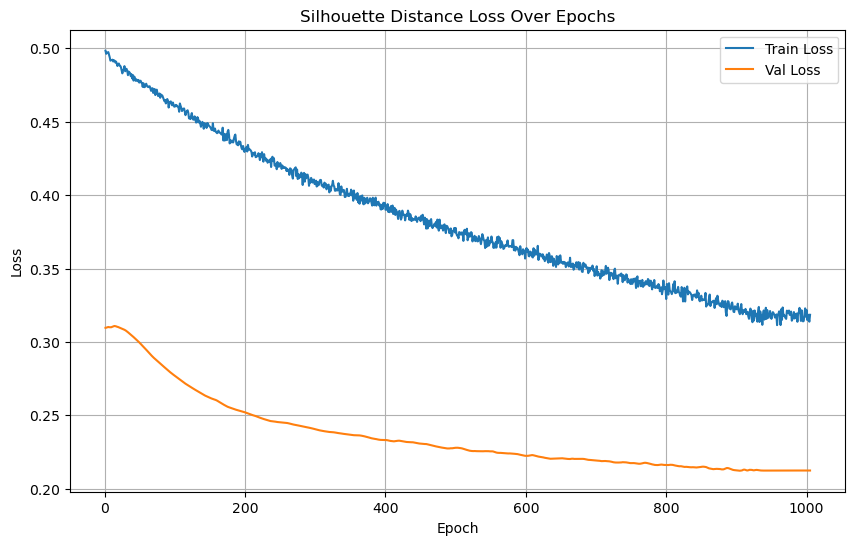

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/150], Loss: 0.1992
Test Batch [20/150], Loss: 0.2634
Test Batch [30/150], Loss: 0.3428


Test Batch [40/150], Loss: 0.3283
Test Batch [50/150], Loss: 0.4670
Test Batch [60/150], Loss: 0.3952
Test Batch [70/150], Loss: 0.3043


Test Batch [80/150], Loss: 0.2575
Test Batch [90/150], Loss: 0.2495
Test Batch [100/150], Loss: 0.2000
Test Batch [110/150], Loss: 0.2468
Test Batch [120/150], Loss: 0.1172


Test Batch [130/150], Loss: 0.4065
Test Batch [140/150], Loss: 0.2929
Test Batch [150/150], Loss: 0.1632

Test Loss: 0.3082


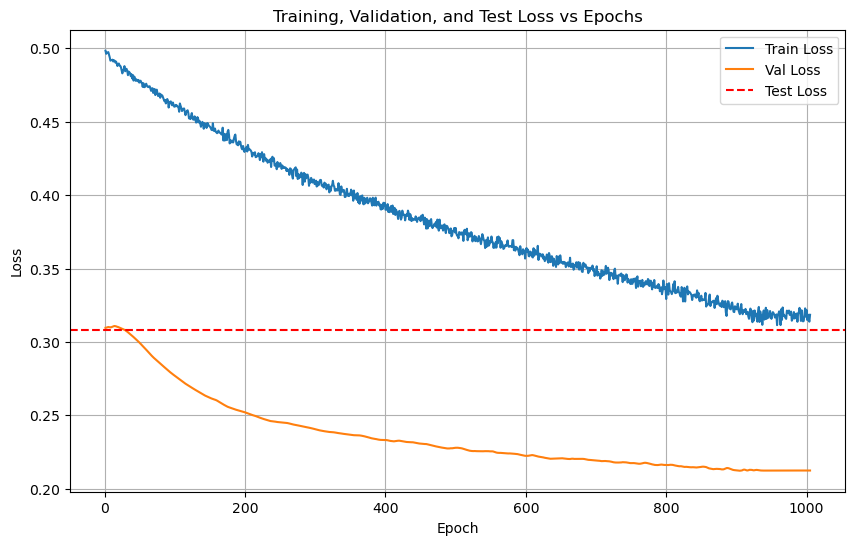

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/150 for test dataset.


  Processed batch 20/150 for test dataset.
  Processed batch 30/150 for test dataset.
  Processed batch 40/150 for test dataset.


  Processed batch 50/150 for test dataset.
  Processed batch 60/150 for test dataset.
  Processed batch 70/150 for test dataset.


  Processed batch 80/150 for test dataset.
  Processed batch 90/150 for test dataset.
  Processed batch 100/150 for test dataset.
  Processed batch 110/150 for test dataset.


  Processed batch 120/150 for test dataset.
  Processed batch 130/150 for test dataset.
  Processed batch 140/150 for test dataset.
  Processed batch 150/150 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 74.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.33      0.20      0.25         5
           2       0.50      0.40      0.44         5
           3       0.62      1.00      0.77         5
           4       0.83      1.00      0.91         5
           5       0.71      1.00      0.83         5
           7       1.00      0.80      0.89         5
           9       0.83      1.00      0.91         5
          10       0.60      0.60      0.60         5
          11       0.25      0.20      0.22         5
          12       1.00      0.80      0.89         5
          13       0.80      0.80      0.80         5
          14       1.00      0.60      0.75         5
          15       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9376  |  Val Loss: 2.9270
Validation loss improved from inf to 2.9270.


[Epoch 2/1000] Train Loss: 2.8994  |  Val Loss: 2.8911
Validation loss improved from 2.9270 to 2.8911.
[Epoch 3/1000] Train Loss: 2.8658  |  Val Loss: 2.8575
Validation loss improved from 2.8911 to 2.8575.
[Epoch 4/1000] Train Loss: 2.8328  |  Val Loss: 2.8249
Validation loss improved from 2.8575 to 2.8249.
[Epoch 5/1000] Train Loss: 2.8003  |  Val Loss: 2.7949
Validation loss improved from 2.8249 to 2.7949.


[Epoch 6/1000] Train Loss: 2.7702  |  Val Loss: 2.7668
Validation loss improved from 2.7949 to 2.7668.
[Epoch 7/1000] Train Loss: 2.7407  |  Val Loss: 2.7388
Validation loss improved from 2.7668 to 2.7388.
[Epoch 8/1000] Train Loss: 2.7137  |  Val Loss: 2.7120
Validation loss improved from 2.7388 to 2.7120.
[Epoch 9/1000] Train Loss: 2.6860  |  Val Loss: 2.6864
Validation loss improved from 2.7120 to 2.6864.
[Epoch 10/1000] Train Loss: 2.6624  |  Val Loss: 2.6601
Validation loss improved from 2.6864 to 2.6601.
[Epoch 11/1000] Train Loss: 2.6363  |  Val Loss: 2.6366
Validation loss improved from 2.6601 to 2.6366.
[Epoch 12/1000] Train Loss: 2.6141  |  Val Loss: 2.6143
Validation loss improved from 2.6366 to 2.6143.
[Epoch 13/1000] Train Loss: 2.5919  |  Val Loss: 2.5948
Validation loss improved from 2.6143 to 2.5948.
[Epoch 14/1000] Train Loss: 2.5730  |  Val Loss: 2.5760
Validation loss improved from 2.5948 to 2.5760.


[Epoch 15/1000] Train Loss: 2.5531  |  Val Loss: 2.5553
Validation loss improved from 2.5760 to 2.5553.
[Epoch 16/1000] Train Loss: 2.5322  |  Val Loss: 2.5343
Validation loss improved from 2.5553 to 2.5343.
[Epoch 17/1000] Train Loss: 2.5109  |  Val Loss: 2.5131
Validation loss improved from 2.5343 to 2.5131.
[Epoch 18/1000] Train Loss: 2.4902  |  Val Loss: 2.4930
Validation loss improved from 2.5131 to 2.4930.
[Epoch 19/1000] Train Loss: 2.4700  |  Val Loss: 2.4745
Validation loss improved from 2.4930 to 2.4745.


[Epoch 20/1000] Train Loss: 2.4518  |  Val Loss: 2.4572
Validation loss improved from 2.4745 to 2.4572.
[Epoch 21/1000] Train Loss: 2.4336  |  Val Loss: 2.4416
Validation loss improved from 2.4572 to 2.4416.
[Epoch 22/1000] Train Loss: 2.4173  |  Val Loss: 2.4268
Validation loss improved from 2.4416 to 2.4268.
[Epoch 23/1000] Train Loss: 2.4009  |  Val Loss: 2.4124
Validation loss improved from 2.4268 to 2.4124.
[Epoch 24/1000] Train Loss: 2.3856  |  Val Loss: 2.3989
Validation loss improved from 2.4124 to 2.3989.
[Epoch 25/1000] Train Loss: 2.3695  |  Val Loss: 2.3862
Validation loss improved from 2.3989 to 2.3862.


[Epoch 26/1000] Train Loss: 2.3546  |  Val Loss: 2.3739
Validation loss improved from 2.3862 to 2.3739.
[Epoch 27/1000] Train Loss: 2.3394  |  Val Loss: 2.3617
Validation loss improved from 2.3739 to 2.3617.
[Epoch 28/1000] Train Loss: 2.3247  |  Val Loss: 2.3495
Validation loss improved from 2.3617 to 2.3495.
[Epoch 29/1000] Train Loss: 2.3094  |  Val Loss: 2.3373
Validation loss improved from 2.3495 to 2.3373.
[Epoch 30/1000] Train Loss: 2.2946  |  Val Loss: 2.3249
Validation loss improved from 2.3373 to 2.3249.
[Epoch 31/1000] Train Loss: 2.2798  |  Val Loss: 2.3129
Validation loss improved from 2.3249 to 2.3129.
[Epoch 32/1000] Train Loss: 2.2652  |  Val Loss: 2.3009
Validation loss improved from 2.3129 to 2.3009.
[Epoch 33/1000] Train Loss: 2.2501  |  Val Loss: 2.2891
Validation loss improved from 2.3009 to 2.2891.
[Epoch 34/1000] Train Loss: 2.2353  |  Val Loss: 2.2774
Validation loss improved from 2.2891 to 2.2774.


[Epoch 35/1000] Train Loss: 2.2207  |  Val Loss: 2.2656
Validation loss improved from 2.2774 to 2.2656.
[Epoch 36/1000] Train Loss: 2.2057  |  Val Loss: 2.2544
Validation loss improved from 2.2656 to 2.2544.
[Epoch 37/1000] Train Loss: 2.1914  |  Val Loss: 2.2429
Validation loss improved from 2.2544 to 2.2429.
[Epoch 38/1000] Train Loss: 2.1763  |  Val Loss: 2.2311
Validation loss improved from 2.2429 to 2.2311.


[Epoch 39/1000] Train Loss: 2.1616  |  Val Loss: 2.2196
Validation loss improved from 2.2311 to 2.2196.
[Epoch 40/1000] Train Loss: 2.1469  |  Val Loss: 2.2078
Validation loss improved from 2.2196 to 2.2078.
[Epoch 41/1000] Train Loss: 2.1314  |  Val Loss: 2.1962
Validation loss improved from 2.2078 to 2.1962.
[Epoch 42/1000] Train Loss: 2.1158  |  Val Loss: 2.1843
Validation loss improved from 2.1962 to 2.1843.


[Epoch 43/1000] Train Loss: 2.1003  |  Val Loss: 2.1726
Validation loss improved from 2.1843 to 2.1726.
[Epoch 44/1000] Train Loss: 2.0848  |  Val Loss: 2.1606
Validation loss improved from 2.1726 to 2.1606.
[Epoch 45/1000] Train Loss: 2.0686  |  Val Loss: 2.1488
Validation loss improved from 2.1606 to 2.1488.
[Epoch 46/1000] Train Loss: 2.0519  |  Val Loss: 2.1370
Validation loss improved from 2.1488 to 2.1370.
[Epoch 47/1000] Train Loss: 2.0356  |  Val Loss: 2.1249
Validation loss improved from 2.1370 to 2.1249.
[Epoch 48/1000] Train Loss: 2.0189  |  Val Loss: 2.1129
Validation loss improved from 2.1249 to 2.1129.
[Epoch 49/1000] Train Loss: 2.0024  |  Val Loss: 2.1003
Validation loss improved from 2.1129 to 2.1003.
[Epoch 50/1000] Train Loss: 1.9853  |  Val Loss: 2.0877
Validation loss improved from 2.1003 to 2.0877.
[Epoch 51/1000] Train Loss: 1.9684  |  Val Loss: 2.0750
Validation loss improved from 2.0877 to 2.0750.
[Epoch 52/1000] Train Loss: 1.9518  |  Val Loss: 2.0620
Validati

[Epoch 54/1000] Train Loss: 1.9174  |  Val Loss: 2.0352
Validation loss improved from 2.0484 to 2.0352.
[Epoch 55/1000] Train Loss: 1.9002  |  Val Loss: 2.0219
Validation loss improved from 2.0352 to 2.0219.
[Epoch 56/1000] Train Loss: 1.8822  |  Val Loss: 2.0088
Validation loss improved from 2.0219 to 2.0088.
[Epoch 57/1000] Train Loss: 1.8652  |  Val Loss: 1.9956
Validation loss improved from 2.0088 to 1.9956.


[Epoch 58/1000] Train Loss: 1.8476  |  Val Loss: 1.9825
Validation loss improved from 1.9956 to 1.9825.
[Epoch 59/1000] Train Loss: 1.8294  |  Val Loss: 1.9691
Validation loss improved from 1.9825 to 1.9691.
[Epoch 60/1000] Train Loss: 1.8115  |  Val Loss: 1.9556
Validation loss improved from 1.9691 to 1.9556.


[Epoch 61/1000] Train Loss: 1.7938  |  Val Loss: 1.9415
Validation loss improved from 1.9556 to 1.9415.
[Epoch 62/1000] Train Loss: 1.7753  |  Val Loss: 1.9273
Validation loss improved from 1.9415 to 1.9273.
[Epoch 63/1000] Train Loss: 1.7571  |  Val Loss: 1.9135
Validation loss improved from 1.9273 to 1.9135.
[Epoch 64/1000] Train Loss: 1.7382  |  Val Loss: 1.8995
Validation loss improved from 1.9135 to 1.8995.
[Epoch 65/1000] Train Loss: 1.7199  |  Val Loss: 1.8851
Validation loss improved from 1.8995 to 1.8851.
[Epoch 66/1000] Train Loss: 1.7011  |  Val Loss: 1.8712
Validation loss improved from 1.8851 to 1.8712.
[Epoch 67/1000] Train Loss: 1.6826  |  Val Loss: 1.8570
Validation loss improved from 1.8712 to 1.8570.
[Epoch 68/1000] Train Loss: 1.6637  |  Val Loss: 1.8428
Validation loss improved from 1.8570 to 1.8428.
[Epoch 69/1000] Train Loss: 1.6456  |  Val Loss: 1.8285
Validation loss improved from 1.8428 to 1.8285.
[Epoch 70/1000] Train Loss: 1.6265  |  Val Loss: 1.8140
Validati

[Epoch 73/1000] Train Loss: 1.5699  |  Val Loss: 1.7694
Validation loss improved from 1.7844 to 1.7694.
[Epoch 74/1000] Train Loss: 1.5509  |  Val Loss: 1.7544
Validation loss improved from 1.7694 to 1.7544.
[Epoch 75/1000] Train Loss: 1.5315  |  Val Loss: 1.7389
Validation loss improved from 1.7544 to 1.7389.
[Epoch 76/1000] Train Loss: 1.5131  |  Val Loss: 1.7235
Validation loss improved from 1.7389 to 1.7235.


[Epoch 77/1000] Train Loss: 1.4939  |  Val Loss: 1.7084
Validation loss improved from 1.7235 to 1.7084.


[Epoch 78/1000] Train Loss: 1.4754  |  Val Loss: 1.6926
Validation loss improved from 1.7084 to 1.6926.
[Epoch 79/1000] Train Loss: 1.4567  |  Val Loss: 1.6772
Validation loss improved from 1.6926 to 1.6772.
[Epoch 80/1000] Train Loss: 1.4378  |  Val Loss: 1.6620
Validation loss improved from 1.6772 to 1.6620.
[Epoch 81/1000] Train Loss: 1.4191  |  Val Loss: 1.6471
Validation loss improved from 1.6620 to 1.6471.
[Epoch 82/1000] Train Loss: 1.4003  |  Val Loss: 1.6320
Validation loss improved from 1.6471 to 1.6320.
[Epoch 83/1000] Train Loss: 1.3824  |  Val Loss: 1.6172
Validation loss improved from 1.6320 to 1.6172.
[Epoch 84/1000] Train Loss: 1.3641  |  Val Loss: 1.6022
Validation loss improved from 1.6172 to 1.6022.
[Epoch 85/1000] Train Loss: 1.3459  |  Val Loss: 1.5874
Validation loss improved from 1.6022 to 1.5874.
[Epoch 86/1000] Train Loss: 1.3280  |  Val Loss: 1.5732
Validation loss improved from 1.5874 to 1.5732.
[Epoch 87/1000] Train Loss: 1.3095  |  Val Loss: 1.5586
Validati

[Epoch 93/1000] Train Loss: 1.2035  |  Val Loss: 1.4753
Validation loss improved from 1.4895 to 1.4753.
[Epoch 94/1000] Train Loss: 1.1862  |  Val Loss: 1.4616
Validation loss improved from 1.4753 to 1.4616.
[Epoch 95/1000] Train Loss: 1.1690  |  Val Loss: 1.4483
Validation loss improved from 1.4616 to 1.4483.
[Epoch 96/1000] Train Loss: 1.1523  |  Val Loss: 1.4347
Validation loss improved from 1.4483 to 1.4347.


[Epoch 97/1000] Train Loss: 1.1358  |  Val Loss: 1.4210
Validation loss improved from 1.4347 to 1.4210.
[Epoch 98/1000] Train Loss: 1.1192  |  Val Loss: 1.4070
Validation loss improved from 1.4210 to 1.4070.
[Epoch 99/1000] Train Loss: 1.1026  |  Val Loss: 1.3940
Validation loss improved from 1.4070 to 1.3940.
[Epoch 100/1000] Train Loss: 1.0867  |  Val Loss: 1.3808
Validation loss improved from 1.3940 to 1.3808.
[Epoch 101/1000] Train Loss: 1.0702  |  Val Loss: 1.3676
Validation loss improved from 1.3808 to 1.3676.
[Epoch 102/1000] Train Loss: 1.0553  |  Val Loss: 1.3535
Validation loss improved from 1.3676 to 1.3535.
[Epoch 103/1000] Train Loss: 1.0395  |  Val Loss: 1.3406
Validation loss improved from 1.3535 to 1.3406.
[Epoch 104/1000] Train Loss: 1.0248  |  Val Loss: 1.3280
Validation loss improved from 1.3406 to 1.3280.
[Epoch 105/1000] Train Loss: 1.0095  |  Val Loss: 1.3166
Validation loss improved from 1.3280 to 1.3166.
[Epoch 106/1000] Train Loss: 0.9946  |  Val Loss: 1.3046
V

[Epoch 113/1000] Train Loss: 0.8986  |  Val Loss: 1.2270
Validation loss improved from 1.2375 to 1.2270.
[Epoch 114/1000] Train Loss: 0.8859  |  Val Loss: 1.2172
Validation loss improved from 1.2270 to 1.2172.
[Epoch 115/1000] Train Loss: 0.8732  |  Val Loss: 1.2079
Validation loss improved from 1.2172 to 1.2079.
[Epoch 116/1000] Train Loss: 0.8610  |  Val Loss: 1.1982
Validation loss improved from 1.2079 to 1.1982.


[Epoch 117/1000] Train Loss: 0.8492  |  Val Loss: 1.1885
Validation loss improved from 1.1982 to 1.1885.
[Epoch 118/1000] Train Loss: 0.8376  |  Val Loss: 1.1794
Validation loss improved from 1.1885 to 1.1794.
[Epoch 119/1000] Train Loss: 0.8259  |  Val Loss: 1.1719
Validation loss improved from 1.1794 to 1.1719.
[Epoch 120/1000] Train Loss: 0.8146  |  Val Loss: 1.1653
Validation loss improved from 1.1719 to 1.1653.
[Epoch 121/1000] Train Loss: 0.8036  |  Val Loss: 1.1570
Validation loss improved from 1.1653 to 1.1570.
[Epoch 122/1000] Train Loss: 0.7929  |  Val Loss: 1.1494
Validation loss improved from 1.1570 to 1.1494.
[Epoch 123/1000] Train Loss: 0.7824  |  Val Loss: 1.1415
Validation loss improved from 1.1494 to 1.1415.
[Epoch 124/1000] Train Loss: 0.7714  |  Val Loss: 1.1332
Validation loss improved from 1.1415 to 1.1332.
[Epoch 125/1000] Train Loss: 0.7614  |  Val Loss: 1.1280
Validation loss improved from 1.1332 to 1.1280.
[Epoch 126/1000] Train Loss: 0.7515  |  Val Loss: 1.120

[Epoch 131/1000] Train Loss: 0.7053  |  Val Loss: 1.0950
Validation loss improved from 1.0999 to 1.0950.
[Epoch 132/1000] Train Loss: 0.6970  |  Val Loss: 1.0896
Validation loss improved from 1.0950 to 1.0896.
[Epoch 133/1000] Train Loss: 0.6884  |  Val Loss: 1.0850
Validation loss improved from 1.0896 to 1.0850.
[Epoch 134/1000] Train Loss: 0.6805  |  Val Loss: 1.0786
Validation loss improved from 1.0850 to 1.0786.


[Epoch 135/1000] Train Loss: 0.6728  |  Val Loss: 1.0736
Validation loss improved from 1.0786 to 1.0736.
[Epoch 136/1000] Train Loss: 0.6646  |  Val Loss: 1.0689
Validation loss improved from 1.0736 to 1.0689.
[Epoch 137/1000] Train Loss: 0.6573  |  Val Loss: 1.0647
Validation loss improved from 1.0689 to 1.0647.
[Epoch 138/1000] Train Loss: 0.6497  |  Val Loss: 1.0604
Validation loss improved from 1.0647 to 1.0604.
[Epoch 139/1000] Train Loss: 0.6426  |  Val Loss: 1.0565
Validation loss improved from 1.0604 to 1.0565.
[Epoch 140/1000] Train Loss: 0.6359  |  Val Loss: 1.0534
Validation loss improved from 1.0565 to 1.0534.
[Epoch 141/1000] Train Loss: 0.6286  |  Val Loss: 1.0499
Validation loss improved from 1.0534 to 1.0499.
[Epoch 142/1000] Train Loss: 0.6221  |  Val Loss: 1.0467
Validation loss improved from 1.0499 to 1.0467.
[Epoch 143/1000] Train Loss: 0.6157  |  Val Loss: 1.0433
Validation loss improved from 1.0467 to 1.0433.
[Epoch 144/1000] Train Loss: 0.6093  |  Val Loss: 1.039

[Epoch 151/1000] Train Loss: 0.5681  |  Val Loss: 1.0165
Validation loss improved from 1.0196 to 1.0165.
[Epoch 152/1000] Train Loss: 0.5628  |  Val Loss: 1.0162
Validation loss improved from 1.0165 to 1.0162.
[Epoch 153/1000] Train Loss: 0.5571  |  Val Loss: 1.0156
Validation loss improved from 1.0162 to 1.0156.
[Epoch 154/1000] Train Loss: 0.5518  |  Val Loss: 1.0133
Validation loss improved from 1.0156 to 1.0133.
[Epoch 155/1000] Train Loss: 0.5468  |  Val Loss: 1.0103
Validation loss improved from 1.0133 to 1.0103.
[Epoch 156/1000] Train Loss: 0.5424  |  Val Loss: 1.0081
Validation loss improved from 1.0103 to 1.0081.
[Epoch 157/1000] Train Loss: 0.5367  |  Val Loss: 1.0045
Validation loss improved from 1.0081 to 1.0045.
[Epoch 158/1000] Train Loss: 0.5324  |  Val Loss: 1.0021
Validation loss improved from 1.0045 to 1.0021.
[Epoch 159/1000] Train Loss: 0.5276  |  Val Loss: 1.0005
Validation loss improved from 1.0021 to 1.0005.
[Epoch 160/1000] Train Loss: 0.5230  |  Val Loss: 0.999

[Epoch 170/1000] Train Loss: 0.4814  |  Val Loss: 0.9873
Validation loss improved from 0.9873 to 0.9873.
[Epoch 171/1000] Train Loss: 0.4780  |  Val Loss: 0.9864
Validation loss improved from 0.9873 to 0.9864.
[Epoch 172/1000] Train Loss: 0.4739  |  Val Loss: 0.9849
Validation loss improved from 0.9864 to 0.9849.
[Epoch 173/1000] Train Loss: 0.4704  |  Val Loss: 0.9824
Validation loss improved from 0.9849 to 0.9824.
[Epoch 174/1000] Train Loss: 0.4669  |  Val Loss: 0.9818
Validation loss improved from 0.9824 to 0.9818.
[Epoch 175/1000] Train Loss: 0.4631  |  Val Loss: 0.9793
Validation loss improved from 0.9818 to 0.9793.
[Epoch 176/1000] Train Loss: 0.4599  |  Val Loss: 0.9781
Validation loss improved from 0.9793 to 0.9781.
[Epoch 177/1000] Train Loss: 0.4569  |  Val Loss: 0.9796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 178/1000] Train Loss: 0.4531  |  Val Loss: 0.9790
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 179/1000] Train Loss: 0.4502  |  Val

[Epoch 188/1000] Train Loss: 0.4237  |  Val Loss: 0.9713
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 189/1000] Train Loss: 0.4209  |  Val Loss: 0.9714
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 190/1000] Train Loss: 0.4179  |  Val Loss: 0.9696
Validation loss improved from 0.9700 to 0.9696.
[Epoch 191/1000] Train Loss: 0.4153  |  Val Loss: 0.9668
Validation loss improved from 0.9696 to 0.9668.
[Epoch 192/1000] Train Loss: 0.4130  |  Val Loss: 0.9662
Validation loss improved from 0.9668 to 0.9662.
[Epoch 193/1000] Train Loss: 0.4104  |  Val Loss: 0.9648
Validation loss improved from 0.9662 to 0.9648.
[Epoch 194/1000] Train Loss: 0.4083  |  Val Loss: 0.9669
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 195/1000] Train Loss: 0.4052  |  Val Loss: 0.9674
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 196/1000] Train Loss: 0.4029  |  Val Loss: 0.9650
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 197/1000] Train Lo

[Epoch 208/1000] Train Loss: 0.3758  |  Val Loss: 0.9592
Validation loss improved from 0.9596 to 0.9592.
[Epoch 209/1000] Train Loss: 0.3734  |  Val Loss: 0.9603
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 0.3716  |  Val Loss: 0.9577
Validation loss improved from 0.9592 to 0.9577.
[Epoch 211/1000] Train Loss: 0.3692  |  Val Loss: 0.9577
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/1000] Train Loss: 0.3670  |  Val Loss: 0.9589
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 213/1000] Train Loss: 0.3652  |  Val Loss: 0.9583
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 214/1000] Train Loss: 0.3634  |  Val Loss: 0.9590
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 215/1000] Train Loss: 0.3613  |  Val Loss: 0.9591
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 216/1000] Train Loss: 0.3594  |  Val Loss: 0.9586
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 217/10

[Epoch 226/1000] Train Loss: 0.3413  |  Val Loss: 0.9523
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 0.3399  |  Val Loss: 0.9523
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 228/1000] Train Loss: 0.3382  |  Val Loss: 0.9507
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 229/1000] Train Loss: 0.3361  |  Val Loss: 0.9503
Validation loss improved from 0.9505 to 0.9503.
[Epoch 230/1000] Train Loss: 0.3343  |  Val Loss: 0.9525
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 231/1000] Train Loss: 0.3328  |  Val Loss: 0.9528
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 232/1000] Train Loss: 0.3311  |  Val Loss: 0.9507
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 233/1000] Train Loss: 0.3293  |  Val Loss: 0.9508
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 234/1000] Train Loss: 0.3278  |  Val Loss: 0.9505
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 245/1000] Train Loss: 0.3108  |  Val Loss: 0.9484
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 246/1000] Train Loss: 0.3094  |  Val Loss: 0.9487
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 247/1000] Train Loss: 0.3080  |  Val Loss: 0.9494
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 248/1000] Train Loss: 0.3065  |  Val Loss: 0.9506
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 249/1000] Train Loss: 0.3049  |  Val Loss: 0.9520
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 250/1000] Train Loss: 0.3037  |  Val Loss: 0.9511
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 251/1000] Train Loss: 0.3023  |  Val Loss: 0.9506
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 252/1000] Train Loss: 0.3010  |  Val Loss: 0.9501
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 253/1000] Train Loss: 0.2996  |  Val Loss: 0.9514
!! Validation loss did NOT improve !! Patience: 1

[Epoch 265/1000] Train Loss: 0.2843  |  Val Loss: 0.9535
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 266/1000] Train Loss: 0.2830  |  Val Loss: 0.9555
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 267/1000] Train Loss: 0.2816  |  Val Loss: 0.9541
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 268/1000] Train Loss: 0.2805  |  Val Loss: 0.9523
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 269/1000] Train Loss: 0.2795  |  Val Loss: 0.9510
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 270/1000] Train Loss: 0.2780  |  Val Loss: 0.9550
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 271/1000] Train Loss: 0.2769  |  Val Loss: 0.9549
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 272/1000] Train Loss: 0.2757  |  Val Loss: 0.9557
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 273/1000] Train Loss: 0.2748  |  Val Loss: 0.9525
!! Validation loss did NOT improve !! Patience:

[Epoch 284/1000] Train Loss: 0.2625  |  Val Loss: 0.9595
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 285/1000] Train Loss: 0.2614  |  Val Loss: 0.9602
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 286/1000] Train Loss: 0.2604  |  Val Loss: 0.9565
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 287/1000] Train Loss: 0.2596  |  Val Loss: 0.9579
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 288/1000] Train Loss: 0.2585  |  Val Loss: 0.9610
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 289/1000] Train Loss: 0.2574  |  Val Loss: 0.9583
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 290/1000] Train Loss: 0.2563  |  Val Loss: 0.9605
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 291/1000] Train Loss: 0.2554  |  Val Loss: 0.9614
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 292/1000] Train Loss: 0.2545  |  Val Loss: 0.9619
!! Validation loss did NOT improve !! Patience:

[Epoch 304/1000] Train Loss: 0.2429  |  Val Loss: 0.9656
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 305/1000] Train Loss: 0.2420  |  Val Loss: 0.9671
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 306/1000] Train Loss: 0.2413  |  Val Loss: 0.9691
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 307/1000] Train Loss: 0.2401  |  Val Loss: 0.9709
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 308/1000] Train Loss: 0.2391  |  Val Loss: 0.9701
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 309/1000] Train Loss: 0.2384  |  Val Loss: 0.9684
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 310/1000] Train Loss: 0.2381  |  Val Loss: 0.9686
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 311/1000] Train Loss: 0.2368  |  Val Loss: 0.9714
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 312/1000] Train Loss: 0.2361  |  Val Loss: 0.9688
!! Validation loss did NOT improve !! Patience:

[Epoch 322/1000] Train Loss: 0.2274  |  Val Loss: 0.9747
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 323/1000] Train Loss: 0.2269  |  Val Loss: 0.9770
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 324/1000] Train Loss: 0.2264  |  Val Loss: 0.9809
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 325/1000] Train Loss: 0.2252  |  Val Loss: 0.9802
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 326/1000] Train Loss: 0.2244  |  Val Loss: 0.9789
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 327/1000] Train Loss: 0.2239  |  Val Loss: 0.9769
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 328/1000] Train Loss: 0.2230  |  Val Loss: 0.9786
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 329/1000] Train Loss: 0.2224  |  Val Loss: 0.9804
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 330/1000] Train Loss: 0.2214  |  Val Loss: 0.9825
!! Validation loss did NOT improve !! Patience:

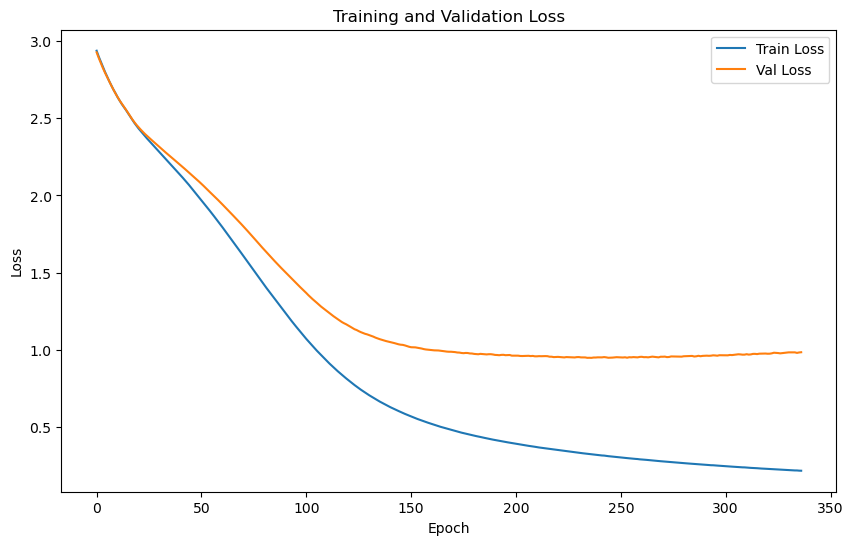

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.4687 | Test Accuracy: 55.03%


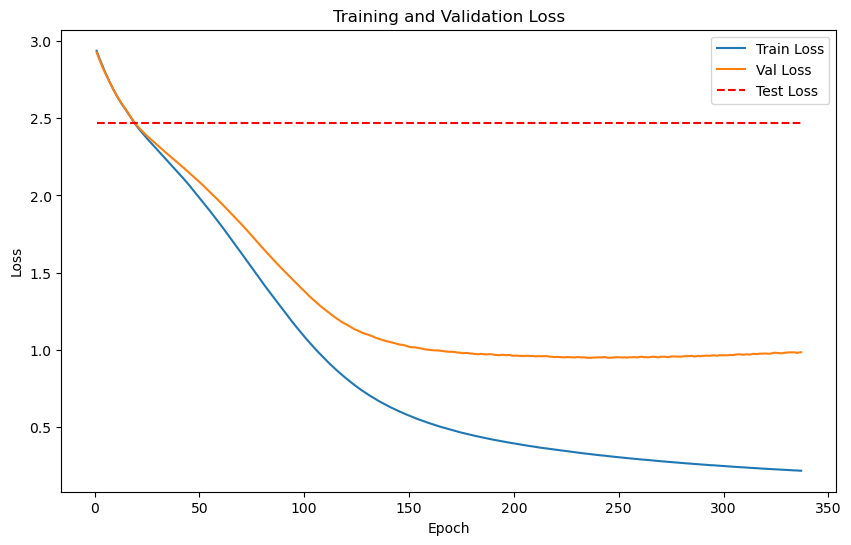

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


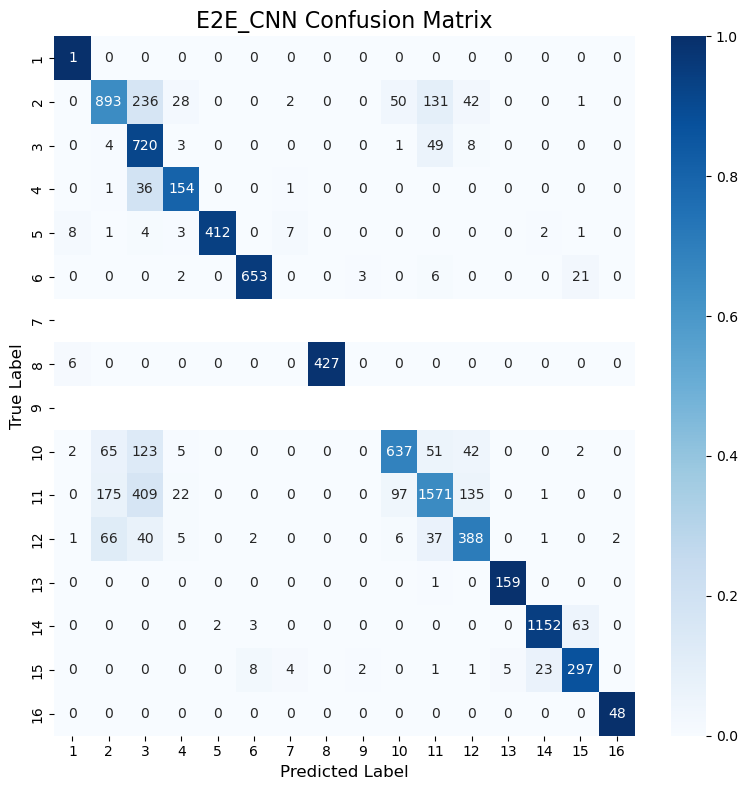

Classification Accuracy: 78.49%


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


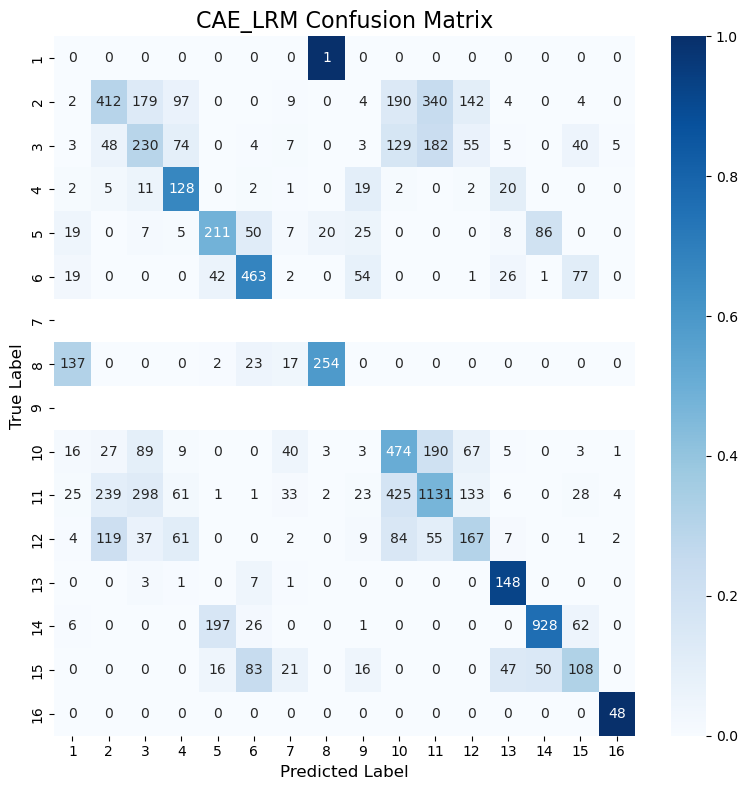

Classification Accuracy: 49.13%


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


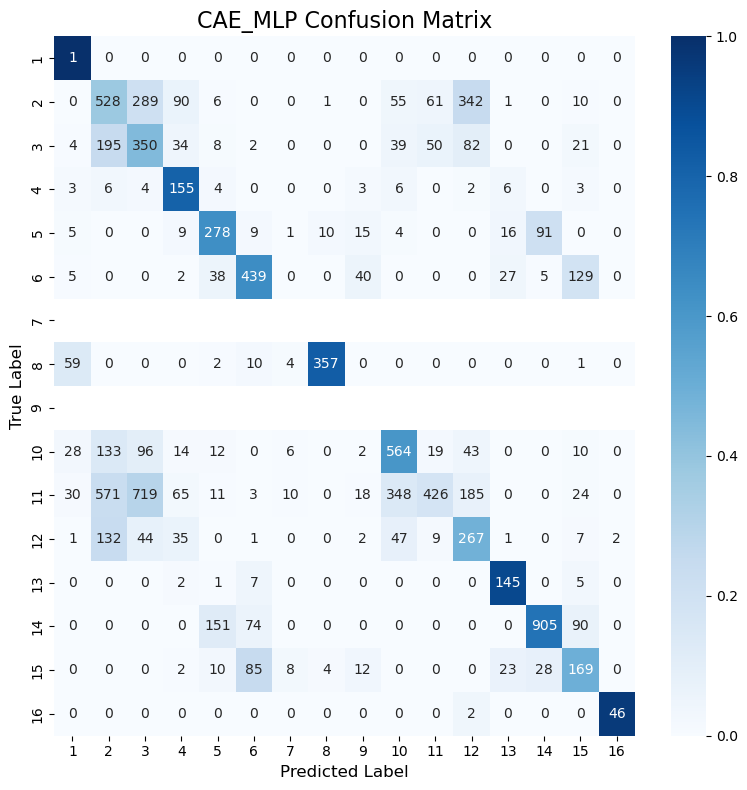

Classification Accuracy: 48.38%


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


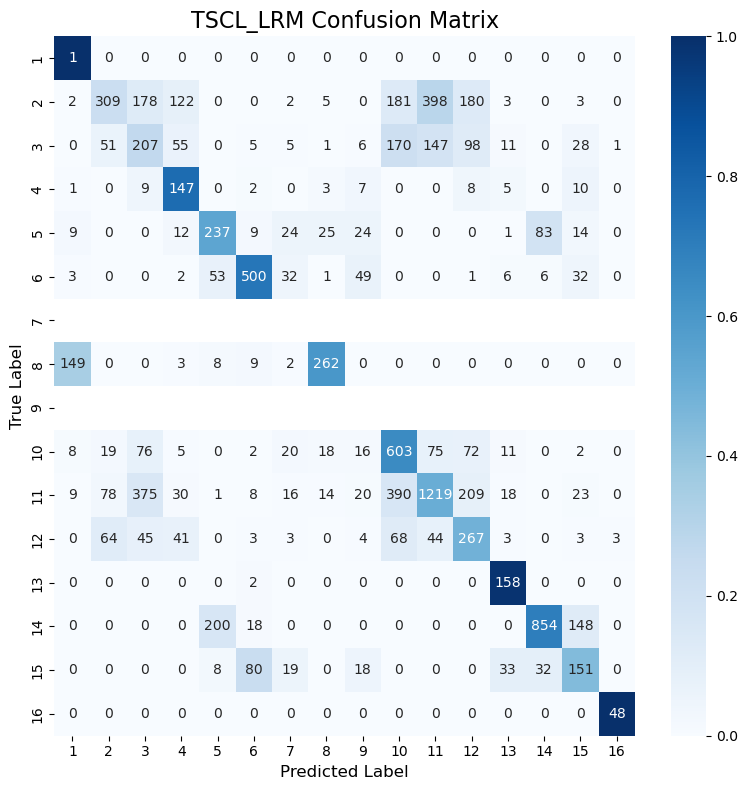

Classification Accuracy: 51.85%


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


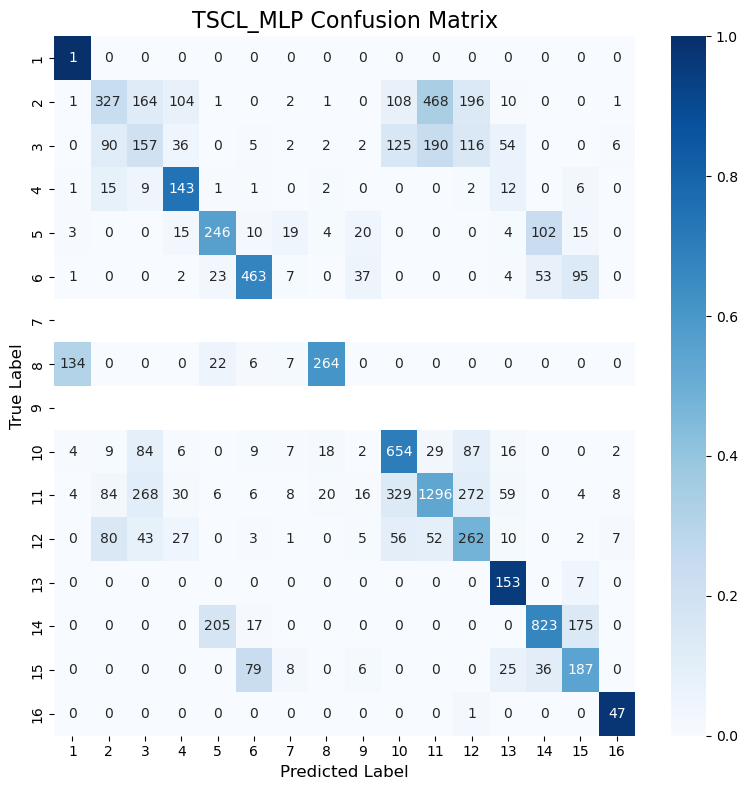

Classification Accuracy: 52.48%


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


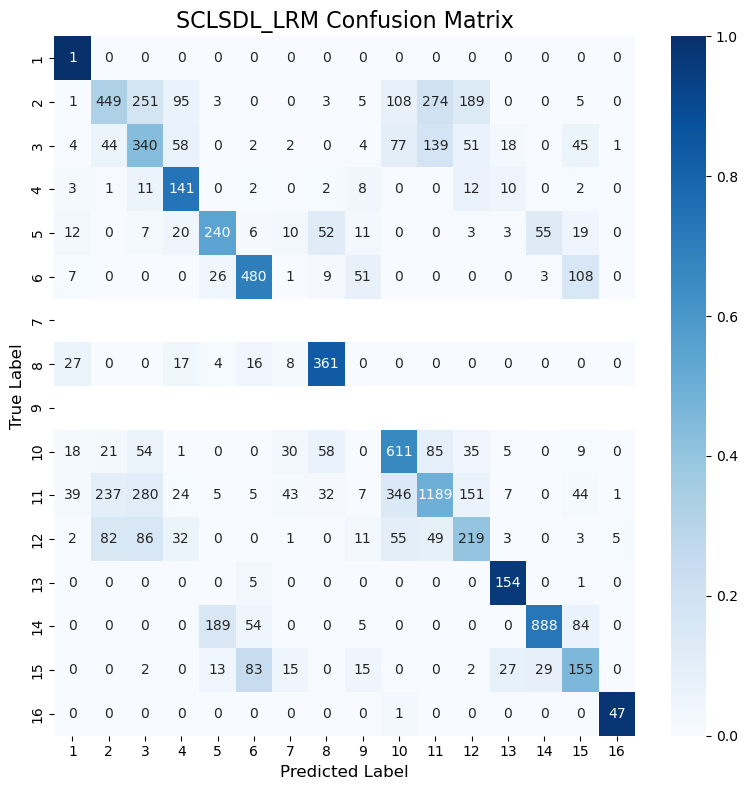

Classification Accuracy: 55.11%


C:\Users\vella\AppData\Local\Temp\ipykernel_12372\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


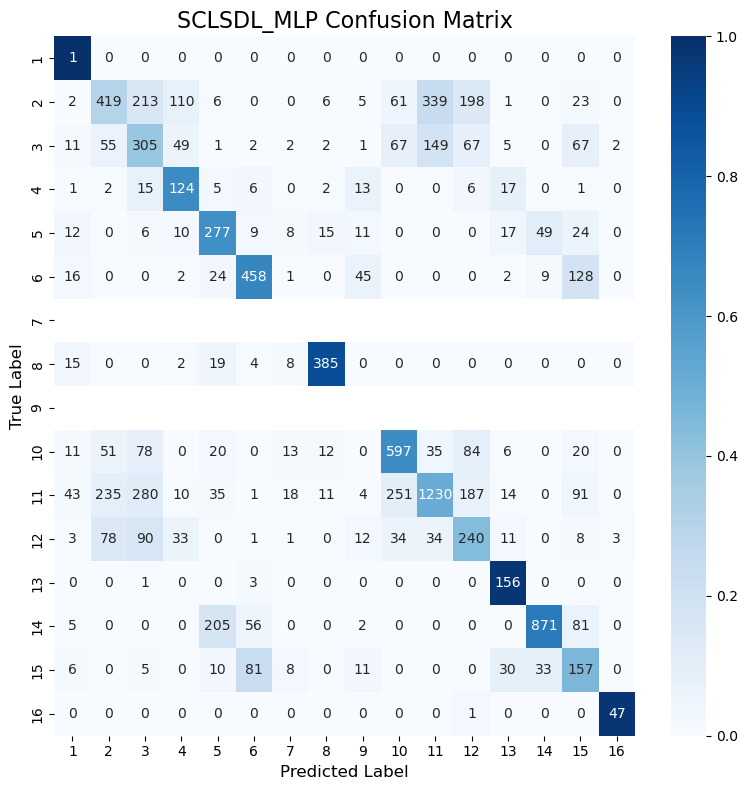

Classification Accuracy: 55.03%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          78.49
1    LRM (CAE)          49.13
2    MLP (CAE)          48.38
3     TSCL LRM          51.85
4     TSCL MLP          52.48
5  SCL_SDL LRM          55.11
6  SCL_SDL MLP          55.03

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          78.49
5  SCL_SDL LRM          55.11
6  SCL_SDL MLP          55.03
4     TSCL MLP          52.48
3     TSCL LRM          51.85
1    LRM (CAE)          49.13
2    MLP (CAE)          48.38
